In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [53]:
from PIL import Image

In [54]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.models as models
import os
from tqdm import tqdm

In [55]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [56]:
class ConvBlock(nn.Module):
  # helper module that consists of a Conv -> BN -> ReLU
  def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    # with_nonlinearity is a boolean flag indicating whether to include the ReLU activation.
    self.with_nonlinearity = with_nonlinearity

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    if self.with_nonlinearity:
        x = self.relu(x)
    return x

In [57]:
# bridge between the downsampling part with the upsampling part
class Bridge(nn.Module):
    """
    A module serving as a bridge between the downsampling and upsampling parts of a network.
    It consists of two consecutive ConvBlocks.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
          ConvBlock(in_channels, out_channels),
          ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)

In [58]:
resnet = torchvision.models.resnet.resnet50(pretrained=True)
list(resnet.children())[4:6]

[Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): Bottleneck(
     (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2):

In [59]:
(nn.ModuleList(resnet.children()))

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [60]:
down_blocks = []
for layer in resnet.children():
        if isinstance(layer, nn.Sequential):
            down_blocks.extend(bottleneck for bottleneck in layer)

nn.ModuleList(down_blocks[1:])

ModuleList(
  (0-1): 2 x Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (2): Bottleneck(
    (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 512, kernel_s

In [61]:
class Encoder(nn.Module):
    def __init__(self, in_channels, pretrained=True):
        super(Encoder, self).__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        
        self.input_layer = nn.Conv2d(in_channels, 256, kernel_size=7, stride=2, padding=3, bias=False)
        
        for layer in resnet.children():
            if isinstance(layer, nn.Sequential):
                down_blocks.extend(bottleneck.to(device) for bottleneck in layer)
        
        self.down_blocks = down_blocks[1:]  # Getting rid of the first layer
        self.brid = Bridge(2048, 2048).to(device)

    def forward(self, x):
        intermediate_outputs = dict()
        
        x = self.input_layer(x)
        intermediate_outputs['input_layer'] = x.clone()
        
        for i, layer in enumerate(self.down_blocks):
            x = layer(x)
            intermediate_outputs[f"DownLayer{i}"] = x.clone()
        
        x = self.brid(x)
        intermediate_outputs['Post_Bridge'] = x.clone()
        return x, intermediate_outputs

In [62]:
in_channels = 8
height = 256
width = 192
rand = torch.rand(1, in_channels, height, width).to(device)


In [63]:
encoder = Encoder(in_channels).to(device)

In [64]:
output = encoder(rand)
output[0].shape, type(output[1])

(torch.Size([1, 2048, 16, 12]), dict)

In [65]:
for key, value in output[1].items():
    print(f"{key} -- {value.size()}")

input_layer -- torch.Size([1, 256, 128, 96])
DownLayer0 -- torch.Size([1, 256, 128, 96])
DownLayer1 -- torch.Size([1, 256, 128, 96])
DownLayer2 -- torch.Size([1, 512, 64, 48])
DownLayer3 -- torch.Size([1, 512, 64, 48])
DownLayer4 -- torch.Size([1, 512, 64, 48])
DownLayer5 -- torch.Size([1, 512, 64, 48])
DownLayer6 -- torch.Size([1, 1024, 32, 24])
DownLayer7 -- torch.Size([1, 1024, 32, 24])
DownLayer8 -- torch.Size([1, 1024, 32, 24])
DownLayer9 -- torch.Size([1, 1024, 32, 24])
DownLayer10 -- torch.Size([1, 1024, 32, 24])
DownLayer11 -- torch.Size([1, 1024, 32, 24])
DownLayer12 -- torch.Size([1, 2048, 16, 12])
DownLayer13 -- torch.Size([1, 2048, 16, 12])
DownLayer14 -- torch.Size([1, 2048, 16, 12])
Post_Bridge -- torch.Size([1, 2048, 16, 12])


In [66]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        
        self.upsample9 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels=1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        self.upsample5 = nn.Sequential(
            nn.ConvTranspose2d(1024 + 1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(512 + 512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.upsample_fin = nn.ConvTranspose2d(256 + 256, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x, encoder_intermediates):
        x = self.upsample9(x)
        x = torch.cat((x, encoder_intermediates["DownLayer11"]), dim=1)

        x = self.upsample5(x)
        x = torch.cat((x, encoder_intermediates["DownLayer5"]), dim=1)

        x = self.upsample1(x)
        x = torch.cat((x, encoder_intermediates["DownLayer1"]), dim=1)

        x = self.upsample_fin(x)
        return x

In [67]:
# # Your tensor
# input_tensor = torch.rand(1, in_channels, height, width)

# # Values to map to
# mapping_values = torch.tensor([0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# # Manual rounding to the nearest integer from the list
# rounded_tensor = torch.zeros_like(input_tensor, dtype=torch.long)

# for i in range(input_tensor.size(-2)):
#     for j in range(input_tensor.size(-1)):
#         value = input_tensor[0, 0, i, j].item()
#         closest_integer = min(mapping_values, key=lambda x: abs(x - value))
#         rounded_tensor[0, 0, i, j] = closest_integer

# print(rounded_tensor.shape)

In [68]:
decoder = Decoder(2048, 8).to(device)
decoder_out = decoder(output[0], output[1])

In [69]:
decoder_out.size()

torch.Size([1, 8, 256, 192])

In [70]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = Encoder(in_channels).to(device)
        self.decoder = Decoder(2048, out_channels).to(device) # 2048 channels output from the Encoder

    def forward(self, x):
        # forward pass through the encoder        
        x, encoder_outputs = self.encoder(x)

        # forward pass through the decoder with encoder's intermediate outputs
        decoder_output = self.decoder(x, encoder_outputs)

        
        
        return decoder_output

In [71]:
dummyunet = UNet(8,8).to(device)
rand = torch.rand(1, 8, 256, 192).to(device)
u_out = dummyunet(rand)
u_out.shape

torch.Size([1, 8, 256, 192])

In [72]:
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        
        # additional layers to reduce input channels
        self.conv1 = nn.Conv2d(input_channels, 6, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2= nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(3)
        self.relu2= nn.ReLU(inplace=True)
        # pre-trained ResNet50
        self.resnet50 = models.resnet50(pretrained=True)
        
        # freeze all layers
        for param in self.resnet50.parameters():
            param.requires_grad = False
            
        # unfreeze layer4 of ResNet50
        for param in self.resnet50.layer4.parameters():
            param.requires_grad = True
        
        # modify the final layer for binary classification
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_ftrs, 1)
        
        for param in self.resnet50.fc.parameters():
            param.requires_grad = True
        
        # sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # additional layers
        x = self.conv1(x)
        x=self.bn1(x)
        x = self.relu1(x)
        
        
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.relu2(x)
        
        # forward pass through ResNet50
        x = self.resnet50(x)
                          
        # apply sigmoid activation
        x = self.sigmoid(x)
        
        return x

In [73]:
# resnet50 = models.resnet50(pretrained=True)
# resnet50

In [74]:
# resnet50.fc

In [75]:
def one_hot_encode(labels, class_values):
    """
    Perform one-hot encoding on segmentation labels.

    Args:
        labels (torch.Tensor): Tensor containing label values.
        class_values (list): List of unique class values.

    Returns:
        torch.Tensor: One-hot encoded tensor with channels corresponding to each class.
    """
    one_hot_labels = torch.zeros(len(class_values), *labels.shape[1:])

    for i, class_value in enumerate(class_values):
        one_hot_labels[i] = (labels == class_value).float()

    return one_hot_labels

In [76]:
label_values = [0.0, 1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]

In [77]:
class G1Dataset(Dataset):
    def __init__(self, mode, transforms=None):
        super().__init__()
        
        if mode[:2].lower()=="te":
            base_dir="/kaggle/input/acgpn-dataset/ACGPN_testdata/test_"
        else:
            base_dir="/kaggle/input/acgpn-dataset/ACGPN_traindata/train_"
        
        # set directory paths
        self.cloth_dir = base_dir+"color/"
        self.img_dir = base_dir+"img/"
        self.fused_dir= base_dir+"fusedmask_Mf/"
        self.arm_dir= base_dir + "posemaps_arm_rad6/"
        self.face_dir = base_dir+ "posemaps_face_rad3/"
        self.hip_dir = base_dir+ "posemaps_hip_rad8/"
        self.sh_dir = base_dir+ "posemaps_shoulder_line_rad6/"
        self.label_dir= base_dir+ "mask_Mw/"
        
        # store image names
        self.images= sorted(os.listdir(self.img_dir))
        self.clothes= sorted(os.listdir(self.cloth_dir))
        self.fused= sorted(os.listdir(self.fused_dir))
        self.arms= sorted(os.listdir(self.arm_dir))
        self.face= sorted(os.listdir(self.face_dir))
        self.hip= sorted(os.listdir(self.hip_dir))
        self.shoulder= sorted(os.listdir(self.sh_dir))
        self.labels= sorted(os.listdir(self.label_dir))
        
        self.transforms= transforms
        

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        def openimage(path,mode=0):
            if mode==1:
                return np.expand_dims(np.array(Image.open(path).convert("L")),axis=-1)  # opens in grayscale, we need to open each posemap in b/w
            else:
                return(np.array(Image.open(path)))

        # stack the posemap together
        face= openimage(os.path.join(self.face_dir, self.face[index]),1)
        arm= openimage(os.path.join(self.arm_dir, self.arms[index]),1)
        shoulder= openimage(os.path.join(self.sh_dir, self.shoulder[index]),1)
        hip= openimage(os.path.join(self.hip_dir, self.hip[index]),1)
        
        posemap= np.dstack([face,shoulder,hip, arm])
        
        #load fused map, cloth image and concatenate w posemap
        fused = openimage(os.path.join(self.fused_dir,self.fused[index]),1) #this needs to add another channel
        cloth= openimage(os.path.join(self.cloth_dir, self.clothes[index]))
        
        final= np.concatenate([fused,cloth, posemap], axis=2)
        
        label= openimage(os.path.join(self.label_dir, self.labels[index]),1)
        
        final_tensor = torch.from_numpy(final.transpose(2, 0, 1)).float()/255
        label_tensor = torch.from_numpy(label.transpose(2, 0, 1)).float()
        label_tensor = one_hot_encode(label_tensor, label_values)
        
        return final_tensor, label_tensor

In [78]:
tf= T.Compose(
        [
            T.ToTensor(),
        ]
    )

In [79]:
MODE= "TRAIN" # use "TEST" for traning, once ACGPN dataset has all test directories ready
BATCH_SIZE= 8

In [80]:
dataset = G1Dataset(MODE,transforms=tf)

In [81]:
len(dataset)

14221

In [82]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)

In [83]:
len(train_dataloader)

1778

In [84]:
imgs,labels= next(iter(train_dataloader))
imgs = imgs.to(device)
labels = labels.to(device)

In [85]:
imgs.shape, labels.shape

(torch.Size([8, 8, 256, 192]), torch.Size([8, 13, 256, 192]))

In [86]:
imgs.device, labels.device

(device(type='cuda', index=0), device(type='cuda', index=0))

#### The segmentation masks M_w and M_w_S have 13 classes

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [87]:
label_ind_dict = dict()
for i in range(len(label_values)):
    label_ind_dict[i] = label_values[i]
label_ind_dict

{0: 0.0,
 1: 1.0,
 2: 2.0,
 3: 3.0,
 4: 5.0,
 5: 6.0,
 6: 7.0,
 7: 8.0,
 8: 9.0,
 9: 10.0,
 10: 11.0,
 11: 12.0,
 12: 13.0}

In [88]:
imgs.dtype


torch.float32

In [89]:
discrim = Discriminator(8 + 13).to(device) # 13 for adding M_w
rand = torch.rand(1, 8+13, height, width).to(device)
disout = discrim(rand)
disout.shape

torch.Size([1, 1])

In [90]:
generator = UNet(8, 13).to(device)
discriminator = Discriminator(8 + 13).to(device) # 13 for adding M_w_S


In [91]:
criterion_bce = nn.BCELoss()
criterion_pixelwise = nn.CrossEntropyLoss()

In [92]:
lr = 0.0002
epochs = 5
lambda1 = 1
lambda2 = 10

In [93]:
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas = (0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas = (0.9, 0.999))


In [94]:
total_iterations = len(train_dataloader)
generator = generator.to(device)
discriminator = discriminator.to(device)

In [95]:

# for epoch in range(epochs):
#     tqdm_bar = tqdm(enumerate(train_dataloader), total=total_iterations, desc=f'Epoch {epoch + 1}/{epochs}')
    
#     for iteration, (inputs, labels) in tqdm_bar:
        
        
        
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         # generator forward pass
#         M_w_S = generator(inputs)
#         print(f"M_w_S size -- {M_w_S.size()}")
#         # discriminator forward pass for real samples
#         real_samples = torch.cat((labels, inputs), dim=1)
#         output_real = discriminator(real_samples)
#         real_labels = torch.ones_like(output_real)
        
#         # discriminator forward pass for fake samples
#         fake_samples = torch.cat((M_w_S.detach(), inputs), dim=1)
#         output_fake = discriminator(fake_samples)
#         fake_labels = torch.zeros_like(output_fake)
        
#         # calculate losses
#         loss1 = criterion_bce(output_real, real_labels) + criterion_bce(output_fake, fake_labels)
#         loss2 = criterion_pixelwise(M_w_S, labels)
        
#         generator_loss = lambda1 * loss1 + lambda2 * loss2
        
#         # backward and optimize for generator
#         optimizer_g.zero_grad()
#         generator_loss.backward()
#         optimizer_g.step()
        
#         # Ensure discriminator parameters do not require gradients during generator optimization
#         for param in discriminator.parameters():
#             param.requires_grad = False
        
#         # backward and optimize for discriminator
#         optimizer_d.zero_grad()
#         loss1.backward()
#         optimizer_d.step()
        
#         # Reset requires_grad to True for discriminator parameters after discriminator optimization
#         for param in discriminator.parameters():
#             param.requires_grad = True

#         tqdm_bar.set_postfix(generator_loss=generator_loss.item(), loss1=loss1.item(), loss2=loss2.item())
#     tqdm_bar.close()

Epoch 0 | Batch 0 | GenLoss 32.25461959838867 | DiscLoss 1.3924521207809448


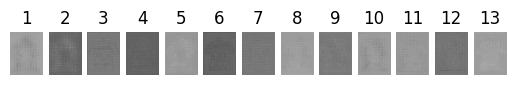

Epoch 0 | Batch 1 | GenLoss 29.755939483642578 | DiscLoss 1.3757119178771973
Epoch 0 | Batch 2 | GenLoss 27.21672821044922 | DiscLoss 1.3483898639678955
Epoch 0 | Batch 3 | GenLoss 24.727783203125 | DiscLoss 1.3303332328796387
Epoch 0 | Batch 4 | GenLoss 23.33563804626465 | DiscLoss 1.3269519805908203
Epoch 0 | Batch 5 | GenLoss 21.72295379638672 | DiscLoss 1.3246424198150635
Epoch 0 | Batch 6 | GenLoss 20.786808013916016 | DiscLoss 1.3135833740234375
Epoch 0 | Batch 7 | GenLoss 19.35536766052246 | DiscLoss 1.3007757663726807
Epoch 0 | Batch 8 | GenLoss 18.606998443603516 | DiscLoss 1.3004975318908691
Epoch 0 | Batch 9 | GenLoss 17.23120880126953 | DiscLoss 1.2687485218048096
Epoch 0 | Batch 10 | GenLoss 17.040376663208008 | DiscLoss 1.2672946453094482
Epoch 0 | Batch 11 | GenLoss 15.561121940612793 | DiscLoss 1.2471824884414673
Epoch 0 | Batch 12 | GenLoss 15.915410995483398 | DiscLoss 1.2448594570159912
Epoch 0 | Batch 13 | GenLoss 14.468487739562988 | DiscLoss 1.2211883068084717
Epo

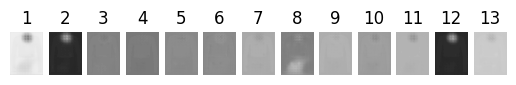

Epoch 0 | Batch 21 | GenLoss 11.1876220703125 | DiscLoss 1.073003888130188
Epoch 0 | Batch 22 | GenLoss 11.113987922668457 | DiscLoss 1.0409514904022217
Epoch 0 | Batch 23 | GenLoss 10.514265060424805 | DiscLoss 1.0280966758728027
Epoch 0 | Batch 24 | GenLoss 10.254613876342773 | DiscLoss 0.9859563112258911
Epoch 0 | Batch 25 | GenLoss 9.939054489135742 | DiscLoss 0.9644252061843872
Epoch 0 | Batch 26 | GenLoss 10.49975299835205 | DiscLoss 0.9773368239402771
Epoch 0 | Batch 27 | GenLoss 9.148184776306152 | DiscLoss 0.9212075471878052
Epoch 0 | Batch 28 | GenLoss 10.117087364196777 | DiscLoss 0.9174307584762573
Epoch 0 | Batch 29 | GenLoss 9.323477745056152 | DiscLoss 0.9175894260406494
Epoch 0 | Batch 30 | GenLoss 8.936529159545898 | DiscLoss 0.8293472528457642
Epoch 0 | Batch 31 | GenLoss 8.808612823486328 | DiscLoss 0.8300426006317139
Epoch 0 | Batch 32 | GenLoss 9.082691192626953 | DiscLoss 0.7977445721626282
Epoch 0 | Batch 33 | GenLoss 8.7710542678833 | DiscLoss 0.7544916868209839

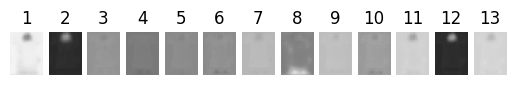

Epoch 0 | Batch 41 | GenLoss 8.26657485961914 | DiscLoss 0.503393292427063
Epoch 0 | Batch 42 | GenLoss 7.683474540710449 | DiscLoss 0.4507317543029785
Epoch 0 | Batch 43 | GenLoss 7.537775039672852 | DiscLoss 0.433438241481781
Epoch 0 | Batch 44 | GenLoss 8.77784252166748 | DiscLoss 0.41337448358535767
Epoch 0 | Batch 45 | GenLoss 7.893998146057129 | DiscLoss 0.3913945257663727
Epoch 0 | Batch 46 | GenLoss 7.220677375793457 | DiscLoss 0.33823347091674805
Epoch 0 | Batch 47 | GenLoss 7.859472274780273 | DiscLoss 0.3202793300151825
Epoch 0 | Batch 48 | GenLoss 8.843621253967285 | DiscLoss 0.33239617943763733
Epoch 0 | Batch 49 | GenLoss 8.277301788330078 | DiscLoss 0.28912386298179626
Epoch 0 | Batch 50 | GenLoss 7.8454108238220215 | DiscLoss 0.2801738977432251
Epoch 0 | Batch 51 | GenLoss 7.7213239669799805 | DiscLoss 0.252449095249176
Epoch 0 | Batch 52 | GenLoss 5.9557414054870605 | DiscLoss 0.22474482655525208
Epoch 0 | Batch 53 | GenLoss 6.272305488586426 | DiscLoss 0.2086451351642

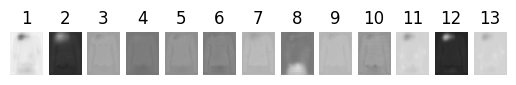

Epoch 0 | Batch 61 | GenLoss 6.2083048820495605 | DiscLoss 0.12747380137443542
Epoch 0 | Batch 62 | GenLoss 6.475068092346191 | DiscLoss 0.12567239999771118
Epoch 0 | Batch 63 | GenLoss 5.58193302154541 | DiscLoss 0.10825634002685547
Epoch 0 | Batch 64 | GenLoss 7.272171974182129 | DiscLoss 0.11120350658893585
Epoch 0 | Batch 65 | GenLoss 6.429137229919434 | DiscLoss 0.10626596212387085
Epoch 0 | Batch 66 | GenLoss 6.804077625274658 | DiscLoss 0.10237397998571396
Epoch 0 | Batch 67 | GenLoss 5.447512626647949 | DiscLoss 0.09071148931980133
Epoch 0 | Batch 68 | GenLoss 5.200901985168457 | DiscLoss 0.09432719647884369
Epoch 0 | Batch 69 | GenLoss 6.590985298156738 | DiscLoss 0.09383463859558105
Epoch 0 | Batch 70 | GenLoss 5.706655502319336 | DiscLoss 0.08219876140356064
Epoch 0 | Batch 71 | GenLoss 5.4024457931518555 | DiscLoss 0.08054008334875107
Epoch 0 | Batch 72 | GenLoss 6.083881855010986 | DiscLoss 0.07459820806980133
Epoch 0 | Batch 73 | GenLoss 5.573338508605957 | DiscLoss 0.074

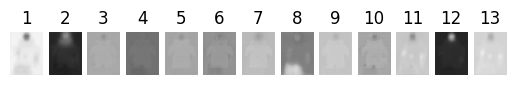

Epoch 0 | Batch 81 | GenLoss 5.177120685577393 | DiscLoss 0.053382955491542816
Epoch 0 | Batch 82 | GenLoss 4.54395866394043 | DiscLoss 0.050711315125226974
Epoch 0 | Batch 83 | GenLoss 5.790034294128418 | DiscLoss 0.05409838259220123
Epoch 0 | Batch 84 | GenLoss 5.165186882019043 | DiscLoss 0.04768446832895279
Epoch 0 | Batch 85 | GenLoss 5.200004577636719 | DiscLoss 0.04859500378370285
Epoch 0 | Batch 86 | GenLoss 5.268775939941406 | DiscLoss 0.04444729536771774
Epoch 0 | Batch 87 | GenLoss 4.998106002807617 | DiscLoss 0.05412634462118149
Epoch 0 | Batch 88 | GenLoss 4.76972770690918 | DiscLoss 0.048309557139873505
Epoch 0 | Batch 89 | GenLoss 6.034982204437256 | DiscLoss 0.0424681156873703
Epoch 0 | Batch 90 | GenLoss 4.681910991668701 | DiscLoss 0.04258743301033974
Epoch 0 | Batch 91 | GenLoss 5.285581588745117 | DiscLoss 0.05033699795603752
Epoch 0 | Batch 92 | GenLoss 6.169453144073486 | DiscLoss 0.04517209529876709
Epoch 0 | Batch 93 | GenLoss 5.902685165405273 | DiscLoss 0.0389

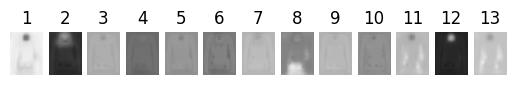

Epoch 0 | Batch 101 | GenLoss 4.726583480834961 | DiscLoss 0.046264730393886566
Epoch 0 | Batch 102 | GenLoss 4.635993003845215 | DiscLoss 0.03389344736933708
Epoch 0 | Batch 103 | GenLoss 4.975874900817871 | DiscLoss 0.031123725697398186
Epoch 0 | Batch 104 | GenLoss 5.953388214111328 | DiscLoss 0.029182791709899902
Epoch 0 | Batch 105 | GenLoss 5.477398872375488 | DiscLoss 0.04184196889400482
Epoch 0 | Batch 106 | GenLoss 4.4495463371276855 | DiscLoss 0.02933668904006481
Epoch 0 | Batch 107 | GenLoss 4.249255180358887 | DiscLoss 0.028166767209768295
Epoch 0 | Batch 108 | GenLoss 4.447256088256836 | DiscLoss 0.032448746263980865
Epoch 0 | Batch 109 | GenLoss 4.269131183624268 | DiscLoss 0.03321273252367973
Epoch 0 | Batch 110 | GenLoss 4.524487018585205 | DiscLoss 0.030436888337135315
Epoch 0 | Batch 111 | GenLoss 4.584575176239014 | DiscLoss 0.027430519461631775
Epoch 0 | Batch 112 | GenLoss 5.645627975463867 | DiscLoss 0.025065362453460693
Epoch 0 | Batch 113 | GenLoss 4.73003435134

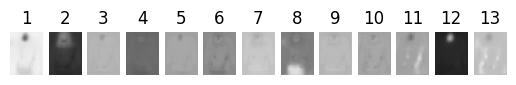

Epoch 0 | Batch 121 | GenLoss 4.942917346954346 | DiscLoss 0.023550961166620255
Epoch 0 | Batch 122 | GenLoss 4.845945358276367 | DiscLoss 0.025699064135551453
Epoch 0 | Batch 123 | GenLoss 4.172071933746338 | DiscLoss 0.021180393174290657
Epoch 0 | Batch 124 | GenLoss 3.784433603286743 | DiscLoss 0.021382847800850868
Epoch 0 | Batch 125 | GenLoss 3.773386240005493 | DiscLoss 0.019466113299131393
Epoch 0 | Batch 126 | GenLoss 3.8934240341186523 | DiscLoss 0.020069533959031105
Epoch 0 | Batch 127 | GenLoss 4.9062180519104 | DiscLoss 0.019092664122581482
Epoch 0 | Batch 128 | GenLoss 4.920122146606445 | DiscLoss 0.020805133506655693
Epoch 0 | Batch 129 | GenLoss 3.894826889038086 | DiscLoss 0.01883433200418949
Epoch 0 | Batch 130 | GenLoss 4.403191566467285 | DiscLoss 0.019001226872205734
Epoch 0 | Batch 131 | GenLoss 3.982802629470825 | DiscLoss 0.01847834885120392
Epoch 0 | Batch 132 | GenLoss 4.380624771118164 | DiscLoss 0.018183864653110504
Epoch 0 | Batch 133 | GenLoss 4.64329671859

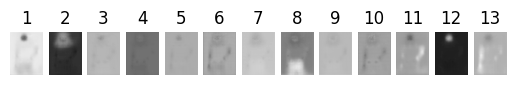

Epoch 0 | Batch 141 | GenLoss 3.361933708190918 | DiscLoss 0.016535291448235512
Epoch 0 | Batch 142 | GenLoss 3.5445852279663086 | DiscLoss 0.02020392194390297
Epoch 0 | Batch 143 | GenLoss 3.8849637508392334 | DiscLoss 0.02121800184249878
Epoch 0 | Batch 144 | GenLoss 4.163933753967285 | DiscLoss 0.016776420176029205
Epoch 0 | Batch 145 | GenLoss 4.215206623077393 | DiscLoss 0.016500510275363922
Epoch 0 | Batch 146 | GenLoss 3.757539749145508 | DiscLoss 0.016407305374741554
Epoch 0 | Batch 147 | GenLoss 3.597832679748535 | DiscLoss 0.015763740986585617
Epoch 0 | Batch 148 | GenLoss 3.7372326850891113 | DiscLoss 0.014671075157821178
Epoch 0 | Batch 149 | GenLoss 3.8862013816833496 | DiscLoss 0.015354637056589127
Epoch 0 | Batch 150 | GenLoss 3.607135772705078 | DiscLoss 0.014094846323132515
Epoch 0 | Batch 151 | GenLoss 4.209261894226074 | DiscLoss 0.01521947979927063
Epoch 0 | Batch 152 | GenLoss 3.3262417316436768 | DiscLoss 0.015237141400575638
Epoch 0 | Batch 153 | GenLoss 3.976641

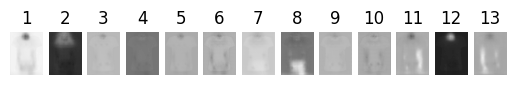

Epoch 0 | Batch 161 | GenLoss 5.545845985412598 | DiscLoss 0.012854449450969696
Epoch 0 | Batch 162 | GenLoss 3.489008903503418 | DiscLoss 0.01246560923755169
Epoch 0 | Batch 163 | GenLoss 3.643948793411255 | DiscLoss 0.011974362656474113
Epoch 0 | Batch 164 | GenLoss 3.1502437591552734 | DiscLoss 0.011190847493708134
Epoch 0 | Batch 165 | GenLoss 3.336099147796631 | DiscLoss 0.012107965536415577
Epoch 0 | Batch 166 | GenLoss 4.34516716003418 | DiscLoss 0.013410542160272598
Epoch 0 | Batch 167 | GenLoss 3.596721649169922 | DiscLoss 0.010920385830104351
Epoch 0 | Batch 168 | GenLoss 4.15732479095459 | DiscLoss 0.012541781179606915
Epoch 0 | Batch 169 | GenLoss 3.801924705505371 | DiscLoss 0.0110553577542305
Epoch 0 | Batch 170 | GenLoss 3.1722233295440674 | DiscLoss 0.011478452011942863
Epoch 0 | Batch 171 | GenLoss 4.9093337059021 | DiscLoss 0.011027252301573753
Epoch 0 | Batch 172 | GenLoss 3.973451614379883 | DiscLoss 0.011334013193845749
Epoch 0 | Batch 173 | GenLoss 3.5879878997802

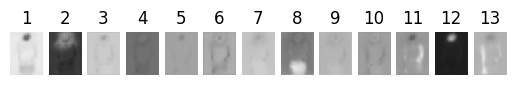

Epoch 0 | Batch 181 | GenLoss 3.3848304748535156 | DiscLoss 0.011054049246013165
Epoch 0 | Batch 182 | GenLoss 3.497178077697754 | DiscLoss 0.011130217462778091
Epoch 0 | Batch 183 | GenLoss 3.1585960388183594 | DiscLoss 0.010911581106483936
Epoch 0 | Batch 184 | GenLoss 3.2414400577545166 | DiscLoss 0.008908575400710106
Epoch 0 | Batch 185 | GenLoss 3.487692356109619 | DiscLoss 0.009867854416370392
Epoch 0 | Batch 186 | GenLoss 3.9265589714050293 | DiscLoss 0.011086221784353256
Epoch 0 | Batch 187 | GenLoss 3.655552864074707 | DiscLoss 0.010600068606436253
Epoch 0 | Batch 188 | GenLoss 3.8024520874023438 | DiscLoss 0.009729346260428429
Epoch 0 | Batch 189 | GenLoss 4.056831359863281 | DiscLoss 0.011217495426535606
Epoch 0 | Batch 190 | GenLoss 3.0411481857299805 | DiscLoss 0.010938374325633049
Epoch 0 | Batch 191 | GenLoss 2.853095531463623 | DiscLoss 0.00994444265961647
Epoch 0 | Batch 192 | GenLoss 3.4271998405456543 | DiscLoss 0.010320504195988178
Epoch 0 | Batch 193 | GenLoss 3.87

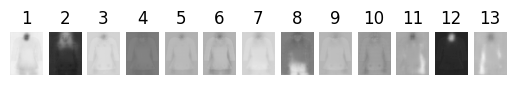

Epoch 0 | Batch 201 | GenLoss 2.679013967514038 | DiscLoss 0.008472753688693047
Epoch 0 | Batch 202 | GenLoss 3.4570775032043457 | DiscLoss 0.009873203933238983
Epoch 0 | Batch 203 | GenLoss 2.6315414905548096 | DiscLoss 0.008523081429302692
Epoch 0 | Batch 204 | GenLoss 3.2177865505218506 | DiscLoss 0.0090480362996459
Epoch 0 | Batch 205 | GenLoss 3.2392983436584473 | DiscLoss 0.008807506412267685
Epoch 0 | Batch 206 | GenLoss 2.7038426399230957 | DiscLoss 0.008323912508785725
Epoch 0 | Batch 207 | GenLoss 3.764023780822754 | DiscLoss 0.007856925949454308
Epoch 0 | Batch 208 | GenLoss 2.973281145095825 | DiscLoss 0.007955048233270645
Epoch 0 | Batch 209 | GenLoss 2.7056047916412354 | DiscLoss 0.008343981578946114
Epoch 0 | Batch 210 | GenLoss 2.9194493293762207 | DiscLoss 0.007835086435079575
Epoch 0 | Batch 211 | GenLoss 3.6335153579711914 | DiscLoss 0.00939183495938778
Epoch 0 | Batch 212 | GenLoss 3.567866802215576 | DiscLoss 0.00780649296939373
Epoch 0 | Batch 213 | GenLoss 3.5189

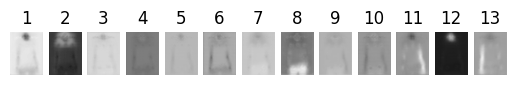

Epoch 0 | Batch 221 | GenLoss 2.462552785873413 | DiscLoss 0.006781292147934437
Epoch 0 | Batch 222 | GenLoss 2.8242416381835938 | DiscLoss 0.0072740595787763596
Epoch 0 | Batch 223 | GenLoss 3.297679901123047 | DiscLoss 0.007474101614207029
Epoch 0 | Batch 224 | GenLoss 3.4743783473968506 | DiscLoss 0.00732981413602829
Epoch 0 | Batch 225 | GenLoss 4.005040645599365 | DiscLoss 0.007069891784340143
Epoch 0 | Batch 226 | GenLoss 2.8741416931152344 | DiscLoss 0.00698460079729557
Epoch 0 | Batch 227 | GenLoss 3.172165870666504 | DiscLoss 0.00763752032071352
Epoch 0 | Batch 228 | GenLoss 3.1765079498291016 | DiscLoss 0.007122199982404709
Epoch 0 | Batch 229 | GenLoss 2.8669049739837646 | DiscLoss 0.0064779650419950485
Epoch 0 | Batch 230 | GenLoss 3.1365084648132324 | DiscLoss 0.006770957726985216
Epoch 0 | Batch 231 | GenLoss 3.3007683753967285 | DiscLoss 0.0069360025227069855
Epoch 0 | Batch 232 | GenLoss 3.2372426986694336 | DiscLoss 0.006631639786064625
Epoch 0 | Batch 233 | GenLoss 2.

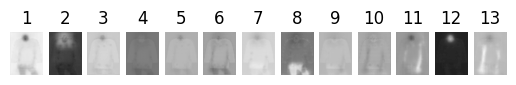

Epoch 0 | Batch 241 | GenLoss 3.1212522983551025 | DiscLoss 0.005843838211148977
Epoch 0 | Batch 242 | GenLoss 2.8954386711120605 | DiscLoss 0.0060895816422998905
Epoch 0 | Batch 243 | GenLoss 2.74841570854187 | DiscLoss 0.005966596771031618
Epoch 0 | Batch 244 | GenLoss 3.2465646266937256 | DiscLoss 0.0064955344423651695
Epoch 0 | Batch 245 | GenLoss 2.6917123794555664 | DiscLoss 0.006427121348679066
Epoch 0 | Batch 246 | GenLoss 2.1217243671417236 | DiscLoss 0.005659870337694883
Epoch 0 | Batch 247 | GenLoss 3.6156139373779297 | DiscLoss 0.005653096828609705
Epoch 0 | Batch 248 | GenLoss 3.2598471641540527 | DiscLoss 0.005984951741993427
Epoch 0 | Batch 249 | GenLoss 3.4173343181610107 | DiscLoss 0.005837815348058939
Epoch 0 | Batch 250 | GenLoss 3.4488277435302734 | DiscLoss 0.006614300422370434
Epoch 0 | Batch 251 | GenLoss 2.9891204833984375 | DiscLoss 0.0061866519972682
Epoch 0 | Batch 252 | GenLoss 2.503584384918213 | DiscLoss 0.005675929598510265
Epoch 0 | Batch 253 | GenLoss 2

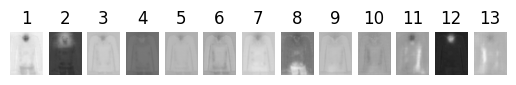

Epoch 0 | Batch 261 | GenLoss 2.8770315647125244 | DiscLoss 0.006447983905673027
Epoch 0 | Batch 262 | GenLoss 3.7954063415527344 | DiscLoss 0.006662559695541859
Epoch 0 | Batch 263 | GenLoss 3.4132132530212402 | DiscLoss 0.005949249491095543
Epoch 0 | Batch 264 | GenLoss 3.2489066123962402 | DiscLoss 0.005479398183524609
Epoch 0 | Batch 265 | GenLoss 2.500821352005005 | DiscLoss 0.005748621188104153
Epoch 0 | Batch 266 | GenLoss 2.1336007118225098 | DiscLoss 0.005617552436888218
Epoch 0 | Batch 267 | GenLoss 2.497671604156494 | DiscLoss 0.005589120090007782
Epoch 0 | Batch 268 | GenLoss 2.2825119495391846 | DiscLoss 0.006051952019333839
Epoch 0 | Batch 269 | GenLoss 2.611363172531128 | DiscLoss 0.005651132203638554
Epoch 0 | Batch 270 | GenLoss 2.795013904571533 | DiscLoss 0.005328540690243244
Epoch 0 | Batch 271 | GenLoss 3.2537147998809814 | DiscLoss 0.00631885789334774
Epoch 0 | Batch 272 | GenLoss 2.5782716274261475 | DiscLoss 0.0058224196545779705
Epoch 0 | Batch 273 | GenLoss 2.

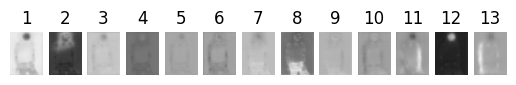

Epoch 0 | Batch 281 | GenLoss 2.699730396270752 | DiscLoss 0.005068202503025532
Epoch 0 | Batch 282 | GenLoss 3.2569174766540527 | DiscLoss 0.005448783747851849
Epoch 0 | Batch 283 | GenLoss 2.914547920227051 | DiscLoss 0.005069623701274395
Epoch 0 | Batch 284 | GenLoss 2.1719202995300293 | DiscLoss 0.004522968083620071
Epoch 0 | Batch 285 | GenLoss 2.743164300918579 | DiscLoss 0.004868722520768642
Epoch 0 | Batch 286 | GenLoss 2.4501566886901855 | DiscLoss 0.004535543732345104
Epoch 0 | Batch 287 | GenLoss 2.398864507675171 | DiscLoss 0.005918343551456928
Epoch 0 | Batch 288 | GenLoss 2.94520902633667 | DiscLoss 0.005116110667586327
Epoch 0 | Batch 289 | GenLoss 2.880509376525879 | DiscLoss 0.0044852085411548615
Epoch 0 | Batch 290 | GenLoss 2.823281764984131 | DiscLoss 0.004857820924371481
Epoch 0 | Batch 291 | GenLoss 2.711045265197754 | DiscLoss 0.004919787868857384
Epoch 0 | Batch 292 | GenLoss 3.1225955486297607 | DiscLoss 0.004877141676843166
Epoch 0 | Batch 293 | GenLoss 3.1798

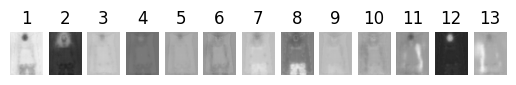

Epoch 0 | Batch 301 | GenLoss 2.8592464923858643 | DiscLoss 0.004584961570799351
Epoch 0 | Batch 302 | GenLoss 2.632241725921631 | DiscLoss 0.005372626706957817
Epoch 0 | Batch 303 | GenLoss 1.9074547290802002 | DiscLoss 0.003895521629601717
Epoch 0 | Batch 304 | GenLoss 2.751481533050537 | DiscLoss 0.004873333498835564
Epoch 0 | Batch 305 | GenLoss 2.1301188468933105 | DiscLoss 0.00414476590231061
Epoch 0 | Batch 306 | GenLoss 2.460958957672119 | DiscLoss 0.004145491868257523
Epoch 0 | Batch 307 | GenLoss 2.3807694911956787 | DiscLoss 0.004506843630224466
Epoch 0 | Batch 308 | GenLoss 2.469210147857666 | DiscLoss 0.004343500826507807
Epoch 0 | Batch 309 | GenLoss 1.8302440643310547 | DiscLoss 0.0038880030624568462
Epoch 0 | Batch 310 | GenLoss 3.1259987354278564 | DiscLoss 0.004819810856133699
Epoch 0 | Batch 311 | GenLoss 2.1971631050109863 | DiscLoss 0.00430627167224884
Epoch 0 | Batch 312 | GenLoss 2.347085952758789 | DiscLoss 0.004122625105082989
Epoch 0 | Batch 313 | GenLoss 2.63

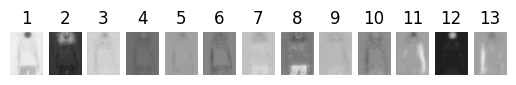

Epoch 0 | Batch 321 | GenLoss 2.5248208045959473 | DiscLoss 0.0039019559044390917
Epoch 0 | Batch 322 | GenLoss 2.214813232421875 | DiscLoss 0.0038264496251940727
Epoch 0 | Batch 323 | GenLoss 2.6684317588806152 | DiscLoss 0.0038168178871273994
Epoch 0 | Batch 324 | GenLoss 3.1627750396728516 | DiscLoss 0.004721587058156729
Epoch 0 | Batch 325 | GenLoss 2.0512406826019287 | DiscLoss 0.0036880720872431993
Epoch 0 | Batch 326 | GenLoss 2.725883722305298 | DiscLoss 0.004318820778280497
Epoch 0 | Batch 327 | GenLoss 2.9262447357177734 | DiscLoss 0.004658151417970657
Epoch 0 | Batch 328 | GenLoss 2.2726595401763916 | DiscLoss 0.0035606827586889267
Epoch 0 | Batch 329 | GenLoss 2.3441476821899414 | DiscLoss 0.0056691886857151985
Epoch 0 | Batch 330 | GenLoss 2.7311620712280273 | DiscLoss 0.0037868465296924114
Epoch 0 | Batch 331 | GenLoss 2.30252742767334 | DiscLoss 0.003904007375240326
Epoch 0 | Batch 332 | GenLoss 3.4079134464263916 | DiscLoss 0.004023685585707426
Epoch 0 | Batch 333 | Gen

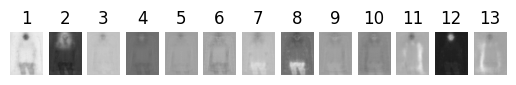

Epoch 0 | Batch 341 | GenLoss 2.308988332748413 | DiscLoss 0.0035051354207098484
Epoch 0 | Batch 342 | GenLoss 2.585042715072632 | DiscLoss 0.0032793711870908737
Epoch 0 | Batch 343 | GenLoss 1.962085247039795 | DiscLoss 0.003173175500705838
Epoch 0 | Batch 344 | GenLoss 3.0086097717285156 | DiscLoss 0.003149186260998249
Epoch 0 | Batch 345 | GenLoss 2.317866325378418 | DiscLoss 0.0033653900027275085
Epoch 0 | Batch 346 | GenLoss 2.645998954772949 | DiscLoss 0.0036772298626601696
Epoch 0 | Batch 347 | GenLoss 2.373753547668457 | DiscLoss 0.003325988072901964
Epoch 0 | Batch 348 | GenLoss 2.1406431198120117 | DiscLoss 0.003399321809411049
Epoch 0 | Batch 349 | GenLoss 2.717679977416992 | DiscLoss 0.0036112910602241755
Epoch 0 | Batch 350 | GenLoss 3.138735294342041 | DiscLoss 0.0036991124507039785
Epoch 0 | Batch 351 | GenLoss 2.527515411376953 | DiscLoss 0.0032835761085152626
Epoch 0 | Batch 352 | GenLoss 2.1951398849487305 | DiscLoss 0.0033551957458257675
Epoch 0 | Batch 353 | GenLoss

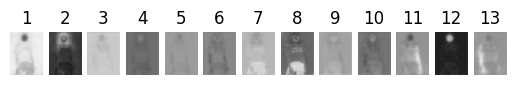

Epoch 0 | Batch 361 | GenLoss 2.01259708404541 | DiscLoss 0.003426786046475172
Epoch 0 | Batch 362 | GenLoss 2.155728578567505 | DiscLoss 0.0033471493516117334
Epoch 0 | Batch 363 | GenLoss 2.2906153202056885 | DiscLoss 0.003297970164567232
Epoch 0 | Batch 364 | GenLoss 2.0168700218200684 | DiscLoss 0.00310135749168694
Epoch 0 | Batch 365 | GenLoss 2.6337435245513916 | DiscLoss 0.0031276834197342396
Epoch 0 | Batch 366 | GenLoss 2.8598275184631348 | DiscLoss 0.0033213752321898937
Epoch 0 | Batch 367 | GenLoss 2.621657609939575 | DiscLoss 0.0031137405894696712
Epoch 0 | Batch 368 | GenLoss 2.1796553134918213 | DiscLoss 0.003057926893234253
Epoch 0 | Batch 369 | GenLoss 3.045281171798706 | DiscLoss 0.0030864612199366093
Epoch 0 | Batch 370 | GenLoss 2.1583502292633057 | DiscLoss 0.0031986646354198456
Epoch 0 | Batch 371 | GenLoss 2.7585482597351074 | DiscLoss 0.004934434313327074
Epoch 0 | Batch 372 | GenLoss 2.7130956649780273 | DiscLoss 0.0036396468058228493
Epoch 0 | Batch 373 | GenLo

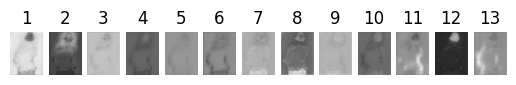

Epoch 0 | Batch 381 | GenLoss 1.7670648097991943 | DiscLoss 0.0028792177326977253
Epoch 0 | Batch 382 | GenLoss 2.569009780883789 | DiscLoss 0.00316203897818923
Epoch 0 | Batch 383 | GenLoss 1.6017264127731323 | DiscLoss 0.0028165546245872974
Epoch 0 | Batch 384 | GenLoss 2.4598023891448975 | DiscLoss 0.003641079878434539
Epoch 0 | Batch 385 | GenLoss 2.323856830596924 | DiscLoss 0.0031392802484333515
Epoch 0 | Batch 386 | GenLoss 3.2445068359375 | DiscLoss 0.003246612846851349
Epoch 0 | Batch 387 | GenLoss 2.1765732765197754 | DiscLoss 0.002832109574228525
Epoch 0 | Batch 388 | GenLoss 1.9914530515670776 | DiscLoss 0.0026177531108260155
Epoch 0 | Batch 389 | GenLoss 2.410499095916748 | DiscLoss 0.003235891927033663
Epoch 0 | Batch 390 | GenLoss 2.358686923980713 | DiscLoss 0.002850077347829938
Epoch 0 | Batch 391 | GenLoss 2.0558760166168213 | DiscLoss 0.0030128711368888617
Epoch 0 | Batch 392 | GenLoss 2.3020694255828857 | DiscLoss 0.0032692698296159506
Epoch 0 | Batch 393 | GenLoss 

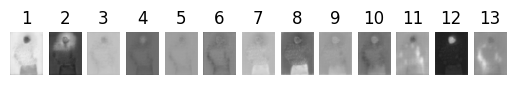

Epoch 0 | Batch 401 | GenLoss 2.20670223236084 | DiscLoss 0.002878833096474409
Epoch 0 | Batch 402 | GenLoss 2.1769773960113525 | DiscLoss 0.0028122675139456987
Epoch 0 | Batch 403 | GenLoss 2.3779337406158447 | DiscLoss 0.003149597905576229
Epoch 0 | Batch 404 | GenLoss 1.903137445449829 | DiscLoss 0.0023934179916977882
Epoch 0 | Batch 405 | GenLoss 1.7278788089752197 | DiscLoss 0.002669610781595111
Epoch 0 | Batch 406 | GenLoss 1.9872748851776123 | DiscLoss 0.0025975010357797146
Epoch 0 | Batch 407 | GenLoss 1.8977527618408203 | DiscLoss 0.0022598684299737215
Epoch 0 | Batch 408 | GenLoss 2.101658582687378 | DiscLoss 0.0025606919080018997
Epoch 0 | Batch 409 | GenLoss 3.0358550548553467 | DiscLoss 0.0027661025524139404
Epoch 0 | Batch 410 | GenLoss 2.6318559646606445 | DiscLoss 0.002618537750095129
Epoch 0 | Batch 411 | GenLoss 2.4058640003204346 | DiscLoss 0.0023398716002702713
Epoch 0 | Batch 412 | GenLoss 2.556241512298584 | DiscLoss 0.0028359086718410254
Epoch 0 | Batch 413 | Gen

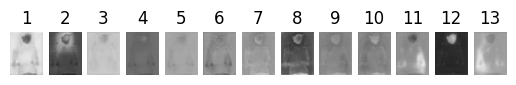

Epoch 0 | Batch 421 | GenLoss 2.3190507888793945 | DiscLoss 0.002279475564137101
Epoch 0 | Batch 422 | GenLoss 2.0776383876800537 | DiscLoss 0.0023367104586213827
Epoch 0 | Batch 423 | GenLoss 2.2290003299713135 | DiscLoss 0.0028136195614933968
Epoch 0 | Batch 424 | GenLoss 2.0197606086730957 | DiscLoss 0.0026579429395496845
Epoch 0 | Batch 425 | GenLoss 2.1939454078674316 | DiscLoss 0.0025110284332185984
Epoch 0 | Batch 426 | GenLoss 2.3233139514923096 | DiscLoss 0.002344811800867319
Epoch 0 | Batch 427 | GenLoss 2.1530203819274902 | DiscLoss 0.002333460608497262
Epoch 0 | Batch 428 | GenLoss 1.9896290302276611 | DiscLoss 0.002147739753127098
Epoch 0 | Batch 429 | GenLoss 2.864718437194824 | DiscLoss 0.002537163905799389
Epoch 0 | Batch 430 | GenLoss 2.0003137588500977 | DiscLoss 0.0025312211364507675
Epoch 0 | Batch 431 | GenLoss 2.3363702297210693 | DiscLoss 0.003014084417372942
Epoch 0 | Batch 432 | GenLoss 2.271698474884033 | DiscLoss 0.002537134336307645
Epoch 0 | Batch 433 | Gen

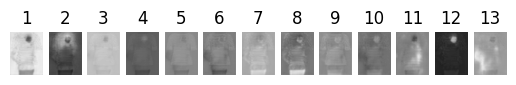

Epoch 0 | Batch 441 | GenLoss 2.905585527420044 | DiscLoss 0.0024492298252880573
Epoch 0 | Batch 442 | GenLoss 1.8426625728607178 | DiscLoss 0.0023793093860149384
Epoch 0 | Batch 443 | GenLoss 2.613842010498047 | DiscLoss 0.002412382047623396
Epoch 0 | Batch 444 | GenLoss 2.016921043395996 | DiscLoss 0.0020898720249533653
Epoch 0 | Batch 445 | GenLoss 2.870777130126953 | DiscLoss 0.002261110581457615
Epoch 0 | Batch 446 | GenLoss 2.654573678970337 | DiscLoss 0.0020124437287449837
Epoch 0 | Batch 447 | GenLoss 2.0873825550079346 | DiscLoss 0.0020990888588130474
Epoch 0 | Batch 448 | GenLoss 1.7880842685699463 | DiscLoss 0.00208285148255527
Epoch 0 | Batch 449 | GenLoss 2.814359188079834 | DiscLoss 0.002187799895182252
Epoch 0 | Batch 450 | GenLoss 1.713804006576538 | DiscLoss 0.0022023555357009172
Epoch 0 | Batch 451 | GenLoss 2.8086912631988525 | DiscLoss 0.00248588714748621
Epoch 0 | Batch 452 | GenLoss 1.5836968421936035 | DiscLoss 0.0023024524562060833
Epoch 0 | Batch 453 | GenLoss 

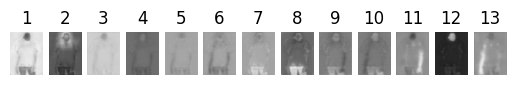

Epoch 0 | Batch 461 | GenLoss 2.064732074737549 | DiscLoss 0.0023714390117675066
Epoch 0 | Batch 462 | GenLoss 2.1904687881469727 | DiscLoss 0.0022886316291987896
Epoch 0 | Batch 463 | GenLoss 1.960110068321228 | DiscLoss 0.0020424274262040854
Epoch 0 | Batch 464 | GenLoss 2.506459951400757 | DiscLoss 0.002035804558545351
Epoch 0 | Batch 465 | GenLoss 1.8273375034332275 | DiscLoss 0.002317541278898716
Epoch 0 | Batch 466 | GenLoss 2.1494321823120117 | DiscLoss 0.0024675996974110603
Epoch 0 | Batch 467 | GenLoss 1.8858609199523926 | DiscLoss 0.002283355686813593
Epoch 0 | Batch 468 | GenLoss 2.449357271194458 | DiscLoss 0.0020097990054637194
Epoch 0 | Batch 469 | GenLoss 2.4046854972839355 | DiscLoss 0.0024918504059314728
Epoch 0 | Batch 470 | GenLoss 2.3900692462921143 | DiscLoss 0.0020262571051716805
Epoch 0 | Batch 471 | GenLoss 2.6517791748046875 | DiscLoss 0.002129211090505123
Epoch 0 | Batch 472 | GenLoss 2.4625346660614014 | DiscLoss 0.002115060808137059
Epoch 0 | Batch 473 | Gen

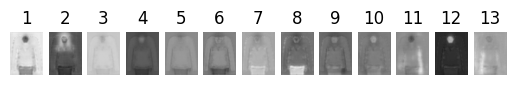

Epoch 0 | Batch 481 | GenLoss 1.994870901107788 | DiscLoss 0.0019927246030420065
Epoch 0 | Batch 482 | GenLoss 1.917724847793579 | DiscLoss 0.0020076544024050236
Epoch 0 | Batch 483 | GenLoss 2.0070157051086426 | DiscLoss 0.0021456091199070215
Epoch 0 | Batch 484 | GenLoss 1.9054744243621826 | DiscLoss 0.0021763164550065994
Epoch 0 | Batch 485 | GenLoss 1.8477611541748047 | DiscLoss 0.001998713705688715
Epoch 0 | Batch 486 | GenLoss 1.8853646516799927 | DiscLoss 0.002178297843784094
Epoch 0 | Batch 487 | GenLoss 2.876929759979248 | DiscLoss 0.002270244061946869
Epoch 0 | Batch 488 | GenLoss 1.8257211446762085 | DiscLoss 0.002105926163494587
Epoch 0 | Batch 489 | GenLoss 2.9161481857299805 | DiscLoss 0.0022115707397460938
Epoch 0 | Batch 490 | GenLoss 2.2947356700897217 | DiscLoss 0.002380786696448922
Epoch 0 | Batch 491 | GenLoss 2.2320024967193604 | DiscLoss 0.0019309154013171792
Epoch 0 | Batch 492 | GenLoss 2.6352076530456543 | DiscLoss 0.0026217354461550713
Epoch 0 | Batch 493 | Ge

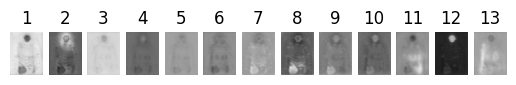

Epoch 0 | Batch 501 | GenLoss 2.6010546684265137 | DiscLoss 0.0019015450961887836
Epoch 0 | Batch 502 | GenLoss 1.9005582332611084 | DiscLoss 0.002069910755380988
Epoch 0 | Batch 503 | GenLoss 1.93208909034729 | DiscLoss 0.0018141742330044508
Epoch 0 | Batch 504 | GenLoss 1.55539870262146 | DiscLoss 0.001684931106865406
Epoch 0 | Batch 505 | GenLoss 2.183077335357666 | DiscLoss 0.001719509600661695
Epoch 0 | Batch 506 | GenLoss 2.544867515563965 | DiscLoss 0.001635435619391501
Epoch 0 | Batch 507 | GenLoss 1.930517554283142 | DiscLoss 0.001986210700124502
Epoch 0 | Batch 508 | GenLoss 2.4128201007843018 | DiscLoss 0.0018398795509710908
Epoch 0 | Batch 509 | GenLoss 2.0704469680786133 | DiscLoss 0.0018627522513270378
Epoch 0 | Batch 510 | GenLoss 2.3774330615997314 | DiscLoss 0.001956090796738863
Epoch 0 | Batch 511 | GenLoss 2.136763095855713 | DiscLoss 0.001689320313744247
Epoch 0 | Batch 512 | GenLoss 1.5657868385314941 | DiscLoss 0.0016542751109227538
Epoch 0 | Batch 513 | GenLoss 1

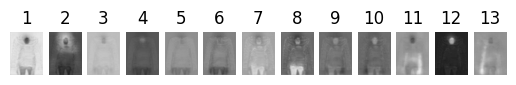

Epoch 0 | Batch 521 | GenLoss 2.5334997177124023 | DiscLoss 0.0017250231467187405
Epoch 0 | Batch 522 | GenLoss 2.456782341003418 | DiscLoss 0.0020824638195335865
Epoch 0 | Batch 523 | GenLoss 1.667984962463379 | DiscLoss 0.0015496977139264345
Epoch 0 | Batch 524 | GenLoss 2.4756784439086914 | DiscLoss 0.0016974613536149263
Epoch 0 | Batch 525 | GenLoss 2.187856912612915 | DiscLoss 0.001662780181504786
Epoch 0 | Batch 526 | GenLoss 1.3548558950424194 | DiscLoss 0.0015474690590053797
Epoch 0 | Batch 527 | GenLoss 1.5585649013519287 | DiscLoss 0.0016277102986350656
Epoch 0 | Batch 528 | GenLoss 2.0806634426116943 | DiscLoss 0.0017135421512648463
Epoch 0 | Batch 529 | GenLoss 2.5388593673706055 | DiscLoss 0.0020178034901618958
Epoch 0 | Batch 530 | GenLoss 1.8976527452468872 | DiscLoss 0.0017659500008448958
Epoch 0 | Batch 531 | GenLoss 2.3303489685058594 | DiscLoss 0.0016976292245090008
Epoch 0 | Batch 532 | GenLoss 1.5855143070220947 | DiscLoss 0.0016553935129195452
Epoch 0 | Batch 533 

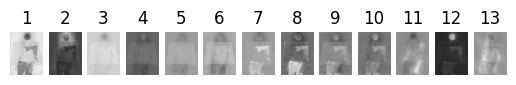

Epoch 0 | Batch 541 | GenLoss 2.0876524448394775 | DiscLoss 0.0015877254772931337
Epoch 0 | Batch 542 | GenLoss 1.9513206481933594 | DiscLoss 0.0016368984943255782
Epoch 0 | Batch 543 | GenLoss 2.489612102508545 | DiscLoss 0.0015681229997426271
Epoch 0 | Batch 544 | GenLoss 1.9170057773590088 | DiscLoss 0.0015435547102242708
Epoch 0 | Batch 545 | GenLoss 1.8423168659210205 | DiscLoss 0.0015052373055368662
Epoch 0 | Batch 546 | GenLoss 1.4754903316497803 | DiscLoss 0.0014417837373912334
Epoch 0 | Batch 547 | GenLoss 2.0603432655334473 | DiscLoss 0.001477674813941121
Epoch 0 | Batch 548 | GenLoss 1.6094695329666138 | DiscLoss 0.0015763600822538137
Epoch 0 | Batch 549 | GenLoss 1.8754541873931885 | DiscLoss 0.001539248856715858
Epoch 0 | Batch 550 | GenLoss 1.9074558019638062 | DiscLoss 0.0014258550945669413
Epoch 0 | Batch 551 | GenLoss 1.946399211883545 | DiscLoss 0.0017611650982871652
Epoch 0 | Batch 552 | GenLoss 2.179703950881958 | DiscLoss 0.0018060028087347746
Epoch 0 | Batch 553 |

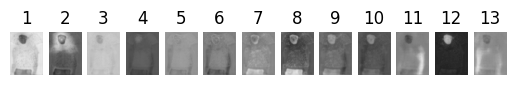

Epoch 0 | Batch 561 | GenLoss 1.737383484840393 | DiscLoss 0.0014637436252087355
Epoch 0 | Batch 562 | GenLoss 2.1819000244140625 | DiscLoss 0.0015258712228387594
Epoch 0 | Batch 563 | GenLoss 1.510021686553955 | DiscLoss 0.001371023477986455
Epoch 0 | Batch 564 | GenLoss 1.8034605979919434 | DiscLoss 0.0016905941301956773
Epoch 0 | Batch 565 | GenLoss 1.5005748271942139 | DiscLoss 0.0014627157943323255
Epoch 0 | Batch 566 | GenLoss 1.2728395462036133 | DiscLoss 0.0015749263111501932
Epoch 0 | Batch 567 | GenLoss 1.693276047706604 | DiscLoss 0.0014053115155547857
Epoch 0 | Batch 568 | GenLoss 2.4299185276031494 | DiscLoss 0.0015128725208342075
Epoch 0 | Batch 569 | GenLoss 1.7074381113052368 | DiscLoss 0.0014788979897275567
Epoch 0 | Batch 570 | GenLoss 2.454190731048584 | DiscLoss 0.0013801748864352703
Epoch 0 | Batch 571 | GenLoss 2.2504682540893555 | DiscLoss 0.0015724280383437872
Epoch 0 | Batch 572 | GenLoss 3.237076759338379 | DiscLoss 0.0015031485818326473
Epoch 0 | Batch 573 | 

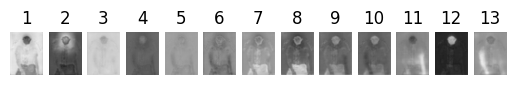

Epoch 0 | Batch 581 | GenLoss 1.6529959440231323 | DiscLoss 0.0016766819171607494
Epoch 0 | Batch 582 | GenLoss 1.801107406616211 | DiscLoss 0.0013944485690444708
Epoch 0 | Batch 583 | GenLoss 1.9914525747299194 | DiscLoss 0.0015392964705824852
Epoch 0 | Batch 584 | GenLoss 1.628749132156372 | DiscLoss 0.0015358456876128912
Epoch 0 | Batch 585 | GenLoss 2.1216466426849365 | DiscLoss 0.0013634496135637164
Epoch 0 | Batch 586 | GenLoss 1.409509301185608 | DiscLoss 0.001474955235607922
Epoch 0 | Batch 587 | GenLoss 2.3123586177825928 | DiscLoss 0.001503796549513936
Epoch 0 | Batch 588 | GenLoss 1.7406115531921387 | DiscLoss 0.001695804065093398
Epoch 0 | Batch 589 | GenLoss 1.8693047761917114 | DiscLoss 0.0015518986620008945
Epoch 0 | Batch 590 | GenLoss 1.9679391384124756 | DiscLoss 0.0014928624732419848
Epoch 0 | Batch 591 | GenLoss 1.6837189197540283 | DiscLoss 0.0014189009089022875
Epoch 0 | Batch 592 | GenLoss 1.580458641052246 | DiscLoss 0.0013970864238217473
Epoch 0 | Batch 593 | G

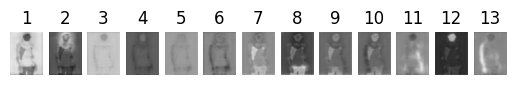

Epoch 0 | Batch 601 | GenLoss 2.2485172748565674 | DiscLoss 0.0020646005868911743
Epoch 0 | Batch 602 | GenLoss 1.8960034847259521 | DiscLoss 0.001296898117288947
Epoch 0 | Batch 603 | GenLoss 1.7075726985931396 | DiscLoss 0.0015343395061790943
Epoch 0 | Batch 604 | GenLoss 1.7920202016830444 | DiscLoss 0.0012912324164062738
Epoch 0 | Batch 605 | GenLoss 1.7558887004852295 | DiscLoss 0.001338319038040936
Epoch 0 | Batch 606 | GenLoss 1.5397471189498901 | DiscLoss 0.001274009351618588
Epoch 0 | Batch 607 | GenLoss 1.67173171043396 | DiscLoss 0.0013976171612739563
Epoch 0 | Batch 608 | GenLoss 2.277472972869873 | DiscLoss 0.0014850425068289042
Epoch 0 | Batch 609 | GenLoss 1.4817841053009033 | DiscLoss 0.001164143206551671
Epoch 0 | Batch 610 | GenLoss 1.924398422241211 | DiscLoss 0.0013762949965894222
Epoch 0 | Batch 611 | GenLoss 2.328251600265503 | DiscLoss 0.0013968783896416426
Epoch 0 | Batch 612 | GenLoss 2.0679304599761963 | DiscLoss 0.001226011198014021
Epoch 0 | Batch 613 | GenL

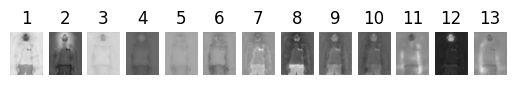

Epoch 0 | Batch 621 | GenLoss 2.0326225757598877 | DiscLoss 0.0013177321525290608
Epoch 0 | Batch 622 | GenLoss 2.619396448135376 | DiscLoss 0.0012862901203334332
Epoch 0 | Batch 623 | GenLoss 1.9232761859893799 | DiscLoss 0.0013026464730501175
Epoch 0 | Batch 624 | GenLoss 1.7514610290527344 | DiscLoss 0.0012429930502548814
Epoch 0 | Batch 625 | GenLoss 1.4706158638000488 | DiscLoss 0.0012292303144931793
Epoch 0 | Batch 626 | GenLoss 2.2236406803131104 | DiscLoss 0.0013031780254095793
Epoch 0 | Batch 627 | GenLoss 1.702142357826233 | DiscLoss 0.0013142856769263744
Epoch 0 | Batch 628 | GenLoss 2.110672950744629 | DiscLoss 0.0012414248194545507
Epoch 0 | Batch 629 | GenLoss 1.8884670734405518 | DiscLoss 0.0013055523158982396
Epoch 0 | Batch 630 | GenLoss 1.8391368389129639 | DiscLoss 0.001193186268210411
Epoch 0 | Batch 631 | GenLoss 2.187727451324463 | DiscLoss 0.0013162384275346994
Epoch 0 | Batch 632 | GenLoss 1.6170954704284668 | DiscLoss 0.0012391440104693174
Epoch 0 | Batch 633 |

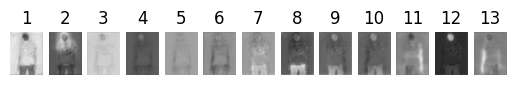

Epoch 0 | Batch 641 | GenLoss 1.64291250705719 | DiscLoss 0.0013327491469681263
Epoch 0 | Batch 642 | GenLoss 2.034428596496582 | DiscLoss 0.0011965471785515547
Epoch 0 | Batch 643 | GenLoss 1.8464045524597168 | DiscLoss 0.0012299746740609407
Epoch 0 | Batch 644 | GenLoss 1.9870542287826538 | DiscLoss 0.0012499094009399414
Epoch 0 | Batch 645 | GenLoss 1.7973250150680542 | DiscLoss 0.0011354945600032806
Epoch 0 | Batch 646 | GenLoss 2.5807137489318848 | DiscLoss 0.0012440248392522335
Epoch 0 | Batch 647 | GenLoss 2.150594711303711 | DiscLoss 0.0011055341456085443
Epoch 0 | Batch 648 | GenLoss 1.772310495376587 | DiscLoss 0.001191341900266707
Epoch 0 | Batch 649 | GenLoss 1.5697755813598633 | DiscLoss 0.00107477605342865
Epoch 0 | Batch 650 | GenLoss 1.6569736003875732 | DiscLoss 0.0010975961340591311
Epoch 0 | Batch 651 | GenLoss 1.692880630493164 | DiscLoss 0.0012936322018504143
Epoch 0 | Batch 652 | GenLoss 1.8330237865447998 | DiscLoss 0.0013260205741971731
Epoch 0 | Batch 653 | Gen

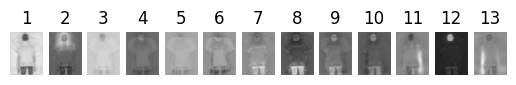

Epoch 0 | Batch 661 | GenLoss 1.671851634979248 | DiscLoss 0.0012426088796928525
Epoch 0 | Batch 662 | GenLoss 2.000781774520874 | DiscLoss 0.001285355188883841
Epoch 0 | Batch 663 | GenLoss 2.0098063945770264 | DiscLoss 0.0011696107685565948
Epoch 0 | Batch 664 | GenLoss 1.7857807874679565 | DiscLoss 0.0011645653285086155
Epoch 0 | Batch 665 | GenLoss 1.8166868686676025 | DiscLoss 0.0014160210266709328
Epoch 0 | Batch 666 | GenLoss 1.5662235021591187 | DiscLoss 0.0011372491717338562
Epoch 0 | Batch 667 | GenLoss 2.180929660797119 | DiscLoss 0.0012936246348544955
Epoch 0 | Batch 668 | GenLoss 2.0117878913879395 | DiscLoss 0.0011974446242675185
Epoch 0 | Batch 669 | GenLoss 1.8603084087371826 | DiscLoss 0.0012412765063345432
Epoch 0 | Batch 670 | GenLoss 1.9682397842407227 | DiscLoss 0.0011752285063266754
Epoch 0 | Batch 671 | GenLoss 2.1174685955047607 | DiscLoss 0.001092787366360426
Epoch 0 | Batch 672 | GenLoss 1.9627056121826172 | DiscLoss 0.0016251589404419065
Epoch 0 | Batch 673 |

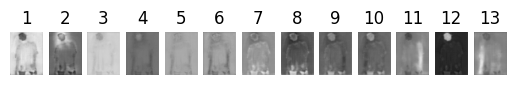

Epoch 0 | Batch 681 | GenLoss 1.6863141059875488 | DiscLoss 0.0011592904338613153
Epoch 0 | Batch 682 | GenLoss 2.033804416656494 | DiscLoss 0.0011960349511355162
Epoch 0 | Batch 683 | GenLoss 1.3982468843460083 | DiscLoss 0.000989951891824603
Epoch 0 | Batch 684 | GenLoss 1.4503413438796997 | DiscLoss 0.001115681603550911
Epoch 0 | Batch 685 | GenLoss 1.705867052078247 | DiscLoss 0.001119458582252264
Epoch 0 | Batch 686 | GenLoss 2.1228370666503906 | DiscLoss 0.0012509827502071857
Epoch 0 | Batch 687 | GenLoss 1.3359445333480835 | DiscLoss 0.0011422336101531982
Epoch 0 | Batch 688 | GenLoss 2.630575656890869 | DiscLoss 0.0012687116395682096
Epoch 0 | Batch 689 | GenLoss 1.7443797588348389 | DiscLoss 0.0013076234608888626
Epoch 0 | Batch 690 | GenLoss 2.227421998977661 | DiscLoss 0.0012160749174654484
Epoch 0 | Batch 691 | GenLoss 1.7056529521942139 | DiscLoss 0.0012577979359775782
Epoch 0 | Batch 692 | GenLoss 1.6844878196716309 | DiscLoss 0.0013085691025480628
Epoch 0 | Batch 693 | G

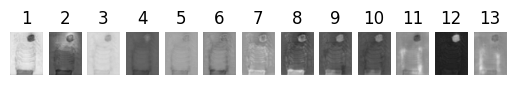

Epoch 0 | Batch 701 | GenLoss 1.5433515310287476 | DiscLoss 0.0014526877785101533
Epoch 0 | Batch 702 | GenLoss 2.2450647354125977 | DiscLoss 0.0013965393882244825
Epoch 0 | Batch 703 | GenLoss 1.8302415609359741 | DiscLoss 0.0012965782079845667
Epoch 0 | Batch 704 | GenLoss 2.2387242317199707 | DiscLoss 0.0016474785516038537
Epoch 0 | Batch 705 | GenLoss 1.510932207107544 | DiscLoss 0.0017174717504531145
Epoch 0 | Batch 706 | GenLoss 2.155102252960205 | DiscLoss 0.0012898469576612115
Epoch 0 | Batch 707 | GenLoss 1.593454122543335 | DiscLoss 0.0017650683876127005
Epoch 0 | Batch 708 | GenLoss 2.0380635261535645 | DiscLoss 0.001962842419743538
Epoch 0 | Batch 709 | GenLoss 1.503736972808838 | DiscLoss 0.0017268372466787696
Epoch 0 | Batch 710 | GenLoss 1.7518000602722168 | DiscLoss 0.0019237470114603639
Epoch 0 | Batch 711 | GenLoss 1.4192293882369995 | DiscLoss 0.0015936254058033228
Epoch 0 | Batch 712 | GenLoss 1.4303719997406006 | DiscLoss 0.001550139393657446
Epoch 0 | Batch 713 | 

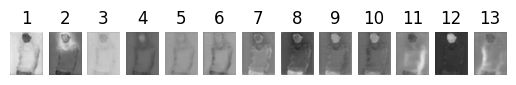

Epoch 0 | Batch 721 | GenLoss 1.642859697341919 | DiscLoss 0.0010054432787001133
Epoch 0 | Batch 722 | GenLoss 2.0936176776885986 | DiscLoss 0.0011145356111228466
Epoch 0 | Batch 723 | GenLoss 1.8224833011627197 | DiscLoss 0.0011317937169224024
Epoch 0 | Batch 724 | GenLoss 1.6353131532669067 | DiscLoss 0.0010949000716209412
Epoch 0 | Batch 725 | GenLoss 2.0095608234405518 | DiscLoss 0.0011611884692683816
Epoch 0 | Batch 726 | GenLoss 1.516866683959961 | DiscLoss 0.0009432763326913118
Epoch 0 | Batch 727 | GenLoss 1.7923794984817505 | DiscLoss 0.0011317241005599499
Epoch 0 | Batch 728 | GenLoss 2.395686626434326 | DiscLoss 0.000990706030279398
Epoch 0 | Batch 729 | GenLoss 1.8659305572509766 | DiscLoss 0.0010726144537329674
Epoch 0 | Batch 730 | GenLoss 1.6019251346588135 | DiscLoss 0.0011003809049725533
Epoch 0 | Batch 731 | GenLoss 1.6062123775482178 | DiscLoss 0.0009747921722009778
Epoch 0 | Batch 732 | GenLoss 1.7844514846801758 | DiscLoss 0.0010046235984191298
Epoch 0 | Batch 733 

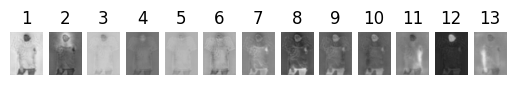

Epoch 0 | Batch 741 | GenLoss 1.9928358793258667 | DiscLoss 0.0011031175963580608
Epoch 0 | Batch 742 | GenLoss 1.7128090858459473 | DiscLoss 0.0010534358443692327
Epoch 0 | Batch 743 | GenLoss 1.6171958446502686 | DiscLoss 0.0009707018616609275
Epoch 0 | Batch 744 | GenLoss 2.2431280612945557 | DiscLoss 0.001034493325278163
Epoch 0 | Batch 745 | GenLoss 2.2669310569763184 | DiscLoss 0.0011466431897133589
Epoch 0 | Batch 746 | GenLoss 1.7842881679534912 | DiscLoss 0.0011774436570703983
Epoch 0 | Batch 747 | GenLoss 1.4636789560317993 | DiscLoss 0.0009256423218175769
Epoch 0 | Batch 748 | GenLoss 1.5275893211364746 | DiscLoss 0.0009602459031157196
Epoch 0 | Batch 749 | GenLoss 1.6725748777389526 | DiscLoss 0.0008905482245609164
Epoch 0 | Batch 750 | GenLoss 1.7806086540222168 | DiscLoss 0.0008711004629731178
Epoch 0 | Batch 751 | GenLoss 2.287797212600708 | DiscLoss 0.0009371925261802971
Epoch 0 | Batch 752 | GenLoss 1.7522311210632324 | DiscLoss 0.0009695422486402094
Epoch 0 | Batch 75

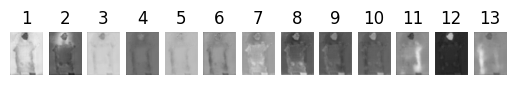

Epoch 0 | Batch 761 | GenLoss 1.515933871269226 | DiscLoss 0.0008130744099617004
Epoch 0 | Batch 762 | GenLoss 1.3877966403961182 | DiscLoss 0.0008045440772548318
Epoch 0 | Batch 763 | GenLoss 1.9553897380828857 | DiscLoss 0.0010892779100686312
Epoch 0 | Batch 764 | GenLoss 1.7927061319351196 | DiscLoss 0.0009237115737050772
Epoch 0 | Batch 765 | GenLoss 1.3559436798095703 | DiscLoss 0.000836830644402653
Epoch 0 | Batch 766 | GenLoss 1.8033359050750732 | DiscLoss 0.0009642514633014798
Epoch 0 | Batch 767 | GenLoss 1.2758249044418335 | DiscLoss 0.0009137667948380113
Epoch 0 | Batch 768 | GenLoss 1.6432271003723145 | DiscLoss 0.0009597280877642334
Epoch 0 | Batch 769 | GenLoss 1.532368540763855 | DiscLoss 0.0008631787495687604
Epoch 0 | Batch 770 | GenLoss 1.4678535461425781 | DiscLoss 0.000812350248452276
Epoch 0 | Batch 771 | GenLoss 1.622437834739685 | DiscLoss 0.0008522687712684274
Epoch 0 | Batch 772 | GenLoss 1.803629994392395 | DiscLoss 0.0008501399424858391
Epoch 0 | Batch 773 | 

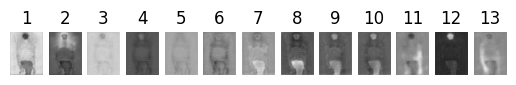

Epoch 0 | Batch 781 | GenLoss 1.6007589101791382 | DiscLoss 0.0007935137255117297
Epoch 0 | Batch 782 | GenLoss 1.6800956726074219 | DiscLoss 0.0007850783877074718
Epoch 0 | Batch 783 | GenLoss 1.6580114364624023 | DiscLoss 0.0008107527391985059
Epoch 0 | Batch 784 | GenLoss 2.2320315837860107 | DiscLoss 0.0009357210947200656
Epoch 0 | Batch 785 | GenLoss 1.6701321601867676 | DiscLoss 0.0008457776275463402
Epoch 0 | Batch 786 | GenLoss 1.5573161840438843 | DiscLoss 0.0007148974691517651
Epoch 0 | Batch 787 | GenLoss 1.5688133239746094 | DiscLoss 0.0007945518009364605
Epoch 0 | Batch 788 | GenLoss 1.653703212738037 | DiscLoss 0.0008305565570481122
Epoch 0 | Batch 789 | GenLoss 1.2608391046524048 | DiscLoss 0.0007497300393879414
Epoch 0 | Batch 790 | GenLoss 2.090421199798584 | DiscLoss 0.0009919463191181421
Epoch 0 | Batch 791 | GenLoss 1.2552716732025146 | DiscLoss 0.0007784358458593488
Epoch 0 | Batch 792 | GenLoss 1.3520119190216064 | DiscLoss 0.000857663108035922
Epoch 0 | Batch 793

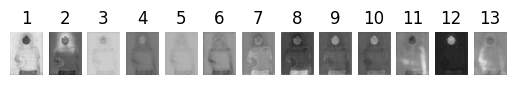

Epoch 0 | Batch 801 | GenLoss 1.2663898468017578 | DiscLoss 0.0007788624498061836
Epoch 0 | Batch 802 | GenLoss 2.5117075443267822 | DiscLoss 0.0009490487864241004
Epoch 0 | Batch 803 | GenLoss 1.9453215599060059 | DiscLoss 0.0008532297797501087
Epoch 0 | Batch 804 | GenLoss 1.4781206846237183 | DiscLoss 0.0008291028789244592
Epoch 0 | Batch 805 | GenLoss 3.1844818592071533 | DiscLoss 0.0008649651426821947
Epoch 0 | Batch 806 | GenLoss 1.4269556999206543 | DiscLoss 0.0008917924133129418
Epoch 0 | Batch 807 | GenLoss 2.3310420513153076 | DiscLoss 0.0009614711161702871
Epoch 0 | Batch 808 | GenLoss 1.4628114700317383 | DiscLoss 0.0015583924250677228
Epoch 0 | Batch 809 | GenLoss 1.9032204151153564 | DiscLoss 0.0010322993621230125
Epoch 0 | Batch 810 | GenLoss 1.7834006547927856 | DiscLoss 0.0008656903519295156
Epoch 0 | Batch 811 | GenLoss 1.5771293640136719 | DiscLoss 0.0008687457302585244
Epoch 0 | Batch 812 | GenLoss 1.5231025218963623 | DiscLoss 0.0009072749526239932
Epoch 0 | Batch 

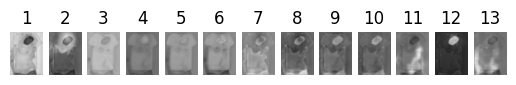

Epoch 0 | Batch 821 | GenLoss 1.5861179828643799 | DiscLoss 0.001077853376045823
Epoch 0 | Batch 822 | GenLoss 1.5331648588180542 | DiscLoss 0.0008469366002827883
Epoch 0 | Batch 823 | GenLoss 1.6148548126220703 | DiscLoss 0.001234641531482339
Epoch 0 | Batch 824 | GenLoss 1.2599729299545288 | DiscLoss 0.0008802652009762824
Epoch 0 | Batch 825 | GenLoss 1.45245361328125 | DiscLoss 0.0012709686998277903
Epoch 0 | Batch 826 | GenLoss 1.8693076372146606 | DiscLoss 0.001210405956953764
Epoch 0 | Batch 827 | GenLoss 1.269276738166809 | DiscLoss 0.0009080815361812711
Epoch 0 | Batch 828 | GenLoss 1.7065107822418213 | DiscLoss 0.00115597911644727
Epoch 0 | Batch 829 | GenLoss 1.4738826751708984 | DiscLoss 0.0011899552773684263
Epoch 0 | Batch 830 | GenLoss 1.518235445022583 | DiscLoss 0.0009537710575386882
Epoch 0 | Batch 831 | GenLoss 1.6969125270843506 | DiscLoss 0.0015301007078960538
Epoch 0 | Batch 832 | GenLoss 1.1414282321929932 | DiscLoss 0.0007870380650274456
Epoch 0 | Batch 833 | Gen

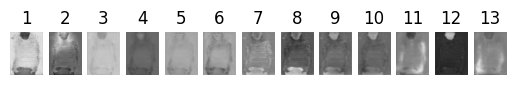

Epoch 0 | Batch 841 | GenLoss 1.4897973537445068 | DiscLoss 0.000977229792624712
Epoch 0 | Batch 842 | GenLoss 1.4913004636764526 | DiscLoss 0.000720485404599458
Epoch 0 | Batch 843 | GenLoss 1.7995944023132324 | DiscLoss 0.0007560685044154525
Epoch 0 | Batch 844 | GenLoss 1.4756321907043457 | DiscLoss 0.0008368679555132985
Epoch 0 | Batch 845 | GenLoss 1.3893412351608276 | DiscLoss 0.0007592268520966172
Epoch 0 | Batch 846 | GenLoss 1.8979191780090332 | DiscLoss 0.0008026114664971828
Epoch 0 | Batch 847 | GenLoss 1.6494137048721313 | DiscLoss 0.0008138900739140809
Epoch 0 | Batch 848 | GenLoss 1.180521845817566 | DiscLoss 0.0007679559057578444
Epoch 0 | Batch 849 | GenLoss 1.5935337543487549 | DiscLoss 0.0007934168679639697
Epoch 0 | Batch 850 | GenLoss 1.6231114864349365 | DiscLoss 0.0008144199382513762
Epoch 0 | Batch 851 | GenLoss 1.5302926301956177 | DiscLoss 0.0007626989390701056
Epoch 0 | Batch 852 | GenLoss 1.2614209651947021 | DiscLoss 0.0007644921424798667
Epoch 0 | Batch 853

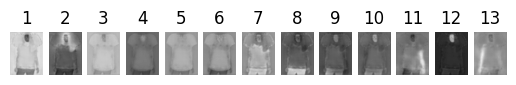

Epoch 0 | Batch 861 | GenLoss 1.219274878501892 | DiscLoss 0.0007781574968248606
Epoch 0 | Batch 862 | GenLoss 1.5249429941177368 | DiscLoss 0.0007067108526825905
Epoch 0 | Batch 863 | GenLoss 1.6684982776641846 | DiscLoss 0.0007032838184386492
Epoch 0 | Batch 864 | GenLoss 1.540578007698059 | DiscLoss 0.0007217671955004334
Epoch 0 | Batch 865 | GenLoss 1.7622952461242676 | DiscLoss 0.0007334580877795815
Epoch 0 | Batch 866 | GenLoss 1.5887725353240967 | DiscLoss 0.0006586164236068726
Epoch 0 | Batch 867 | GenLoss 1.6311874389648438 | DiscLoss 0.0006872111698612571
Epoch 0 | Batch 868 | GenLoss 1.2787208557128906 | DiscLoss 0.0006737997755408287
Epoch 0 | Batch 869 | GenLoss 1.3283227682113647 | DiscLoss 0.0006838256376795471
Epoch 0 | Batch 870 | GenLoss 1.4882701635360718 | DiscLoss 0.0007129637524485588
Epoch 0 | Batch 871 | GenLoss 1.9598374366760254 | DiscLoss 0.0007367887883447111
Epoch 0 | Batch 872 | GenLoss 2.018921136856079 | DiscLoss 0.0006840524147264659
Epoch 0 | Batch 873

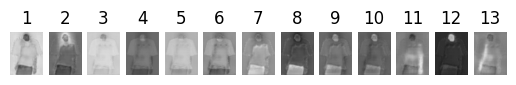

Epoch 0 | Batch 881 | GenLoss 1.2039660215377808 | DiscLoss 0.000647173379547894
Epoch 0 | Batch 882 | GenLoss 1.486809253692627 | DiscLoss 0.0007101247902028263
Epoch 0 | Batch 883 | GenLoss 1.6358070373535156 | DiscLoss 0.000697174109518528
Epoch 0 | Batch 884 | GenLoss 1.742067813873291 | DiscLoss 0.0012376662343740463
Epoch 0 | Batch 885 | GenLoss 1.2526910305023193 | DiscLoss 0.0007220279658213258
Epoch 0 | Batch 886 | GenLoss 1.5334868431091309 | DiscLoss 0.0007178146624937654
Epoch 0 | Batch 887 | GenLoss 1.859466314315796 | DiscLoss 0.0007418380118906498
Epoch 0 | Batch 888 | GenLoss 1.3503386974334717 | DiscLoss 0.0007225126610137522
Epoch 0 | Batch 889 | GenLoss 1.8523359298706055 | DiscLoss 0.0006291177123785019
Epoch 0 | Batch 890 | GenLoss 1.4818530082702637 | DiscLoss 0.0007094803149811924
Epoch 0 | Batch 891 | GenLoss 1.4564483165740967 | DiscLoss 0.0006243501557037234
Epoch 0 | Batch 892 | GenLoss 1.3025188446044922 | DiscLoss 0.0007094908505678177
Epoch 0 | Batch 893 |

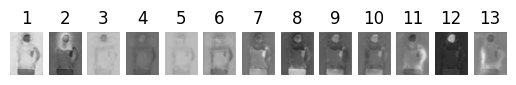

Epoch 0 | Batch 901 | GenLoss 1.4324798583984375 | DiscLoss 0.0006304789567366242
Epoch 0 | Batch 902 | GenLoss 1.2612154483795166 | DiscLoss 0.0006788797909393907
Epoch 0 | Batch 903 | GenLoss 1.455121636390686 | DiscLoss 0.0006587064126506448
Epoch 0 | Batch 904 | GenLoss 1.850454568862915 | DiscLoss 0.0007554790936410427
Epoch 0 | Batch 905 | GenLoss 1.3414480686187744 | DiscLoss 0.0006678595673292875
Epoch 0 | Batch 906 | GenLoss 2.323470115661621 | DiscLoss 0.0007896091556176543
Epoch 0 | Batch 907 | GenLoss 1.5641683340072632 | DiscLoss 0.0006100077298469841
Epoch 0 | Batch 908 | GenLoss 1.5274486541748047 | DiscLoss 0.0006727328291162848
Epoch 0 | Batch 909 | GenLoss 1.8955352306365967 | DiscLoss 0.0007821035105735064
Epoch 0 | Batch 910 | GenLoss 1.439218282699585 | DiscLoss 0.0006394129013642669
Epoch 0 | Batch 911 | GenLoss 1.4219775199890137 | DiscLoss 0.0006329742027446628
Epoch 0 | Batch 912 | GenLoss 1.2389156818389893 | DiscLoss 0.0007563044782727957
Epoch 0 | Batch 913 

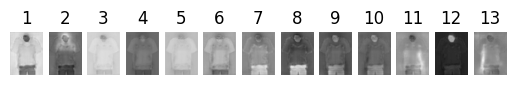

Epoch 0 | Batch 921 | GenLoss 1.391313076019287 | DiscLoss 0.0005906404694542289
Epoch 0 | Batch 922 | GenLoss 1.25178861618042 | DiscLoss 0.0006656863843090832
Epoch 0 | Batch 923 | GenLoss 1.4966726303100586 | DiscLoss 0.0007569175795651972
Epoch 0 | Batch 924 | GenLoss 1.1553049087524414 | DiscLoss 0.0007746013579890132
Epoch 0 | Batch 925 | GenLoss 1.4423692226409912 | DiscLoss 0.000608367845416069
Epoch 0 | Batch 926 | GenLoss 1.443299651145935 | DiscLoss 0.0007339305593632162
Epoch 0 | Batch 927 | GenLoss 1.6158133745193481 | DiscLoss 0.0006301944376900792
Epoch 0 | Batch 928 | GenLoss 1.4683101177215576 | DiscLoss 0.0007588316220790148
Epoch 0 | Batch 929 | GenLoss 1.3452850580215454 | DiscLoss 0.0006338286329992115
Epoch 0 | Batch 930 | GenLoss 1.5914058685302734 | DiscLoss 0.0006537465960718691
Epoch 0 | Batch 931 | GenLoss 1.2841241359710693 | DiscLoss 0.0007691242499276996
Epoch 0 | Batch 932 | GenLoss 1.7450259923934937 | DiscLoss 0.0007778540020808578
Epoch 0 | Batch 933 |

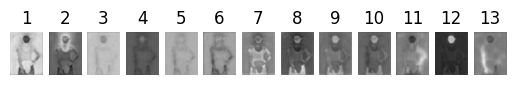

Epoch 0 | Batch 941 | GenLoss 1.3635473251342773 | DiscLoss 0.0007497351616621017
Epoch 0 | Batch 942 | GenLoss 1.2593743801116943 | DiscLoss 0.000683446298353374
Epoch 0 | Batch 943 | GenLoss 1.0648863315582275 | DiscLoss 0.000623763189651072
Epoch 0 | Batch 944 | GenLoss 1.7052438259124756 | DiscLoss 0.0006333915516734123
Epoch 0 | Batch 945 | GenLoss 1.5532463788986206 | DiscLoss 0.0007328925421461463
Epoch 0 | Batch 946 | GenLoss 1.3930248022079468 | DiscLoss 0.0007829546229913831
Epoch 0 | Batch 947 | GenLoss 1.304208517074585 | DiscLoss 0.0006860028952360153
Epoch 0 | Batch 948 | GenLoss 1.4629933834075928 | DiscLoss 0.0005979903507977724
Epoch 0 | Batch 949 | GenLoss 1.2815234661102295 | DiscLoss 0.0005868795560672879
Epoch 0 | Batch 950 | GenLoss 1.6190190315246582 | DiscLoss 0.0007564559346064925
Epoch 0 | Batch 951 | GenLoss 2.182844877243042 | DiscLoss 0.0005905343568883836
Epoch 0 | Batch 952 | GenLoss 1.2925200462341309 | DiscLoss 0.0006058082217350602
Epoch 0 | Batch 953 

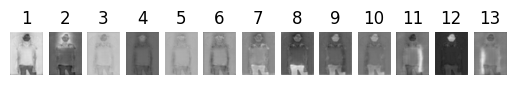

Epoch 0 | Batch 961 | GenLoss 1.5152034759521484 | DiscLoss 0.0006119933677837253
Epoch 0 | Batch 962 | GenLoss 1.4500598907470703 | DiscLoss 0.0005904776626266539
Epoch 0 | Batch 963 | GenLoss 2.009439468383789 | DiscLoss 0.0007967197452671826
Epoch 0 | Batch 964 | GenLoss 1.5256232023239136 | DiscLoss 0.0006577369058504701
Epoch 0 | Batch 965 | GenLoss 1.624098300933838 | DiscLoss 0.0005983675364404917
Epoch 0 | Batch 966 | GenLoss 1.3050843477249146 | DiscLoss 0.0006176016759127378
Epoch 0 | Batch 967 | GenLoss 1.9467012882232666 | DiscLoss 0.0006682855309918523
Epoch 0 | Batch 968 | GenLoss 1.4700895547866821 | DiscLoss 0.0006373709766194224
Epoch 0 | Batch 969 | GenLoss 1.653207540512085 | DiscLoss 0.0005757433245889843
Epoch 0 | Batch 970 | GenLoss 1.7931792736053467 | DiscLoss 0.0007059774943627417
Epoch 0 | Batch 971 | GenLoss 1.3274623155593872 | DiscLoss 0.0006416195537894964
Epoch 0 | Batch 972 | GenLoss 1.5687286853790283 | DiscLoss 0.0007231521885842085
Epoch 0 | Batch 973

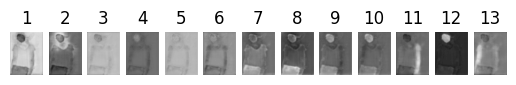

Epoch 0 | Batch 981 | GenLoss 1.3882583379745483 | DiscLoss 0.0005842474056407809
Epoch 0 | Batch 982 | GenLoss 1.2884554862976074 | DiscLoss 0.0005986033356748521
Epoch 0 | Batch 983 | GenLoss 1.6473196744918823 | DiscLoss 0.0006172486464492977
Epoch 0 | Batch 984 | GenLoss 1.488051414489746 | DiscLoss 0.0006000519497320056
Epoch 0 | Batch 985 | GenLoss 1.4673656225204468 | DiscLoss 0.0006123232305981219
Epoch 0 | Batch 986 | GenLoss 1.2889295816421509 | DiscLoss 0.0005856149364262819
Epoch 0 | Batch 987 | GenLoss 1.7617700099945068 | DiscLoss 0.0007178605301305652
Epoch 0 | Batch 988 | GenLoss 1.4614170789718628 | DiscLoss 0.0006201820797286928
Epoch 0 | Batch 989 | GenLoss 1.2666326761245728 | DiscLoss 0.0006500417366623878
Epoch 0 | Batch 990 | GenLoss 2.060647964477539 | DiscLoss 0.000585759524255991
Epoch 0 | Batch 991 | GenLoss 1.7596325874328613 | DiscLoss 0.0006656268378719687
Epoch 0 | Batch 992 | GenLoss 1.12325119972229 | DiscLoss 0.0005987152690067887
Epoch 0 | Batch 993 |

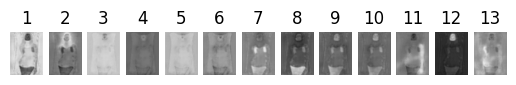

Epoch 0 | Batch 1001 | GenLoss 1.282544732093811 | DiscLoss 0.0006356969242915511
Epoch 0 | Batch 1002 | GenLoss 1.823301076889038 | DiscLoss 0.0007352568791247904
Epoch 0 | Batch 1003 | GenLoss 1.5435287952423096 | DiscLoss 0.0006282753893174231
Epoch 0 | Batch 1004 | GenLoss 1.4260647296905518 | DiscLoss 0.0006765453144907951
Epoch 0 | Batch 1005 | GenLoss 1.798248529434204 | DiscLoss 0.0005689633544534445
Epoch 0 | Batch 1006 | GenLoss 1.3278703689575195 | DiscLoss 0.0006938778678886592
Epoch 0 | Batch 1007 | GenLoss 1.2706553936004639 | DiscLoss 0.0006319184321910143
Epoch 0 | Batch 1008 | GenLoss 1.3482036590576172 | DiscLoss 0.0007443685317412019
Epoch 0 | Batch 1009 | GenLoss 1.3867450952529907 | DiscLoss 0.0007490988355129957
Epoch 0 | Batch 1010 | GenLoss 1.2939987182617188 | DiscLoss 0.0007608793675899506
Epoch 0 | Batch 1011 | GenLoss 1.7289930582046509 | DiscLoss 0.0006192378932610154
Epoch 0 | Batch 1012 | GenLoss 1.6265497207641602 | DiscLoss 0.0005931598134338856
Epoch 0

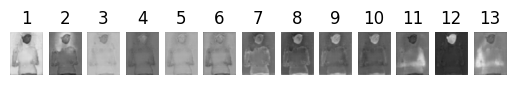

Epoch 0 | Batch 1021 | GenLoss 1.351750135421753 | DiscLoss 0.0006313835619948804
Epoch 0 | Batch 1022 | GenLoss 1.7751548290252686 | DiscLoss 0.0006757692317478359
Epoch 0 | Batch 1023 | GenLoss 1.5413016080856323 | DiscLoss 0.0006241752998903394
Epoch 0 | Batch 1024 | GenLoss 1.7550151348114014 | DiscLoss 0.0004779270966537297
Epoch 0 | Batch 1025 | GenLoss 1.461232304573059 | DiscLoss 0.0005923899589106441
Epoch 0 | Batch 1026 | GenLoss 1.5407681465148926 | DiscLoss 0.0006724825943820179
Epoch 0 | Batch 1027 | GenLoss 1.6018118858337402 | DiscLoss 0.0008485302678309381
Epoch 0 | Batch 1028 | GenLoss 1.3220975399017334 | DiscLoss 0.0006535431020893157
Epoch 0 | Batch 1029 | GenLoss 1.832976222038269 | DiscLoss 0.0007747736526653171
Epoch 0 | Batch 1030 | GenLoss 1.0349831581115723 | DiscLoss 0.0005007224390283227
Epoch 0 | Batch 1031 | GenLoss 1.1779580116271973 | DiscLoss 0.0005967892939224839
Epoch 0 | Batch 1032 | GenLoss 1.2404005527496338 | DiscLoss 0.0005569069180637598
Epoch 0

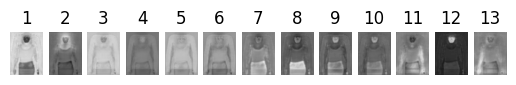

Epoch 0 | Batch 1041 | GenLoss 1.4119772911071777 | DiscLoss 0.0005051709013059735
Epoch 0 | Batch 1042 | GenLoss 1.5009338855743408 | DiscLoss 0.0005072702188044786
Epoch 0 | Batch 1043 | GenLoss 1.2209300994873047 | DiscLoss 0.0005120616406202316
Epoch 0 | Batch 1044 | GenLoss 1.2762682437896729 | DiscLoss 0.0006284405244514346
Epoch 0 | Batch 1045 | GenLoss 1.1463245153427124 | DiscLoss 0.0005395126063376665
Epoch 0 | Batch 1046 | GenLoss 1.3330166339874268 | DiscLoss 0.0005140596185810864
Epoch 0 | Batch 1047 | GenLoss 1.222022294998169 | DiscLoss 0.00048445258289575577
Epoch 0 | Batch 1048 | GenLoss 1.7869949340820312 | DiscLoss 0.0005168882198631763
Epoch 0 | Batch 1049 | GenLoss 1.568428874015808 | DiscLoss 0.000482325121993199
Epoch 0 | Batch 1050 | GenLoss 1.19981849193573 | DiscLoss 0.0005688584060408175
Epoch 0 | Batch 1051 | GenLoss 1.3526997566223145 | DiscLoss 0.0005279050674289465
Epoch 0 | Batch 1052 | GenLoss 1.0090687274932861 | DiscLoss 0.0005143352900631726
Epoch 0 

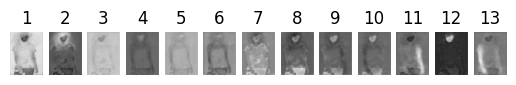

Epoch 0 | Batch 1061 | GenLoss 1.1829009056091309 | DiscLoss 0.0005713044665753841
Epoch 0 | Batch 1062 | GenLoss 1.7366735935211182 | DiscLoss 0.0005989144556224346
Epoch 0 | Batch 1063 | GenLoss 1.0851407051086426 | DiscLoss 0.0005093512590974569
Epoch 0 | Batch 1064 | GenLoss 1.3126808404922485 | DiscLoss 0.0005277260206639767
Epoch 0 | Batch 1065 | GenLoss 1.3703482151031494 | DiscLoss 0.0004691208014264703
Epoch 0 | Batch 1066 | GenLoss 1.6057580709457397 | DiscLoss 0.00045660542673431337
Epoch 0 | Batch 1067 | GenLoss 1.1227918863296509 | DiscLoss 0.0004910512361675501
Epoch 0 | Batch 1068 | GenLoss 1.2395100593566895 | DiscLoss 0.0005331770516932011
Epoch 0 | Batch 1069 | GenLoss 1.2076051235198975 | DiscLoss 0.000474462634883821
Epoch 0 | Batch 1070 | GenLoss 1.348673701286316 | DiscLoss 0.0006512750987894833
Epoch 0 | Batch 1071 | GenLoss 1.399531364440918 | DiscLoss 0.0005374635802581906
Epoch 0 | Batch 1072 | GenLoss 2.2457501888275146 | DiscLoss 0.0004891628632321954
Epoch 

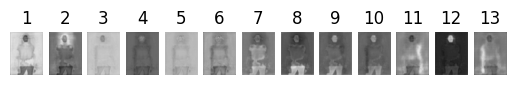

Epoch 0 | Batch 1081 | GenLoss 1.2353358268737793 | DiscLoss 0.00048593239625915885
Epoch 0 | Batch 1082 | GenLoss 1.2762131690979004 | DiscLoss 0.0005443515256047249
Epoch 0 | Batch 1083 | GenLoss 1.2493456602096558 | DiscLoss 0.00047151799662970006
Epoch 0 | Batch 1084 | GenLoss 0.8740811347961426 | DiscLoss 0.0004971397574990988
Epoch 0 | Batch 1085 | GenLoss 1.5033684968948364 | DiscLoss 0.0005560211138799787
Epoch 0 | Batch 1086 | GenLoss 1.047752857208252 | DiscLoss 0.0004943204112350941
Epoch 0 | Batch 1087 | GenLoss 1.2270094156265259 | DiscLoss 0.00044837937457486987
Epoch 0 | Batch 1088 | GenLoss 1.363049030303955 | DiscLoss 0.0004869358381256461
Epoch 0 | Batch 1089 | GenLoss 1.1993505954742432 | DiscLoss 0.0005136075196787715
Epoch 0 | Batch 1090 | GenLoss 1.2186338901519775 | DiscLoss 0.000626225839368999
Epoch 0 | Batch 1091 | GenLoss 1.9936835765838623 | DiscLoss 0.0004638051032088697
Epoch 0 | Batch 1092 | GenLoss 1.2715007066726685 | DiscLoss 0.0004569600860122591
Epoc

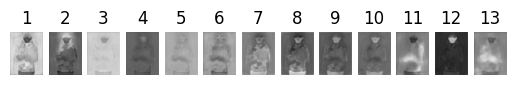

Epoch 0 | Batch 1101 | GenLoss 1.5201646089553833 | DiscLoss 0.00046322651905938983
Epoch 0 | Batch 1102 | GenLoss 1.412574052810669 | DiscLoss 0.0004624268040060997
Epoch 0 | Batch 1103 | GenLoss 1.8520927429199219 | DiscLoss 0.000568539253436029
Epoch 0 | Batch 1104 | GenLoss 1.4508936405181885 | DiscLoss 0.0005052147898823023
Epoch 0 | Batch 1105 | GenLoss 1.1169606447219849 | DiscLoss 0.0005975959356874228
Epoch 0 | Batch 1106 | GenLoss 1.4950861930847168 | DiscLoss 0.0007179404492489994
Epoch 0 | Batch 1107 | GenLoss 1.4729892015457153 | DiscLoss 0.0006131919799372554
Epoch 0 | Batch 1108 | GenLoss 1.5292043685913086 | DiscLoss 0.0005549128982238472
Epoch 0 | Batch 1109 | GenLoss 1.6013003587722778 | DiscLoss 0.0004720741999335587
Epoch 0 | Batch 1110 | GenLoss 1.4093999862670898 | DiscLoss 0.0004993092734366655
Epoch 0 | Batch 1111 | GenLoss 1.5225379467010498 | DiscLoss 0.0005099143018014729
Epoch 0 | Batch 1112 | GenLoss 1.0799801349639893 | DiscLoss 0.0005379779613576829
Epoch

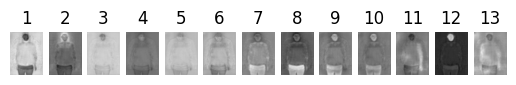

Epoch 0 | Batch 1121 | GenLoss 1.6618456840515137 | DiscLoss 0.0004681928548961878
Epoch 0 | Batch 1122 | GenLoss 1.3824915885925293 | DiscLoss 0.00045274419244378805
Epoch 0 | Batch 1123 | GenLoss 1.1860432624816895 | DiscLoss 0.00043328682659193873
Epoch 0 | Batch 1124 | GenLoss 1.3815361261367798 | DiscLoss 0.0005206410423852503
Epoch 0 | Batch 1125 | GenLoss 1.4041550159454346 | DiscLoss 0.0004636808589566499
Epoch 0 | Batch 1126 | GenLoss 1.1362082958221436 | DiscLoss 0.00044304702896624804
Epoch 0 | Batch 1127 | GenLoss 1.219281792640686 | DiscLoss 0.0004072846204508096
Epoch 0 | Batch 1128 | GenLoss 1.0501782894134521 | DiscLoss 0.0005330045241862535
Epoch 0 | Batch 1129 | GenLoss 1.1703845262527466 | DiscLoss 0.000489232421386987
Epoch 0 | Batch 1130 | GenLoss 1.834627628326416 | DiscLoss 0.0005045055877417326
Epoch 0 | Batch 1131 | GenLoss 1.3815306425094604 | DiscLoss 0.00046742812264710665
Epoch 0 | Batch 1132 | GenLoss 1.2159239053726196 | DiscLoss 0.0004885721718892455
Epo

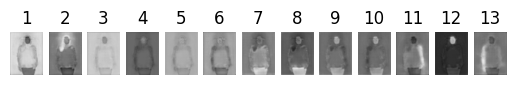

Epoch 0 | Batch 1141 | GenLoss 1.0730412006378174 | DiscLoss 0.000503243412822485
Epoch 0 | Batch 1142 | GenLoss 1.2681983709335327 | DiscLoss 0.00045095078530721366
Epoch 0 | Batch 1143 | GenLoss 1.1704715490341187 | DiscLoss 0.00042158295400440693
Epoch 0 | Batch 1144 | GenLoss 1.3749430179595947 | DiscLoss 0.0004210357437841594
Epoch 0 | Batch 1145 | GenLoss 2.159177780151367 | DiscLoss 0.0004557807696983218
Epoch 0 | Batch 1146 | GenLoss 1.6658436059951782 | DiscLoss 0.00045874720672145486
Epoch 0 | Batch 1147 | GenLoss 1.8035047054290771 | DiscLoss 0.0005410741432569921
Epoch 0 | Batch 1148 | GenLoss 0.9235637187957764 | DiscLoss 0.0004835797008126974
Epoch 0 | Batch 1149 | GenLoss 1.2683508396148682 | DiscLoss 0.0006760457181371748
Epoch 0 | Batch 1150 | GenLoss 1.6674039363861084 | DiscLoss 0.0004949389258399606
Epoch 0 | Batch 1151 | GenLoss 1.4339834451675415 | DiscLoss 0.0005560399149544537
Epoch 0 | Batch 1152 | GenLoss 1.5780704021453857 | DiscLoss 0.0005297701572999358
Epo

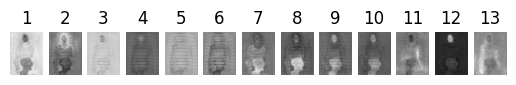

Epoch 0 | Batch 1161 | GenLoss 1.791793704032898 | DiscLoss 0.00046605506213381886
Epoch 0 | Batch 1162 | GenLoss 1.3165786266326904 | DiscLoss 0.0004890047712251544
Epoch 0 | Batch 1163 | GenLoss 0.9773313999176025 | DiscLoss 0.0004362001200206578
Epoch 0 | Batch 1164 | GenLoss 2.472341537475586 | DiscLoss 0.0004703521553892642
Epoch 0 | Batch 1165 | GenLoss 1.0891764163970947 | DiscLoss 0.0004590160388033837
Epoch 0 | Batch 1166 | GenLoss 1.3521301746368408 | DiscLoss 0.0004345641937106848
Epoch 0 | Batch 1167 | GenLoss 1.0788394212722778 | DiscLoss 0.00041397332097403705
Epoch 0 | Batch 1168 | GenLoss 1.3245139122009277 | DiscLoss 0.00042440538527444005
Epoch 0 | Batch 1169 | GenLoss 1.3641283512115479 | DiscLoss 0.0003839939890895039
Epoch 0 | Batch 1170 | GenLoss 1.1386429071426392 | DiscLoss 0.0004361967439763248
Epoch 0 | Batch 1171 | GenLoss 1.305734395980835 | DiscLoss 0.0004876860766671598
Epoch 0 | Batch 1172 | GenLoss 0.9674625992774963 | DiscLoss 0.0005069838371127844
Epoc

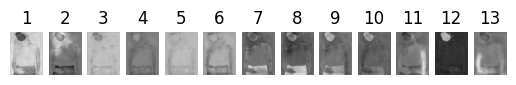

Epoch 0 | Batch 1181 | GenLoss 1.486280083656311 | DiscLoss 0.0005477000959217548
Epoch 0 | Batch 1182 | GenLoss 1.244318962097168 | DiscLoss 0.0004196539521217346
Epoch 0 | Batch 1183 | GenLoss 1.3890749216079712 | DiscLoss 0.00048139027785509825
Epoch 0 | Batch 1184 | GenLoss 1.2400763034820557 | DiscLoss 0.00038940313970670104
Epoch 0 | Batch 1185 | GenLoss 1.062792420387268 | DiscLoss 0.00040434033144265413
Epoch 0 | Batch 1186 | GenLoss 2.17342472076416 | DiscLoss 0.0005965342279523611
Epoch 0 | Batch 1187 | GenLoss 1.0131170749664307 | DiscLoss 0.0004025503294542432
Epoch 0 | Batch 1188 | GenLoss 1.3087334632873535 | DiscLoss 0.00041021197102963924
Epoch 0 | Batch 1189 | GenLoss 1.0112769603729248 | DiscLoss 0.0005275544244796038
Epoch 0 | Batch 1190 | GenLoss 1.1779676675796509 | DiscLoss 0.00036363606341183186
Epoch 0 | Batch 1191 | GenLoss 1.0427930355072021 | DiscLoss 0.0004347649519331753
Epoch 0 | Batch 1192 | GenLoss 1.3533753156661987 | DiscLoss 0.0004039765917696059
Epoc

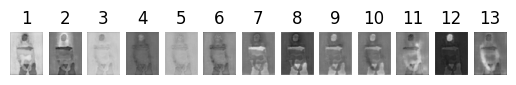

Epoch 0 | Batch 1201 | GenLoss 2.037783622741699 | DiscLoss 0.00039792555617168546
Epoch 0 | Batch 1202 | GenLoss 1.3236987590789795 | DiscLoss 0.0004480691277422011
Epoch 0 | Batch 1203 | GenLoss 1.124924659729004 | DiscLoss 0.0004073047311976552
Epoch 0 | Batch 1204 | GenLoss 1.365983247756958 | DiscLoss 0.0004990599700249732
Epoch 0 | Batch 1205 | GenLoss 1.4514487981796265 | DiscLoss 0.0004911682335659862
Epoch 0 | Batch 1206 | GenLoss 1.0311170816421509 | DiscLoss 0.00038121285615488887
Epoch 0 | Batch 1207 | GenLoss 1.4421664476394653 | DiscLoss 0.00039666355587542057
Epoch 0 | Batch 1208 | GenLoss 1.2274807691574097 | DiscLoss 0.00045942870201542974
Epoch 0 | Batch 1209 | GenLoss 1.0193129777908325 | DiscLoss 0.0003704685077536851
Epoch 0 | Batch 1210 | GenLoss 1.185736894607544 | DiscLoss 0.0003813107032328844
Epoch 0 | Batch 1211 | GenLoss 1.090446949005127 | DiscLoss 0.000445129640866071
Epoch 0 | Batch 1212 | GenLoss 0.9380420446395874 | DiscLoss 0.000374308496247977
Epoch 0

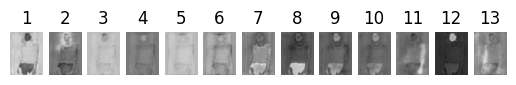

Epoch 0 | Batch 1221 | GenLoss 1.11955988407135 | DiscLoss 0.00044518703361973166
Epoch 0 | Batch 1222 | GenLoss 1.4652166366577148 | DiscLoss 0.0004095227923244238
Epoch 0 | Batch 1223 | GenLoss 1.5019049644470215 | DiscLoss 0.00037968388642184436
Epoch 0 | Batch 1224 | GenLoss 1.4524261951446533 | DiscLoss 0.00038564769783988595
Epoch 0 | Batch 1225 | GenLoss 1.1902873516082764 | DiscLoss 0.0003398261032998562
Epoch 0 | Batch 1226 | GenLoss 1.2168946266174316 | DiscLoss 0.00037092671846039593
Epoch 0 | Batch 1227 | GenLoss 1.44045889377594 | DiscLoss 0.0005031612236052752
Epoch 0 | Batch 1228 | GenLoss 1.2603496313095093 | DiscLoss 0.0003877273993566632
Epoch 0 | Batch 1229 | GenLoss 1.0473095178604126 | DiscLoss 0.0003622833173722029
Epoch 0 | Batch 1230 | GenLoss 1.242173194885254 | DiscLoss 0.00039580371230840683
Epoch 0 | Batch 1231 | GenLoss 1.0716098546981812 | DiscLoss 0.0004010593402199447
Epoch 0 | Batch 1232 | GenLoss 0.9882398843765259 | DiscLoss 0.000407780782552436
Epoch

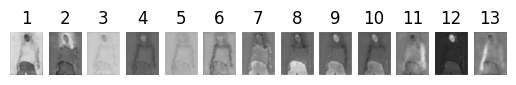

Epoch 0 | Batch 1241 | GenLoss 1.0742138624191284 | DiscLoss 0.0003665073018055409
Epoch 0 | Batch 1242 | GenLoss 1.0683324337005615 | DiscLoss 0.00035298860166221857
Epoch 0 | Batch 1243 | GenLoss 1.6556060314178467 | DiscLoss 0.0003794271615333855
Epoch 0 | Batch 1244 | GenLoss 1.0517752170562744 | DiscLoss 0.00038878325722180307
Epoch 0 | Batch 1245 | GenLoss 1.4587019681930542 | DiscLoss 0.0003783350985031575
Epoch 0 | Batch 1246 | GenLoss 0.9934204816818237 | DiscLoss 0.00035830624983645976
Epoch 0 | Batch 1247 | GenLoss 1.5163565874099731 | DiscLoss 0.00042358331847935915
Epoch 0 | Batch 1248 | GenLoss 1.6117749214172363 | DiscLoss 0.00043784797890111804
Epoch 0 | Batch 1249 | GenLoss 2.3273191452026367 | DiscLoss 0.0004058329504914582
Epoch 0 | Batch 1250 | GenLoss 1.0244165658950806 | DiscLoss 0.0003112723643425852
Epoch 0 | Batch 1251 | GenLoss 1.1917188167572021 | DiscLoss 0.00033901823917403817
Epoch 0 | Batch 1252 | GenLoss 1.272669792175293 | DiscLoss 0.0004219730035401881

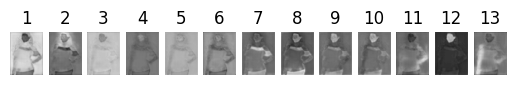

Epoch 0 | Batch 1261 | GenLoss 1.1572601795196533 | DiscLoss 0.00039741621003486216
Epoch 0 | Batch 1262 | GenLoss 0.9223170280456543 | DiscLoss 0.00039422514964826405
Epoch 0 | Batch 1263 | GenLoss 1.2351651191711426 | DiscLoss 0.00041783915366977453
Epoch 0 | Batch 1264 | GenLoss 1.203962802886963 | DiscLoss 0.00037334184162318707
Epoch 0 | Batch 1265 | GenLoss 1.3046035766601562 | DiscLoss 0.0003635472385212779
Epoch 0 | Batch 1266 | GenLoss 1.0708608627319336 | DiscLoss 0.00041907280683517456
Epoch 0 | Batch 1267 | GenLoss 1.4926289319992065 | DiscLoss 0.00041408935794606805
Epoch 0 | Batch 1268 | GenLoss 1.0772713422775269 | DiscLoss 0.00031091427081264555
Epoch 0 | Batch 1269 | GenLoss 1.152328372001648 | DiscLoss 0.00043128582183271646
Epoch 0 | Batch 1270 | GenLoss 1.3360023498535156 | DiscLoss 0.00046857839333824813
Epoch 0 | Batch 1271 | GenLoss 1.0336631536483765 | DiscLoss 0.00041305378545075655
Epoch 0 | Batch 1272 | GenLoss 1.5457326173782349 | DiscLoss 0.0003997277235612

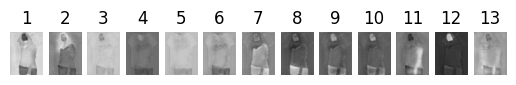

Epoch 0 | Batch 1281 | GenLoss 0.8877736330032349 | DiscLoss 0.0003564928483683616
Epoch 0 | Batch 1282 | GenLoss 1.3308119773864746 | DiscLoss 0.00041630398482084274
Epoch 0 | Batch 1283 | GenLoss 2.564958333969116 | DiscLoss 0.0004187502490822226
Epoch 0 | Batch 1284 | GenLoss 0.9186911582946777 | DiscLoss 0.00034549995325505733
Epoch 0 | Batch 1285 | GenLoss 1.0648291110992432 | DiscLoss 0.000364721316145733
Epoch 0 | Batch 1286 | GenLoss 1.7073333263397217 | DiscLoss 0.00038269261131063104
Epoch 0 | Batch 1287 | GenLoss 1.4803146123886108 | DiscLoss 0.00035343808121979237
Epoch 0 | Batch 1288 | GenLoss 0.8973523378372192 | DiscLoss 0.00036906806053593755
Epoch 0 | Batch 1289 | GenLoss 1.1383317708969116 | DiscLoss 0.0003682904352899641
Epoch 0 | Batch 1290 | GenLoss 1.4148292541503906 | DiscLoss 0.00039849805762059987
Epoch 0 | Batch 1291 | GenLoss 1.0201144218444824 | DiscLoss 0.0003648700949270278
Epoch 0 | Batch 1292 | GenLoss 1.331959843635559 | DiscLoss 0.00043053895933553576


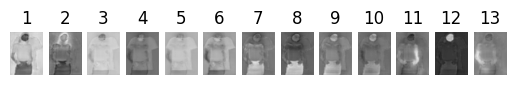

Epoch 0 | Batch 1301 | GenLoss 1.364532709121704 | DiscLoss 0.00040402438025921583
Epoch 0 | Batch 1302 | GenLoss 1.0393850803375244 | DiscLoss 0.0003368902252987027
Epoch 0 | Batch 1303 | GenLoss 1.1920084953308105 | DiscLoss 0.0003388886689208448
Epoch 0 | Batch 1304 | GenLoss 1.2866103649139404 | DiscLoss 0.0003785928711295128
Epoch 0 | Batch 1305 | GenLoss 0.9435783624649048 | DiscLoss 0.00032030136208049953
Epoch 0 | Batch 1306 | GenLoss 0.9624205827713013 | DiscLoss 0.000341919920174405
Epoch 0 | Batch 1307 | GenLoss 1.4558459520339966 | DiscLoss 0.00037808052729815245
Epoch 0 | Batch 1308 | GenLoss 1.2898390293121338 | DiscLoss 0.0003173926961608231
Epoch 0 | Batch 1309 | GenLoss 0.7644614577293396 | DiscLoss 0.00032535725040361285
Epoch 0 | Batch 1310 | GenLoss 1.2733736038208008 | DiscLoss 0.0005009762244299054
Epoch 0 | Batch 1311 | GenLoss 0.9718202352523804 | DiscLoss 0.0003750280011445284
Epoch 0 | Batch 1312 | GenLoss 1.0440727472305298 | DiscLoss 0.00041082489769905806
E

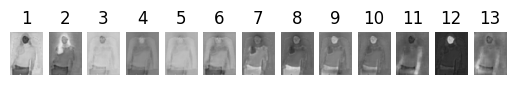

Epoch 0 | Batch 1321 | GenLoss 0.9917502403259277 | DiscLoss 0.00034514369326643646
Epoch 0 | Batch 1322 | GenLoss 1.06143057346344 | DiscLoss 0.0003742521512322128
Epoch 0 | Batch 1323 | GenLoss 1.0974805355072021 | DiscLoss 0.0008318401523865759
Epoch 0 | Batch 1324 | GenLoss 1.14011812210083 | DiscLoss 0.00043043034384027123
Epoch 0 | Batch 1325 | GenLoss 1.3491556644439697 | DiscLoss 0.0004067721893079579
Epoch 0 | Batch 1326 | GenLoss 1.3395427465438843 | DiscLoss 0.00070895382668823
Epoch 0 | Batch 1327 | GenLoss 1.0228159427642822 | DiscLoss 0.00044934911420568824
Epoch 0 | Batch 1328 | GenLoss 1.6389315128326416 | DiscLoss 0.0003821623686235398
Epoch 0 | Batch 1329 | GenLoss 1.2202869653701782 | DiscLoss 0.00043342477874830365
Epoch 0 | Batch 1330 | GenLoss 1.4952292442321777 | DiscLoss 0.0003441287553869188
Epoch 0 | Batch 1331 | GenLoss 1.0128681659698486 | DiscLoss 0.000329529691953212
Epoch 0 | Batch 1332 | GenLoss 1.073796033859253 | DiscLoss 0.0002995611575897783
Epoch 0 

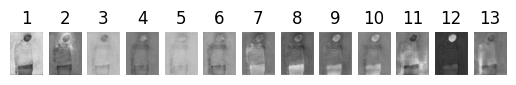

Epoch 0 | Batch 1341 | GenLoss 1.0938873291015625 | DiscLoss 0.000692632922437042
Epoch 0 | Batch 1342 | GenLoss 1.0022525787353516 | DiscLoss 0.0005397545755840838
Epoch 0 | Batch 1343 | GenLoss 1.0421802997589111 | DiscLoss 0.00038705411134287715
Epoch 0 | Batch 1344 | GenLoss 1.024017333984375 | DiscLoss 0.0003483952023088932
Epoch 0 | Batch 1345 | GenLoss 1.1968364715576172 | DiscLoss 0.0003961046750191599
Epoch 0 | Batch 1346 | GenLoss 1.0360323190689087 | DiscLoss 0.000390322384191677
Epoch 0 | Batch 1347 | GenLoss 1.6429052352905273 | DiscLoss 0.0003487980575300753
Epoch 0 | Batch 1348 | GenLoss 1.068540334701538 | DiscLoss 0.0003311843902338296
Epoch 0 | Batch 1349 | GenLoss 1.028548240661621 | DiscLoss 0.00040919799357652664
Epoch 0 | Batch 1350 | GenLoss 1.1254351139068604 | DiscLoss 0.0003407510812394321
Epoch 0 | Batch 1351 | GenLoss 0.9522699117660522 | DiscLoss 0.000369712826795876
Epoch 0 | Batch 1352 | GenLoss 1.1249580383300781 | DiscLoss 0.0003390347119420767
Epoch 0 

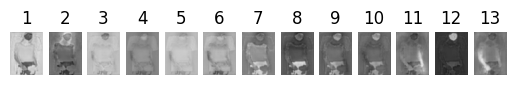

Epoch 0 | Batch 1361 | GenLoss 1.1804249286651611 | DiscLoss 0.0003160505148116499
Epoch 0 | Batch 1362 | GenLoss 1.7421510219573975 | DiscLoss 0.0003574755974113941
Epoch 0 | Batch 1363 | GenLoss 1.2507383823394775 | DiscLoss 0.00033866529702208936
Epoch 0 | Batch 1364 | GenLoss 0.8352210521697998 | DiscLoss 0.00031742959981784225
Epoch 0 | Batch 1365 | GenLoss 1.0165555477142334 | DiscLoss 0.000299736944725737
Epoch 0 | Batch 1366 | GenLoss 1.3402879238128662 | DiscLoss 0.00032669398933649063
Epoch 0 | Batch 1367 | GenLoss 1.3997142314910889 | DiscLoss 0.00043087778612971306
Epoch 0 | Batch 1368 | GenLoss 1.5454587936401367 | DiscLoss 0.0003952800470869988
Epoch 0 | Batch 1369 | GenLoss 1.2707477807998657 | DiscLoss 0.00036083129816688597
Epoch 0 | Batch 1370 | GenLoss 1.2224551439285278 | DiscLoss 0.00044502312084659934
Epoch 0 | Batch 1371 | GenLoss 1.1311891078948975 | DiscLoss 0.0003566209343262017
Epoch 0 | Batch 1372 | GenLoss 1.2521378993988037 | DiscLoss 0.0003331543121021241

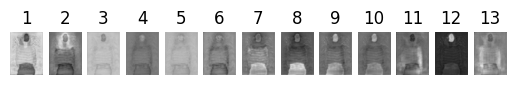

Epoch 0 | Batch 1381 | GenLoss 1.094871997833252 | DiscLoss 0.000284438778180629
Epoch 0 | Batch 1382 | GenLoss 1.4833884239196777 | DiscLoss 0.0003319774114061147
Epoch 0 | Batch 1383 | GenLoss 0.9145238399505615 | DiscLoss 0.0003038176510017365
Epoch 0 | Batch 1384 | GenLoss 0.8327025771141052 | DiscLoss 0.0003050251689273864
Epoch 0 | Batch 1385 | GenLoss 1.1083327531814575 | DiscLoss 0.00029603089205920696
Epoch 0 | Batch 1386 | GenLoss 1.1740756034851074 | DiscLoss 0.00036845667636953294
Epoch 0 | Batch 1387 | GenLoss 1.0898302793502808 | DiscLoss 0.0003111222176812589
Epoch 0 | Batch 1388 | GenLoss 1.4964494705200195 | DiscLoss 0.00034385104663670063
Epoch 0 | Batch 1389 | GenLoss 1.000443935394287 | DiscLoss 0.00034170804428867996
Epoch 0 | Batch 1390 | GenLoss 0.8833788633346558 | DiscLoss 0.0003264864790253341
Epoch 0 | Batch 1391 | GenLoss 2.2392492294311523 | DiscLoss 0.00034114770824089646
Epoch 0 | Batch 1392 | GenLoss 1.1046221256256104 | DiscLoss 0.00032416541944257915
E

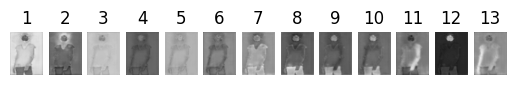

Epoch 0 | Batch 1401 | GenLoss 1.2864749431610107 | DiscLoss 0.0003071630490012467
Epoch 0 | Batch 1402 | GenLoss 1.3033860921859741 | DiscLoss 0.0003448830684646964
Epoch 0 | Batch 1403 | GenLoss 1.2628811597824097 | DiscLoss 0.00033107263152487576
Epoch 0 | Batch 1404 | GenLoss 1.4104714393615723 | DiscLoss 0.00031882975599728525
Epoch 0 | Batch 1405 | GenLoss 1.0580933094024658 | DiscLoss 0.0003545070649124682
Epoch 0 | Batch 1406 | GenLoss 1.141377568244934 | DiscLoss 0.00029244215693324804
Epoch 0 | Batch 1407 | GenLoss 1.3012871742248535 | DiscLoss 0.000332369381794706
Epoch 0 | Batch 1408 | GenLoss 0.9908541440963745 | DiscLoss 0.0003596336755435914
Epoch 0 | Batch 1409 | GenLoss 1.46709144115448 | DiscLoss 0.00043600465869531035
Epoch 0 | Batch 1410 | GenLoss 1.3428237438201904 | DiscLoss 0.0004270102072041482
Epoch 0 | Batch 1411 | GenLoss 0.9070500135421753 | DiscLoss 0.0003051623934879899
Epoch 0 | Batch 1412 | GenLoss 1.2545490264892578 | DiscLoss 0.0004005998489446938
Epoc

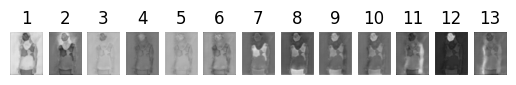

Epoch 0 | Batch 1421 | GenLoss 1.0896799564361572 | DiscLoss 0.0003240655642002821
Epoch 0 | Batch 1422 | GenLoss 1.2294909954071045 | DiscLoss 0.0003143256762996316
Epoch 0 | Batch 1423 | GenLoss 0.8755269050598145 | DiscLoss 0.0003003212041221559
Epoch 0 | Batch 1424 | GenLoss 0.9424984455108643 | DiscLoss 0.0003628784616012126
Epoch 0 | Batch 1425 | GenLoss 0.9234969615936279 | DiscLoss 0.00031520219636149704
Epoch 0 | Batch 1426 | GenLoss 1.0708593130111694 | DiscLoss 0.000328882597386837
Epoch 0 | Batch 1427 | GenLoss 1.172999382019043 | DiscLoss 0.00035682725138030946
Epoch 0 | Batch 1428 | GenLoss 1.1456631422042847 | DiscLoss 0.00041554521885700524
Epoch 0 | Batch 1429 | GenLoss 0.9569717645645142 | DiscLoss 0.0002782540977932513
Epoch 0 | Batch 1430 | GenLoss 0.9695034027099609 | DiscLoss 0.0002731656131800264
Epoch 0 | Batch 1431 | GenLoss 1.1379494667053223 | DiscLoss 0.00032256616395898163
Epoch 0 | Batch 1432 | GenLoss 0.9059029817581177 | DiscLoss 0.00037490122485905886
E

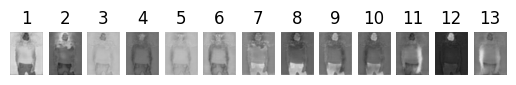

Epoch 0 | Batch 1441 | GenLoss 0.9418013095855713 | DiscLoss 0.0003290784952696413
Epoch 0 | Batch 1442 | GenLoss 1.3876985311508179 | DiscLoss 0.0002992553636431694
Epoch 0 | Batch 1443 | GenLoss 1.4921550750732422 | DiscLoss 0.000365028390660882
Epoch 0 | Batch 1444 | GenLoss 1.1385655403137207 | DiscLoss 0.0003357598325237632
Epoch 0 | Batch 1445 | GenLoss 1.2669199705123901 | DiscLoss 0.0003666531410999596
Epoch 0 | Batch 1446 | GenLoss 1.2806916236877441 | DiscLoss 0.0003176526806782931
Epoch 0 | Batch 1447 | GenLoss 0.7813665270805359 | DiscLoss 0.0003031499800272286
Epoch 0 | Batch 1448 | GenLoss 1.0016088485717773 | DiscLoss 0.00028051057597622275
Epoch 0 | Batch 1449 | GenLoss 0.907820463180542 | DiscLoss 0.0002594928373582661
Epoch 0 | Batch 1450 | GenLoss 1.0203486680984497 | DiscLoss 0.0002887072041630745
Epoch 0 | Batch 1451 | GenLoss 1.2875113487243652 | DiscLoss 0.00034693622728809714
Epoch 0 | Batch 1452 | GenLoss 0.9791922569274902 | DiscLoss 0.0002910182229243219
Epoc

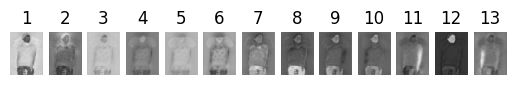

Epoch 0 | Batch 1461 | GenLoss 1.1393051147460938 | DiscLoss 0.0002682376652956009
Epoch 0 | Batch 1462 | GenLoss 1.2111845016479492 | DiscLoss 0.00031146768014878035
Epoch 0 | Batch 1463 | GenLoss 1.3080519437789917 | DiscLoss 0.0002833973558153957
Epoch 0 | Batch 1464 | GenLoss 1.1102852821350098 | DiscLoss 0.0003224722167942673
Epoch 0 | Batch 1465 | GenLoss 0.8382704257965088 | DiscLoss 0.00023628948838450015
Epoch 0 | Batch 1466 | GenLoss 1.7484173774719238 | DiscLoss 0.00026592513313516974
Epoch 0 | Batch 1467 | GenLoss 1.4671568870544434 | DiscLoss 0.00031614344334229827
Epoch 0 | Batch 1468 | GenLoss 1.074548363685608 | DiscLoss 0.00034741550916805863
Epoch 0 | Batch 1469 | GenLoss 0.8151845932006836 | DiscLoss 0.00025833689142018557
Epoch 0 | Batch 1470 | GenLoss 1.0567508935928345 | DiscLoss 0.00025768671184778214
Epoch 0 | Batch 1471 | GenLoss 1.1221797466278076 | DiscLoss 0.0002710190019570291
Epoch 0 | Batch 1472 | GenLoss 1.2460052967071533 | DiscLoss 0.000317292986437678

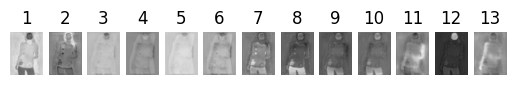

Epoch 0 | Batch 1481 | GenLoss 1.0412051677703857 | DiscLoss 0.0003930329985450953
Epoch 0 | Batch 1482 | GenLoss 0.8711549639701843 | DiscLoss 0.00032181217102333903
Epoch 0 | Batch 1483 | GenLoss 0.8357738256454468 | DiscLoss 0.00041219740523956716
Epoch 0 | Batch 1484 | GenLoss 0.8950966596603394 | DiscLoss 0.0003135389997623861
Epoch 0 | Batch 1485 | GenLoss 0.9080946445465088 | DiscLoss 0.00028470400138758123
Epoch 0 | Batch 1486 | GenLoss 0.9944993257522583 | DiscLoss 0.00031698576640337706
Epoch 0 | Batch 1487 | GenLoss 1.2918128967285156 | DiscLoss 0.00026441412046551704
Epoch 0 | Batch 1488 | GenLoss 1.3673176765441895 | DiscLoss 0.000256397295743227
Epoch 0 | Batch 1489 | GenLoss 0.9095900654792786 | DiscLoss 0.0002816501655615866
Epoch 0 | Batch 1490 | GenLoss 1.11512291431427 | DiscLoss 0.0002510512131266296
Epoch 0 | Batch 1491 | GenLoss 0.9828047752380371 | DiscLoss 0.00026373943546786904
Epoch 0 | Batch 1492 | GenLoss 1.0571283102035522 | DiscLoss 0.0002717648458201438
E

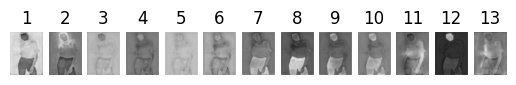

Epoch 0 | Batch 1501 | GenLoss 0.8482288122177124 | DiscLoss 0.00025055825244635344
Epoch 0 | Batch 1502 | GenLoss 0.9595295786857605 | DiscLoss 0.00022491783602163196
Epoch 0 | Batch 1503 | GenLoss 1.0550745725631714 | DiscLoss 0.00025032961275428534
Epoch 0 | Batch 1504 | GenLoss 1.2490559816360474 | DiscLoss 0.00027010205667465925
Epoch 0 | Batch 1505 | GenLoss 1.250198483467102 | DiscLoss 0.0002650422975420952
Epoch 0 | Batch 1506 | GenLoss 0.8436059951782227 | DiscLoss 0.00027963766478933394
Epoch 0 | Batch 1507 | GenLoss 1.4355367422103882 | DiscLoss 0.00026073341723531485
Epoch 0 | Batch 1508 | GenLoss 1.0988364219665527 | DiscLoss 0.00028191140154376626
Epoch 0 | Batch 1509 | GenLoss 0.9236177802085876 | DiscLoss 0.00022341894509736449
Epoch 0 | Batch 1510 | GenLoss 1.3560738563537598 | DiscLoss 0.00031253776978701353
Epoch 0 | Batch 1511 | GenLoss 1.4447922706604004 | DiscLoss 0.0002451141772326082
Epoch 0 | Batch 1512 | GenLoss 1.0564969778060913 | DiscLoss 0.0002624637563712

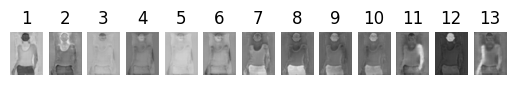

Epoch 0 | Batch 1521 | GenLoss 1.1562632322311401 | DiscLoss 0.00025227185687981546
Epoch 0 | Batch 1522 | GenLoss 1.1755074262619019 | DiscLoss 0.000306545349303633
Epoch 0 | Batch 1523 | GenLoss 1.103719711303711 | DiscLoss 0.00035295524867251515
Epoch 0 | Batch 1524 | GenLoss 0.8349841833114624 | DiscLoss 0.00027858978137373924
Epoch 0 | Batch 1525 | GenLoss 1.0796990394592285 | DiscLoss 0.00033753906609490514
Epoch 0 | Batch 1526 | GenLoss 1.0584425926208496 | DiscLoss 0.00028100746567361057
Epoch 0 | Batch 1527 | GenLoss 0.8916141986846924 | DiscLoss 0.00028961070347577333
Epoch 0 | Batch 1528 | GenLoss 1.0808285474777222 | DiscLoss 0.00027650617994368076
Epoch 0 | Batch 1529 | GenLoss 0.9376093149185181 | DiscLoss 0.00025474579888395965
Epoch 0 | Batch 1530 | GenLoss 0.8638184666633606 | DiscLoss 0.00028265846776776016
Epoch 0 | Batch 1531 | GenLoss 0.938243567943573 | DiscLoss 0.00026878633070737123
Epoch 0 | Batch 1532 | GenLoss 1.1516042947769165 | DiscLoss 0.00025524309603497

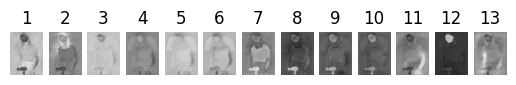

Epoch 0 | Batch 1541 | GenLoss 1.0825743675231934 | DiscLoss 0.0003029904910363257
Epoch 0 | Batch 1542 | GenLoss 1.102508783340454 | DiscLoss 0.00022803989122621715
Epoch 0 | Batch 1543 | GenLoss 1.1709649562835693 | DiscLoss 0.00023761724878568202
Epoch 0 | Batch 1544 | GenLoss 0.971041202545166 | DiscLoss 0.0002337768964935094
Epoch 0 | Batch 1545 | GenLoss 0.844518780708313 | DiscLoss 0.0002721793425735086
Epoch 0 | Batch 1546 | GenLoss 1.3118958473205566 | DiscLoss 0.0002646413922775537
Epoch 0 | Batch 1547 | GenLoss 0.8562700748443604 | DiscLoss 0.0002465537399984896
Epoch 0 | Batch 1548 | GenLoss 0.941468358039856 | DiscLoss 0.00029567047022283077
Epoch 0 | Batch 1549 | GenLoss 0.987398624420166 | DiscLoss 0.0002661989419721067
Epoch 0 | Batch 1550 | GenLoss 0.8598232269287109 | DiscLoss 0.0002264611393911764
Epoch 0 | Batch 1551 | GenLoss 1.1597262620925903 | DiscLoss 0.0002790975267998874
Epoch 0 | Batch 1552 | GenLoss 1.1250123977661133 | DiscLoss 0.00022431457182392478
Epoch

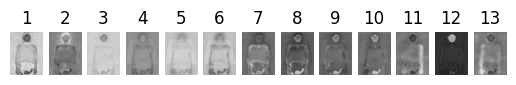

Epoch 0 | Batch 1561 | GenLoss 0.8553379774093628 | DiscLoss 0.0002476471709087491
Epoch 0 | Batch 1562 | GenLoss 0.9227918982505798 | DiscLoss 0.00030720530776306987
Epoch 0 | Batch 1563 | GenLoss 0.8401885032653809 | DiscLoss 0.00022075799643062055
Epoch 0 | Batch 1564 | GenLoss 1.113932728767395 | DiscLoss 0.00023079686798155308
Epoch 0 | Batch 1565 | GenLoss 1.0038962364196777 | DiscLoss 0.0003974858555011451
Epoch 0 | Batch 1566 | GenLoss 0.8975198268890381 | DiscLoss 0.0002954682568088174
Epoch 0 | Batch 1567 | GenLoss 0.7678475379943848 | DiscLoss 0.00025270169135183096
Epoch 0 | Batch 1568 | GenLoss 0.9715957641601562 | DiscLoss 0.00024711815058253706
Epoch 0 | Batch 1569 | GenLoss 0.8455562591552734 | DiscLoss 0.0002813503670040518
Epoch 0 | Batch 1570 | GenLoss 1.0307199954986572 | DiscLoss 0.00020733207929879427
Epoch 0 | Batch 1571 | GenLoss 0.9515424966812134 | DiscLoss 0.0002805983240250498
Epoch 0 | Batch 1572 | GenLoss 0.9202083349227905 | DiscLoss 0.0002316735917702317

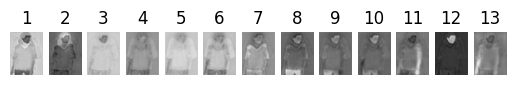

Epoch 0 | Batch 1581 | GenLoss 1.1114705801010132 | DiscLoss 0.0002896624500863254
Epoch 0 | Batch 1582 | GenLoss 0.7680343389511108 | DiscLoss 0.00023016429622657597
Epoch 0 | Batch 1583 | GenLoss 1.0423873662948608 | DiscLoss 0.00022262604034040123
Epoch 0 | Batch 1584 | GenLoss 1.740934133529663 | DiscLoss 0.00024683994706720114
Epoch 0 | Batch 1585 | GenLoss 0.8571128845214844 | DiscLoss 0.00021417258540168405
Epoch 0 | Batch 1586 | GenLoss 1.2584340572357178 | DiscLoss 0.00022730627097189426
Epoch 0 | Batch 1587 | GenLoss 1.3337781429290771 | DiscLoss 0.0002493605425115675
Epoch 0 | Batch 1588 | GenLoss 0.9323333501815796 | DiscLoss 0.00021852884674444795
Epoch 0 | Batch 1589 | GenLoss 1.0453581809997559 | DiscLoss 0.00024423946160823107
Epoch 0 | Batch 1590 | GenLoss 0.7846664190292358 | DiscLoss 0.00023874953330960125
Epoch 0 | Batch 1591 | GenLoss 0.8062416315078735 | DiscLoss 0.00024570722598582506
Epoch 0 | Batch 1592 | GenLoss 1.4605212211608887 | DiscLoss 0.0004305741749703

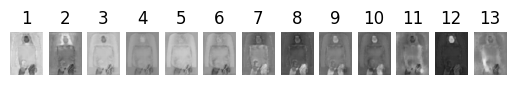

Epoch 0 | Batch 1601 | GenLoss 0.8359217643737793 | DiscLoss 0.0002133563975803554
Epoch 0 | Batch 1602 | GenLoss 0.9219073057174683 | DiscLoss 0.0002596162958070636
Epoch 0 | Batch 1603 | GenLoss 1.3046159744262695 | DiscLoss 0.0002501785638742149
Epoch 0 | Batch 1604 | GenLoss 0.7294495105743408 | DiscLoss 0.00024745764676481485
Epoch 0 | Batch 1605 | GenLoss 0.892184317111969 | DiscLoss 0.00028120947536081076
Epoch 0 | Batch 1606 | GenLoss 0.8601106405258179 | DiscLoss 0.00026789799449034035
Epoch 0 | Batch 1607 | GenLoss 0.882381796836853 | DiscLoss 0.00024106081400532275
Epoch 0 | Batch 1608 | GenLoss 1.8926458358764648 | DiscLoss 0.0003795214288402349
Epoch 0 | Batch 1609 | GenLoss 0.9183987379074097 | DiscLoss 0.00027881155256181955
Epoch 0 | Batch 1610 | GenLoss 1.2486343383789062 | DiscLoss 0.0003015183610841632
Epoch 0 | Batch 1611 | GenLoss 1.6472926139831543 | DiscLoss 0.00028961547650396824
Epoch 0 | Batch 1612 | GenLoss 1.6822080612182617 | DiscLoss 0.0002559034328442067


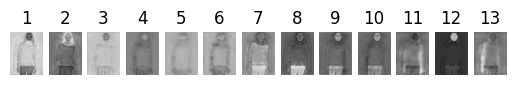

Epoch 0 | Batch 1621 | GenLoss 0.7288127541542053 | DiscLoss 0.00021688079868908972
Epoch 0 | Batch 1622 | GenLoss 0.9739717245101929 | DiscLoss 0.00024872261565178633
Epoch 0 | Batch 1623 | GenLoss 1.3179972171783447 | DiscLoss 0.00026275526033714414
Epoch 0 | Batch 1624 | GenLoss 1.0529097318649292 | DiscLoss 0.0002182117896154523
Epoch 0 | Batch 1625 | GenLoss 0.9816229343414307 | DiscLoss 0.000251572608249262
Epoch 0 | Batch 1626 | GenLoss 1.145196557044983 | DiscLoss 0.0002507720491848886
Epoch 0 | Batch 1627 | GenLoss 0.9388181567192078 | DiscLoss 0.00027321750530973077
Epoch 0 | Batch 1628 | GenLoss 0.9272575378417969 | DiscLoss 0.0002426525898044929
Epoch 0 | Batch 1629 | GenLoss 1.0663962364196777 | DiscLoss 0.0002726176171563566
Epoch 0 | Batch 1630 | GenLoss 0.9318565130233765 | DiscLoss 0.00026964335120283067
Epoch 0 | Batch 1631 | GenLoss 1.041420817375183 | DiscLoss 0.000245147617533803
Epoch 0 | Batch 1632 | GenLoss 1.1809667348861694 | DiscLoss 0.000264633446931839
Epoc

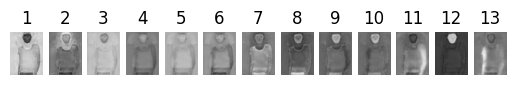

Epoch 0 | Batch 1641 | GenLoss 1.0198229551315308 | DiscLoss 0.00022494701261166483
Epoch 0 | Batch 1642 | GenLoss 1.1337429285049438 | DiscLoss 0.00026588927721604705
Epoch 0 | Batch 1643 | GenLoss 0.8376760482788086 | DiscLoss 0.00033244810765609145
Epoch 0 | Batch 1644 | GenLoss 1.4186456203460693 | DiscLoss 0.0002608330687507987
Epoch 0 | Batch 1645 | GenLoss 1.2252365350723267 | DiscLoss 0.00024131190730258822
Epoch 0 | Batch 1646 | GenLoss 1.0371367931365967 | DiscLoss 0.00070493872044608
Epoch 0 | Batch 1647 | GenLoss 0.8648073673248291 | DiscLoss 0.0002976631512865424
Epoch 0 | Batch 1648 | GenLoss 0.6975769400596619 | DiscLoss 0.0002670204848982394
Epoch 0 | Batch 1649 | GenLoss 0.7289066314697266 | DiscLoss 0.00024051388027146459
Epoch 0 | Batch 1650 | GenLoss 1.065000295639038 | DiscLoss 0.0002670017711352557
Epoch 0 | Batch 1651 | GenLoss 1.3964054584503174 | DiscLoss 0.00026379909832030535
Epoch 0 | Batch 1652 | GenLoss 0.8891068696975708 | DiscLoss 0.0002672936534509063
E

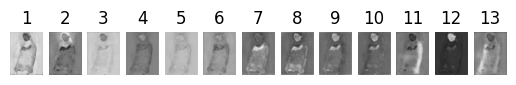

Epoch 0 | Batch 1661 | GenLoss 1.013046383857727 | DiscLoss 0.00024304247926920652
Epoch 0 | Batch 1662 | GenLoss 0.8554449081420898 | DiscLoss 0.000351541064446792
Epoch 0 | Batch 1663 | GenLoss 1.1513757705688477 | DiscLoss 0.00023989492910914123
Epoch 0 | Batch 1664 | GenLoss 0.9582865238189697 | DiscLoss 0.0002693635178729892
Epoch 0 | Batch 1665 | GenLoss 1.0280832052230835 | DiscLoss 0.0002640897291712463
Epoch 0 | Batch 1666 | GenLoss 0.8825265169143677 | DiscLoss 0.0002221518661826849
Epoch 0 | Batch 1667 | GenLoss 1.3814237117767334 | DiscLoss 0.00025746910250745714
Epoch 0 | Batch 1668 | GenLoss 1.0180854797363281 | DiscLoss 0.00028337183175608516
Epoch 0 | Batch 1669 | GenLoss 0.9879839420318604 | DiscLoss 0.00026437226915732026
Epoch 0 | Batch 1670 | GenLoss 1.4465105533599854 | DiscLoss 0.00026422456721775234
Epoch 0 | Batch 1671 | GenLoss 1.312000036239624 | DiscLoss 0.00021031151118222624
Epoch 0 | Batch 1672 | GenLoss 1.3521840572357178 | DiscLoss 0.0002482620475348085


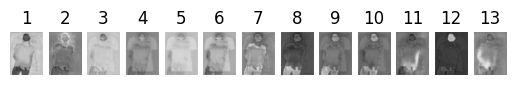

Epoch 0 | Batch 1681 | GenLoss 0.8831136226654053 | DiscLoss 0.0002886717556975782
Epoch 0 | Batch 1682 | GenLoss 0.9105622172355652 | DiscLoss 0.0002378207427682355
Epoch 0 | Batch 1683 | GenLoss 1.671454906463623 | DiscLoss 0.0002345448883716017
Epoch 0 | Batch 1684 | GenLoss 0.8937363624572754 | DiscLoss 0.00022494963195640594
Epoch 0 | Batch 1685 | GenLoss 0.9823664426803589 | DiscLoss 0.00018420233391225338
Epoch 0 | Batch 1686 | GenLoss 0.9525631666183472 | DiscLoss 0.00021460818243212998
Epoch 0 | Batch 1687 | GenLoss 1.4156394004821777 | DiscLoss 0.00041012128349393606
Epoch 0 | Batch 1688 | GenLoss 0.8142625093460083 | DiscLoss 0.00021491179359145463
Epoch 0 | Batch 1689 | GenLoss 0.7483228445053101 | DiscLoss 0.00022300217824522406
Epoch 0 | Batch 1690 | GenLoss 0.94730544090271 | DiscLoss 0.0002132093213731423
Epoch 0 | Batch 1691 | GenLoss 1.1328201293945312 | DiscLoss 0.0002450356842018664
Epoch 0 | Batch 1692 | GenLoss 0.7820204496383667 | DiscLoss 0.00022952171275392175


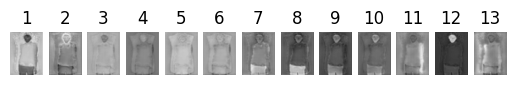

Epoch 0 | Batch 1701 | GenLoss 0.9446018934249878 | DiscLoss 0.00019252841593697667
Epoch 0 | Batch 1702 | GenLoss 0.7294720411300659 | DiscLoss 0.0002056545199593529
Epoch 0 | Batch 1703 | GenLoss 1.11915922164917 | DiscLoss 0.00028131718863733113
Epoch 0 | Batch 1704 | GenLoss 1.1498157978057861 | DiscLoss 0.00026154459919780493
Epoch 0 | Batch 1705 | GenLoss 0.8411620855331421 | DiscLoss 0.00019209635502193123
Epoch 0 | Batch 1706 | GenLoss 1.0856565237045288 | DiscLoss 0.0002613104006741196
Epoch 0 | Batch 1707 | GenLoss 1.0379054546356201 | DiscLoss 0.000211468999623321
Epoch 0 | Batch 1708 | GenLoss 0.8568381071090698 | DiscLoss 0.00019761925796046853
Epoch 0 | Batch 1709 | GenLoss 0.8762966394424438 | DiscLoss 0.00021595240104943514
Epoch 0 | Batch 1710 | GenLoss 1.1615772247314453 | DiscLoss 0.00018244498642161489
Epoch 0 | Batch 1711 | GenLoss 0.8492382764816284 | DiscLoss 0.0001875933085102588
Epoch 0 | Batch 1712 | GenLoss 0.9295631647109985 | DiscLoss 0.00019581221567932516

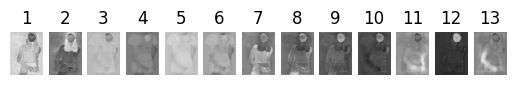

Epoch 0 | Batch 1721 | GenLoss 0.8992036581039429 | DiscLoss 0.00022321291908156127
Epoch 0 | Batch 1722 | GenLoss 1.1392242908477783 | DiscLoss 0.00024174530699383467
Epoch 0 | Batch 1723 | GenLoss 1.3620251417160034 | DiscLoss 0.00021572021069005132
Epoch 0 | Batch 1724 | GenLoss 0.9412237405776978 | DiscLoss 0.00020737266459036618
Epoch 0 | Batch 1725 | GenLoss 0.9718037843704224 | DiscLoss 0.0002684351638890803
Epoch 0 | Batch 1726 | GenLoss 1.024770736694336 | DiscLoss 0.00020446159760467708
Epoch 0 | Batch 1727 | GenLoss 0.6517508029937744 | DiscLoss 0.0001822981721488759
Epoch 0 | Batch 1728 | GenLoss 0.9943532943725586 | DiscLoss 0.00016724574379622936
Epoch 0 | Batch 1729 | GenLoss 1.6392368078231812 | DiscLoss 0.00023785933444742113
Epoch 0 | Batch 1730 | GenLoss 0.9778064489364624 | DiscLoss 0.0001806738437153399
Epoch 0 | Batch 1731 | GenLoss 0.9351768493652344 | DiscLoss 0.00019080284982919693
Epoch 0 | Batch 1732 | GenLoss 1.0471032857894897 | DiscLoss 0.00021748681319877

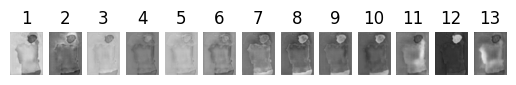

Epoch 0 | Batch 1741 | GenLoss 1.1205823421478271 | DiscLoss 0.00020540320838335901
Epoch 0 | Batch 1742 | GenLoss 1.2374659776687622 | DiscLoss 0.00024338300863746554
Epoch 0 | Batch 1743 | GenLoss 0.7828332185745239 | DiscLoss 0.00021059221762698144
Epoch 0 | Batch 1744 | GenLoss 0.9856991767883301 | DiscLoss 0.0002488583268132061
Epoch 0 | Batch 1745 | GenLoss 1.0115869045257568 | DiscLoss 0.00022810418158769608
Epoch 0 | Batch 1746 | GenLoss 1.0116593837738037 | DiscLoss 0.00017815017781686038
Epoch 0 | Batch 1747 | GenLoss 0.8652782440185547 | DiscLoss 0.00018571631517261267
Epoch 0 | Batch 1748 | GenLoss 1.088794469833374 | DiscLoss 0.0002474163775332272
Epoch 0 | Batch 1749 | GenLoss 1.2339316606521606 | DiscLoss 0.00024972695973701775
Epoch 0 | Batch 1750 | GenLoss 1.0077890157699585 | DiscLoss 0.00020311729167588055
Epoch 0 | Batch 1751 | GenLoss 0.9814300537109375 | DiscLoss 0.00019535332103259861
Epoch 0 | Batch 1752 | GenLoss 0.9350055456161499 | DiscLoss 0.0002175940317101

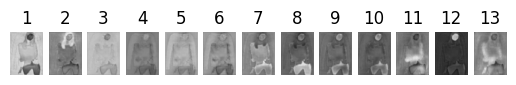

Epoch 0 | Batch 1761 | GenLoss 1.0589462518692017 | DiscLoss 0.00022363137395586818
Epoch 0 | Batch 1762 | GenLoss 1.30869722366333 | DiscLoss 0.0001909885904751718
Epoch 0 | Batch 1763 | GenLoss 0.9592403173446655 | DiscLoss 0.0002502732095308602
Epoch 0 | Batch 1764 | GenLoss 1.0469424724578857 | DiscLoss 0.00023098578094504774
Epoch 0 | Batch 1765 | GenLoss 1.0658769607543945 | DiscLoss 0.00020233815303072333
Epoch 0 | Batch 1766 | GenLoss 0.9396251440048218 | DiscLoss 0.00021357156219892204
Epoch 0 | Batch 1767 | GenLoss 1.050964593887329 | DiscLoss 0.00020235622650943696
Epoch 0 | Batch 1768 | GenLoss 0.9752249717712402 | DiscLoss 0.00022047144011594355
Epoch 0 | Batch 1769 | GenLoss 0.7598788738250732 | DiscLoss 0.00022287342289928347
Epoch 0 | Batch 1770 | GenLoss 0.9004383087158203 | DiscLoss 0.00021441621356643736
Epoch 1 | Batch 0 | GenLoss 1.3795242309570312 | DiscLoss 0.0002988413325510919


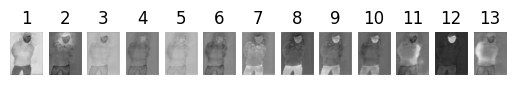

Epoch 1 | Batch 1 | GenLoss 0.8182659149169922 | DiscLoss 0.0003163797955494374
Epoch 1 | Batch 2 | GenLoss 0.7491081953048706 | DiscLoss 0.00021885643946006894
Epoch 1 | Batch 3 | GenLoss 0.7648685574531555 | DiscLoss 0.0002509834012016654
Epoch 1 | Batch 4 | GenLoss 0.8618481159210205 | DiscLoss 0.00028361534350551665
Epoch 1 | Batch 5 | GenLoss 0.9410332441329956 | DiscLoss 0.0002634763077367097
Epoch 1 | Batch 6 | GenLoss 1.1934802532196045 | DiscLoss 0.0003105870564468205
Epoch 1 | Batch 7 | GenLoss 1.0756381750106812 | DiscLoss 0.00026123353745788336
Epoch 1 | Batch 8 | GenLoss 0.9603160619735718 | DiscLoss 0.0002058733080048114
Epoch 1 | Batch 9 | GenLoss 0.8078991770744324 | DiscLoss 0.0002120217541232705
Epoch 1 | Batch 10 | GenLoss 0.6949954628944397 | DiscLoss 0.00021336319332476705
Epoch 1 | Batch 11 | GenLoss 1.0059471130371094 | DiscLoss 0.00022147067647892982
Epoch 1 | Batch 12 | GenLoss 1.2260113954544067 | DiscLoss 0.0003111566766165197
Epoch 1 | Batch 13 | GenLoss 0.9

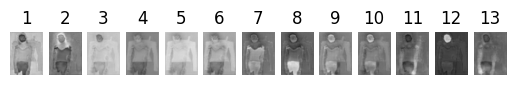

Epoch 1 | Batch 21 | GenLoss 0.7420718669891357 | DiscLoss 0.0002052553609246388
Epoch 1 | Batch 22 | GenLoss 0.8781182765960693 | DiscLoss 0.0002550918434280902
Epoch 1 | Batch 23 | GenLoss 2.0220775604248047 | DiscLoss 0.00032360016484744847
Epoch 1 | Batch 24 | GenLoss 1.100258708000183 | DiscLoss 0.00035041937371715903
Epoch 1 | Batch 25 | GenLoss 0.7518920302391052 | DiscLoss 0.0002106888423440978
Epoch 1 | Batch 26 | GenLoss 1.1188467741012573 | DiscLoss 0.00023459779913537204
Epoch 1 | Batch 27 | GenLoss 0.7535295486450195 | DiscLoss 0.00023536030494142324
Epoch 1 | Batch 28 | GenLoss 0.8539834022521973 | DiscLoss 0.00018963504408020526
Epoch 1 | Batch 29 | GenLoss 0.8488143682479858 | DiscLoss 0.0001881495991256088
Epoch 1 | Batch 30 | GenLoss 0.9360455870628357 | DiscLoss 0.00021131744142621756
Epoch 1 | Batch 31 | GenLoss 0.9896018505096436 | DiscLoss 0.00019431060354691
Epoch 1 | Batch 32 | GenLoss 0.7106945514678955 | DiscLoss 0.0001645886222831905
Epoch 1 | Batch 33 | GenL

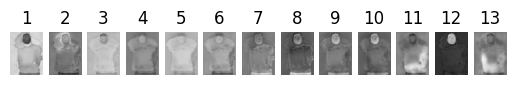

Epoch 1 | Batch 41 | GenLoss 1.3342361450195312 | DiscLoss 0.0002081876154989004
Epoch 1 | Batch 42 | GenLoss 1.0746710300445557 | DiscLoss 0.0002625139313749969
Epoch 1 | Batch 43 | GenLoss 0.9639167785644531 | DiscLoss 0.00023393657465931028
Epoch 1 | Batch 44 | GenLoss 1.1813424825668335 | DiscLoss 0.00025021759211085737
Epoch 1 | Batch 45 | GenLoss 1.1714556217193604 | DiscLoss 0.00026846694527193904
Epoch 1 | Batch 46 | GenLoss 0.8110606074333191 | DiscLoss 0.00018633698346093297
Epoch 1 | Batch 47 | GenLoss 0.8837594985961914 | DiscLoss 0.00017031849711202085
Epoch 1 | Batch 48 | GenLoss 1.1676208972930908 | DiscLoss 0.00028315803501755
Epoch 1 | Batch 49 | GenLoss 0.8978068828582764 | DiscLoss 0.00016286321624647826
Epoch 1 | Batch 50 | GenLoss 0.7346488237380981 | DiscLoss 0.00018688417912926525
Epoch 1 | Batch 51 | GenLoss 0.9865673780441284 | DiscLoss 0.00019920404884032905
Epoch 1 | Batch 52 | GenLoss 0.8118729591369629 | DiscLoss 0.00018418944091536105
Epoch 1 | Batch 53 | 

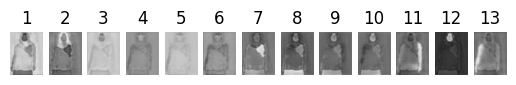

Epoch 1 | Batch 61 | GenLoss 1.1313878297805786 | DiscLoss 0.00018697080668061972
Epoch 1 | Batch 62 | GenLoss 0.6968199610710144 | DiscLoss 0.0002467792946845293
Epoch 1 | Batch 63 | GenLoss 0.9385590553283691 | DiscLoss 0.00024330308951903135
Epoch 1 | Batch 64 | GenLoss 0.8022552728652954 | DiscLoss 0.00020080123795196414
Epoch 1 | Batch 65 | GenLoss 0.7875105738639832 | DiscLoss 0.00015652657020837069
Epoch 1 | Batch 66 | GenLoss 0.8531608581542969 | DiscLoss 0.0001819920289563015
Epoch 1 | Batch 67 | GenLoss 0.8961236476898193 | DiscLoss 0.00017741422925610095
Epoch 1 | Batch 68 | GenLoss 0.9419288635253906 | DiscLoss 0.0002187440695706755
Epoch 1 | Batch 69 | GenLoss 0.7509687542915344 | DiscLoss 0.0001824593637138605
Epoch 1 | Batch 70 | GenLoss 1.0684211254119873 | DiscLoss 0.0001548278669361025
Epoch 1 | Batch 71 | GenLoss 0.7499233484268188 | DiscLoss 0.0001720047148410231
Epoch 1 | Batch 72 | GenLoss 1.1084353923797607 | DiscLoss 0.00019415083806961775
Epoch 1 | Batch 73 | G

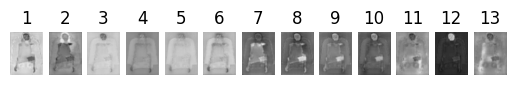

Epoch 1 | Batch 81 | GenLoss 1.0678646564483643 | DiscLoss 0.00018870524945668876
Epoch 1 | Batch 82 | GenLoss 1.0135613679885864 | DiscLoss 0.00019271328346803784
Epoch 1 | Batch 83 | GenLoss 0.9474801421165466 | DiscLoss 0.0002169762592529878
Epoch 1 | Batch 84 | GenLoss 1.3126435279846191 | DiscLoss 0.00021833613573107868
Epoch 1 | Batch 85 | GenLoss 0.9177886247634888 | DiscLoss 0.00022046685626264662
Epoch 1 | Batch 86 | GenLoss 0.7557289600372314 | DiscLoss 0.00018676789477467537
Epoch 1 | Batch 87 | GenLoss 0.7890689373016357 | DiscLoss 0.0002597355633042753
Epoch 1 | Batch 88 | GenLoss 0.9849199056625366 | DiscLoss 0.00022804005129728466
Epoch 1 | Batch 89 | GenLoss 1.0277457237243652 | DiscLoss 0.00022635035566054285
Epoch 1 | Batch 90 | GenLoss 0.9928097724914551 | DiscLoss 0.00020906049758195877
Epoch 1 | Batch 91 | GenLoss 1.2096519470214844 | DiscLoss 0.00023342555505223572
Epoch 1 | Batch 92 | GenLoss 0.8554351329803467 | DiscLoss 0.0005761385546065867
Epoch 1 | Batch 93 

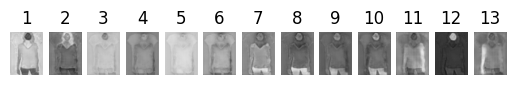

Epoch 1 | Batch 101 | GenLoss 1.235826849937439 | DiscLoss 0.00024265378306154162
Epoch 1 | Batch 102 | GenLoss 0.8668449521064758 | DiscLoss 0.0002317664766451344
Epoch 1 | Batch 103 | GenLoss 0.7934420704841614 | DiscLoss 0.00022192715550772846
Epoch 1 | Batch 104 | GenLoss 0.7912358641624451 | DiscLoss 0.0002452661865390837
Epoch 1 | Batch 105 | GenLoss 0.969757080078125 | DiscLoss 0.00019465270452201366
Epoch 1 | Batch 106 | GenLoss 0.8545719385147095 | DiscLoss 0.00019020368927158415
Epoch 1 | Batch 107 | GenLoss 0.8740555047988892 | DiscLoss 0.0002028246090048924
Epoch 1 | Batch 108 | GenLoss 0.7820188403129578 | DiscLoss 0.0001737350830808282
Epoch 1 | Batch 109 | GenLoss 0.9083095192909241 | DiscLoss 0.00020378529734443873
Epoch 1 | Batch 110 | GenLoss 1.010103464126587 | DiscLoss 0.00021024927264079452
Epoch 1 | Batch 111 | GenLoss 1.4729692935943604 | DiscLoss 0.00025320472195744514
Epoch 1 | Batch 112 | GenLoss 0.6858614087104797 | DiscLoss 0.00018315673514734954
Epoch 1 | B

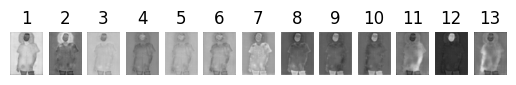

Epoch 1 | Batch 121 | GenLoss 0.7694219946861267 | DiscLoss 0.00017658174328971654
Epoch 1 | Batch 122 | GenLoss 0.9022550582885742 | DiscLoss 0.00018830251065082848
Epoch 1 | Batch 123 | GenLoss 1.099755048751831 | DiscLoss 0.00017891923198476434
Epoch 1 | Batch 124 | GenLoss 1.3461428880691528 | DiscLoss 0.00021402852144092321
Epoch 1 | Batch 125 | GenLoss 0.9348653554916382 | DiscLoss 0.00025211728643625975
Epoch 1 | Batch 126 | GenLoss 0.9298290014266968 | DiscLoss 0.00034350453643128276
Epoch 1 | Batch 127 | GenLoss 0.7387571930885315 | DiscLoss 0.000213670136872679
Epoch 1 | Batch 128 | GenLoss 1.0940864086151123 | DiscLoss 0.00029622187139466405
Epoch 1 | Batch 129 | GenLoss 1.2219338417053223 | DiscLoss 0.0002553736267145723
Epoch 1 | Batch 130 | GenLoss 0.7043992280960083 | DiscLoss 0.0002040195104200393
Epoch 1 | Batch 131 | GenLoss 1.0137991905212402 | DiscLoss 0.0002584177127573639
Epoch 1 | Batch 132 | GenLoss 1.0739799737930298 | DiscLoss 0.00021803463459946215
Epoch 1 | 

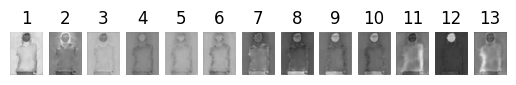

Epoch 1 | Batch 141 | GenLoss 0.8391009569168091 | DiscLoss 0.00018088954675476998
Epoch 1 | Batch 142 | GenLoss 0.6989079117774963 | DiscLoss 0.0001549624721519649
Epoch 1 | Batch 143 | GenLoss 0.8785486221313477 | DiscLoss 0.00018754978373181075
Epoch 1 | Batch 144 | GenLoss 1.7766313552856445 | DiscLoss 0.00018960851593874395
Epoch 1 | Batch 145 | GenLoss 0.791080892086029 | DiscLoss 0.0001966270647244528
Epoch 1 | Batch 146 | GenLoss 0.801278829574585 | DiscLoss 0.00017462356481701136
Epoch 1 | Batch 147 | GenLoss 0.9721357822418213 | DiscLoss 0.00017566815949976444
Epoch 1 | Batch 148 | GenLoss 0.9045069217681885 | DiscLoss 0.00017780790221877396
Epoch 1 | Batch 149 | GenLoss 0.8729569911956787 | DiscLoss 0.0001416586892446503
Epoch 1 | Batch 150 | GenLoss 1.022524118423462 | DiscLoss 0.00022887313389219344
Epoch 1 | Batch 151 | GenLoss 0.6130605340003967 | DiscLoss 0.00014883256517350674
Epoch 1 | Batch 152 | GenLoss 0.8910416960716248 | DiscLoss 0.0002151209773728624
Epoch 1 | B

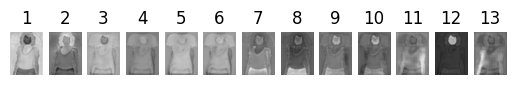

Epoch 1 | Batch 161 | GenLoss 0.676758885383606 | DiscLoss 0.00019726228492800146
Epoch 1 | Batch 162 | GenLoss 1.0742100477218628 | DiscLoss 0.0002201494062319398
Epoch 1 | Batch 163 | GenLoss 1.359351634979248 | DiscLoss 0.0001742281165206805
Epoch 1 | Batch 164 | GenLoss 0.7416775822639465 | DiscLoss 0.00015601058839820325
Epoch 1 | Batch 165 | GenLoss 0.9032775163650513 | DiscLoss 0.00016104994574561715
Epoch 1 | Batch 166 | GenLoss 0.872877836227417 | DiscLoss 0.0002058616082649678
Epoch 1 | Batch 167 | GenLoss 0.8995157480239868 | DiscLoss 0.00021591680706478655
Epoch 1 | Batch 168 | GenLoss 0.982324481010437 | DiscLoss 0.0001801118633011356
Epoch 1 | Batch 169 | GenLoss 0.9415936470031738 | DiscLoss 0.00018176258890889585
Epoch 1 | Batch 170 | GenLoss 0.6523499488830566 | DiscLoss 0.00016780078294686973
Epoch 1 | Batch 171 | GenLoss 0.9432036876678467 | DiscLoss 0.0002043252025032416
Epoch 1 | Batch 172 | GenLoss 1.0506136417388916 | DiscLoss 0.00020729147945530713
Epoch 1 | Bat

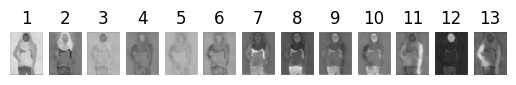

Epoch 1 | Batch 181 | GenLoss 0.9584029912948608 | DiscLoss 0.00019058803445659578
Epoch 1 | Batch 182 | GenLoss 0.6703541278839111 | DiscLoss 0.00016804307233542204
Epoch 1 | Batch 183 | GenLoss 0.8069392442703247 | DiscLoss 0.00019564379181247205
Epoch 1 | Batch 184 | GenLoss 0.8303812146186829 | DiscLoss 0.00019178405636921525
Epoch 1 | Batch 185 | GenLoss 1.0950424671173096 | DiscLoss 0.00018887464830186218
Epoch 1 | Batch 186 | GenLoss 0.7291525602340698 | DiscLoss 0.00018257541523780674
Epoch 1 | Batch 187 | GenLoss 1.2035868167877197 | DiscLoss 0.0002421456010779366
Epoch 1 | Batch 188 | GenLoss 0.6879373788833618 | DiscLoss 0.00016330013750120997
Epoch 1 | Batch 189 | GenLoss 0.9539018869400024 | DiscLoss 0.0001691757352091372
Epoch 1 | Batch 190 | GenLoss 0.8638495206832886 | DiscLoss 0.00021521917369682342
Epoch 1 | Batch 191 | GenLoss 0.7995094060897827 | DiscLoss 0.00021860904234927148
Epoch 1 | Batch 192 | GenLoss 0.8711141347885132 | DiscLoss 0.00022265796724241227
Epoch 

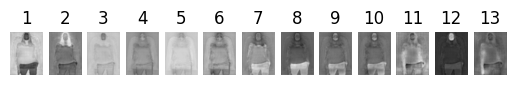

Epoch 1 | Batch 201 | GenLoss 0.8193386197090149 | DiscLoss 0.00015600754704792053
Epoch 1 | Batch 202 | GenLoss 1.1080358028411865 | DiscLoss 0.00016131186566781253
Epoch 1 | Batch 203 | GenLoss 0.74919193983078 | DiscLoss 0.0001375496940454468
Epoch 1 | Batch 204 | GenLoss 0.752302885055542 | DiscLoss 0.0001499103964306414
Epoch 1 | Batch 205 | GenLoss 0.744979977607727 | DiscLoss 0.0001487702247686684
Epoch 1 | Batch 206 | GenLoss 1.0596327781677246 | DiscLoss 0.00020048749865964055
Epoch 1 | Batch 207 | GenLoss 0.7503277063369751 | DiscLoss 0.0001343830954283476
Epoch 1 | Batch 208 | GenLoss 1.0073833465576172 | DiscLoss 0.0001304937177337706
Epoch 1 | Batch 209 | GenLoss 1.0657708644866943 | DiscLoss 0.00017551012570038438
Epoch 1 | Batch 210 | GenLoss 0.7978521585464478 | DiscLoss 0.00014724147331435233
Epoch 1 | Batch 211 | GenLoss 1.2868058681488037 | DiscLoss 0.00018890717183239758
Epoch 1 | Batch 212 | GenLoss 1.3815171718597412 | DiscLoss 0.00018520397134125233
Epoch 1 | Bat

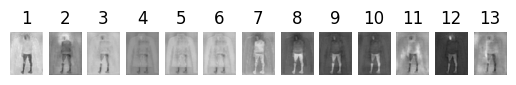

Epoch 1 | Batch 221 | GenLoss 0.7889063358306885 | DiscLoss 0.00014826268306933343
Epoch 1 | Batch 222 | GenLoss 1.0779087543487549 | DiscLoss 0.00017016820493154228
Epoch 1 | Batch 223 | GenLoss 0.876419186592102 | DiscLoss 0.00015951372915878892
Epoch 1 | Batch 224 | GenLoss 1.0203081369400024 | DiscLoss 0.00020045223936904222
Epoch 1 | Batch 225 | GenLoss 0.919148325920105 | DiscLoss 0.00016173202311620116
Epoch 1 | Batch 226 | GenLoss 1.3059192895889282 | DiscLoss 0.00015014802920632064
Epoch 1 | Batch 227 | GenLoss 1.045920491218567 | DiscLoss 0.0002076002856483683
Epoch 1 | Batch 228 | GenLoss 0.9249711036682129 | DiscLoss 0.00013890632544644177
Epoch 1 | Batch 229 | GenLoss 1.0482885837554932 | DiscLoss 0.0001607465819688514
Epoch 1 | Batch 230 | GenLoss 0.8586817979812622 | DiscLoss 0.00014217759598977864
Epoch 1 | Batch 231 | GenLoss 0.8252923488616943 | DiscLoss 0.00014553917571902275
Epoch 1 | Batch 232 | GenLoss 0.8196038007736206 | DiscLoss 0.00013137752830516547
Epoch 1 |

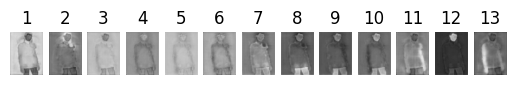

Epoch 1 | Batch 241 | GenLoss 0.8862491846084595 | DiscLoss 0.0001350754318991676
Epoch 1 | Batch 242 | GenLoss 1.3510620594024658 | DiscLoss 0.00016603159019723535
Epoch 1 | Batch 243 | GenLoss 1.0252552032470703 | DiscLoss 0.0002480148687027395
Epoch 1 | Batch 244 | GenLoss 0.915643572807312 | DiscLoss 0.0001707059273030609
Epoch 1 | Batch 245 | GenLoss 1.3548197746276855 | DiscLoss 0.00018179212929680943
Epoch 1 | Batch 246 | GenLoss 0.8630169630050659 | DiscLoss 0.00016242705169133842
Epoch 1 | Batch 247 | GenLoss 0.806732177734375 | DiscLoss 0.0001596971123944968
Epoch 1 | Batch 248 | GenLoss 0.7495537400245667 | DiscLoss 0.00014359105261974037
Epoch 1 | Batch 249 | GenLoss 0.934479832649231 | DiscLoss 0.00016055701416917145
Epoch 1 | Batch 250 | GenLoss 0.8246220350265503 | DiscLoss 0.0001493603631388396
Epoch 1 | Batch 251 | GenLoss 1.0686185359954834 | DiscLoss 0.00016991574375424534
Epoch 1 | Batch 252 | GenLoss 0.7612352967262268 | DiscLoss 0.00014556455425918102
Epoch 1 | Ba

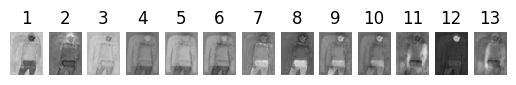

Epoch 1 | Batch 261 | GenLoss 0.800346851348877 | DiscLoss 0.00012455674004741013
Epoch 1 | Batch 262 | GenLoss 1.1679632663726807 | DiscLoss 0.00018123845802620053
Epoch 1 | Batch 263 | GenLoss 0.7211890816688538 | DiscLoss 0.0001702659938018769
Epoch 1 | Batch 264 | GenLoss 0.894542932510376 | DiscLoss 0.00014389678835868835
Epoch 1 | Batch 265 | GenLoss 1.0436564683914185 | DiscLoss 0.000187467725481838
Epoch 1 | Batch 266 | GenLoss 1.0387139320373535 | DiscLoss 0.00016392335237469524
Epoch 1 | Batch 267 | GenLoss 1.1538760662078857 | DiscLoss 0.00018611981067806482
Epoch 1 | Batch 268 | GenLoss 0.7482898235321045 | DiscLoss 0.00013925613893661648
Epoch 1 | Batch 269 | GenLoss 1.1579432487487793 | DiscLoss 0.00017119469703175128
Epoch 1 | Batch 270 | GenLoss 1.7165627479553223 | DiscLoss 0.0001790396054275334
Epoch 1 | Batch 271 | GenLoss 0.8959882855415344 | DiscLoss 0.00015502545284107327
Epoch 1 | Batch 272 | GenLoss 0.5735232830047607 | DiscLoss 0.0001359869202133268
Epoch 1 | B

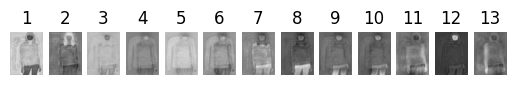

Epoch 1 | Batch 281 | GenLoss 0.8311342000961304 | DiscLoss 0.00015168946993071586
Epoch 1 | Batch 282 | GenLoss 0.9675949215888977 | DiscLoss 0.00014394416939467192
Epoch 1 | Batch 283 | GenLoss 0.8413493633270264 | DiscLoss 0.00015011841605883092
Epoch 1 | Batch 284 | GenLoss 1.0351002216339111 | DiscLoss 0.0002030055911745876
Epoch 1 | Batch 285 | GenLoss 0.6207741498947144 | DiscLoss 0.00012152396084275097
Epoch 1 | Batch 286 | GenLoss 0.607309877872467 | DiscLoss 0.00012905526091344655
Epoch 1 | Batch 287 | GenLoss 0.6290632486343384 | DiscLoss 0.00012924958718940616
Epoch 1 | Batch 288 | GenLoss 0.6908189654350281 | DiscLoss 0.00010822233161889017
Epoch 1 | Batch 289 | GenLoss 0.638352632522583 | DiscLoss 0.00013881434279028326
Epoch 1 | Batch 290 | GenLoss 0.9318902492523193 | DiscLoss 0.00014320464106276631
Epoch 1 | Batch 291 | GenLoss 0.9178623557090759 | DiscLoss 0.00012413389049470425
Epoch 1 | Batch 292 | GenLoss 0.8829033374786377 | DiscLoss 0.0001223790750373155
Epoch 1 

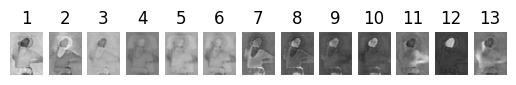

Epoch 1 | Batch 301 | GenLoss 0.8112733364105225 | DiscLoss 0.00013424910139292479
Epoch 1 | Batch 302 | GenLoss 0.6623070240020752 | DiscLoss 0.00013088945706840605
Epoch 1 | Batch 303 | GenLoss 0.7338483333587646 | DiscLoss 0.00015118744340725243
Epoch 1 | Batch 304 | GenLoss 1.257720947265625 | DiscLoss 0.00015200281632132828
Epoch 1 | Batch 305 | GenLoss 1.2964750528335571 | DiscLoss 0.000158530063345097
Epoch 1 | Batch 306 | GenLoss 0.7226310968399048 | DiscLoss 0.00019277686078567058
Epoch 1 | Batch 307 | GenLoss 0.9682042598724365 | DiscLoss 0.0001489964488428086
Epoch 1 | Batch 308 | GenLoss 1.3516688346862793 | DiscLoss 0.00016796441923361272
Epoch 1 | Batch 309 | GenLoss 0.7786846160888672 | DiscLoss 0.00014121807180345058
Epoch 1 | Batch 310 | GenLoss 0.6702229380607605 | DiscLoss 0.00014261421165429056
Epoch 1 | Batch 311 | GenLoss 1.0266003608703613 | DiscLoss 0.0001629360776860267
Epoch 1 | Batch 312 | GenLoss 0.7120755314826965 | DiscLoss 0.00014756698510609567
Epoch 1 |

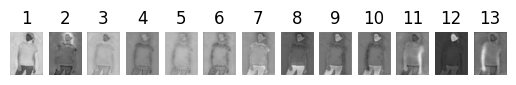

Epoch 1 | Batch 321 | GenLoss 0.8674101829528809 | DiscLoss 0.00012288133439142257
Epoch 1 | Batch 322 | GenLoss 1.1110906600952148 | DiscLoss 0.00012703854008577764
Epoch 1 | Batch 323 | GenLoss 0.7149214744567871 | DiscLoss 0.00011963216093135998
Epoch 1 | Batch 324 | GenLoss 0.644683301448822 | DiscLoss 0.00013653056521434337
Epoch 1 | Batch 325 | GenLoss 0.9993953704833984 | DiscLoss 0.0001424784422852099
Epoch 1 | Batch 326 | GenLoss 0.7266196012496948 | DiscLoss 0.00013458941248245537
Epoch 1 | Batch 327 | GenLoss 0.8572086691856384 | DiscLoss 0.00014221254969015718
Epoch 1 | Batch 328 | GenLoss 0.8877472877502441 | DiscLoss 0.0001513497845735401
Epoch 1 | Batch 329 | GenLoss 0.7803345918655396 | DiscLoss 0.00012963649351149797
Epoch 1 | Batch 330 | GenLoss 0.7537727355957031 | DiscLoss 0.00011973681102972478
Epoch 1 | Batch 331 | GenLoss 0.7272487282752991 | DiscLoss 0.00012541512842290103
Epoch 1 | Batch 332 | GenLoss 1.3290331363677979 | DiscLoss 0.000155282934429124
Epoch 1 |

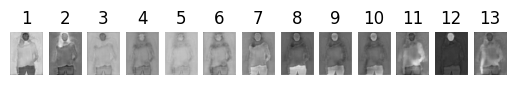

Epoch 1 | Batch 341 | GenLoss 0.9403043985366821 | DiscLoss 0.00013040468911640346
Epoch 1 | Batch 342 | GenLoss 0.6220799684524536 | DiscLoss 0.0001449192495783791
Epoch 1 | Batch 343 | GenLoss 1.1300228834152222 | DiscLoss 0.00013421117910183966
Epoch 1 | Batch 344 | GenLoss 0.9227743148803711 | DiscLoss 0.00012992096890229732
Epoch 1 | Batch 345 | GenLoss 0.6900771856307983 | DiscLoss 0.0001465299865230918
Epoch 1 | Batch 346 | GenLoss 0.7228667736053467 | DiscLoss 0.0001299387076869607
Epoch 1 | Batch 347 | GenLoss 0.9019505977630615 | DiscLoss 0.00016434349527116865
Epoch 1 | Batch 348 | GenLoss 0.9364664554595947 | DiscLoss 0.00012753480405081064
Epoch 1 | Batch 349 | GenLoss 0.7663291692733765 | DiscLoss 0.00013243398279882967
Epoch 1 | Batch 350 | GenLoss 0.8280619978904724 | DiscLoss 0.0001268699998036027
Epoch 1 | Batch 351 | GenLoss 0.965678334236145 | DiscLoss 0.00013368678628467023
Epoch 1 | Batch 352 | GenLoss 0.7649415731430054 | DiscLoss 0.00019971017900388688
Epoch 1 |

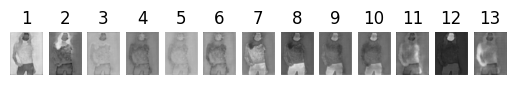

Epoch 1 | Batch 361 | GenLoss 0.6617914438247681 | DiscLoss 0.0002003334666369483
Epoch 1 | Batch 362 | GenLoss 0.6395813226699829 | DiscLoss 0.00015469662321265787
Epoch 1 | Batch 363 | GenLoss 0.8529749512672424 | DiscLoss 0.00016677619714755565
Epoch 1 | Batch 364 | GenLoss 1.1005418300628662 | DiscLoss 0.00015963608166202903
Epoch 1 | Batch 365 | GenLoss 0.7690591812133789 | DiscLoss 0.00014655370614491403
Epoch 1 | Batch 366 | GenLoss 0.7475957870483398 | DiscLoss 0.0001270556531380862
Epoch 1 | Batch 367 | GenLoss 0.6104737520217896 | DiscLoss 0.00014440316590480506
Epoch 1 | Batch 368 | GenLoss 0.6796068549156189 | DiscLoss 0.00019247269665356725
Epoch 1 | Batch 369 | GenLoss 0.9463393688201904 | DiscLoss 0.00016816688003018498
Epoch 1 | Batch 370 | GenLoss 0.8137646913528442 | DiscLoss 0.00014592161460313946
Epoch 1 | Batch 371 | GenLoss 0.5386425256729126 | DiscLoss 0.00011374455061741173
Epoch 1 | Batch 372 | GenLoss 0.814441442489624 | DiscLoss 0.00012306009011808783
Epoch 1

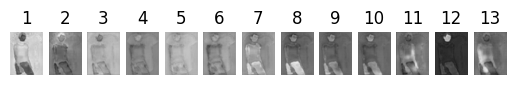

Epoch 1 | Batch 381 | GenLoss 0.6361057758331299 | DiscLoss 0.00012900294677820057
Epoch 1 | Batch 382 | GenLoss 0.7706652879714966 | DiscLoss 0.0001962652604561299
Epoch 1 | Batch 383 | GenLoss 0.9738308191299438 | DiscLoss 0.00013360835146158934
Epoch 1 | Batch 384 | GenLoss 0.8090617656707764 | DiscLoss 0.00015541557513643056
Epoch 1 | Batch 385 | GenLoss 0.7181138396263123 | DiscLoss 0.00013620109530165792
Epoch 1 | Batch 386 | GenLoss 0.8986493349075317 | DiscLoss 0.00016602789401076734
Epoch 1 | Batch 387 | GenLoss 0.9930223226547241 | DiscLoss 0.00017181853763759136
Epoch 1 | Batch 388 | GenLoss 0.9050999879837036 | DiscLoss 0.00013486319221556187
Epoch 1 | Batch 389 | GenLoss 0.8078752756118774 | DiscLoss 0.0001481531362514943
Epoch 1 | Batch 390 | GenLoss 0.9258422255516052 | DiscLoss 0.0001757919671945274
Epoch 1 | Batch 391 | GenLoss 0.8457812666893005 | DiscLoss 0.00014931667828932405
Epoch 1 | Batch 392 | GenLoss 0.7472373247146606 | DiscLoss 0.00013582975952886045
Epoch 1

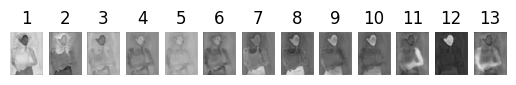

Epoch 1 | Batch 401 | GenLoss 0.606617271900177 | DiscLoss 0.000209178397199139
Epoch 1 | Batch 402 | GenLoss 0.855047345161438 | DiscLoss 0.0001339689188171178
Epoch 1 | Batch 403 | GenLoss 0.7482539415359497 | DiscLoss 0.00011911804904229939
Epoch 1 | Batch 404 | GenLoss 0.7787626385688782 | DiscLoss 0.00013391865650191903
Epoch 1 | Batch 405 | GenLoss 0.8567039966583252 | DiscLoss 0.00012819544645026326
Epoch 1 | Batch 406 | GenLoss 0.8517472743988037 | DiscLoss 0.00013763619062956423
Epoch 1 | Batch 407 | GenLoss 0.6531410813331604 | DiscLoss 0.00012875013635493815
Epoch 1 | Batch 408 | GenLoss 0.8370739221572876 | DiscLoss 0.00013446039520204067
Epoch 1 | Batch 409 | GenLoss 0.9595584869384766 | DiscLoss 0.00012884769239462912
Epoch 1 | Batch 410 | GenLoss 1.1045222282409668 | DiscLoss 0.00012466535554267466
Epoch 1 | Batch 411 | GenLoss 0.8468916416168213 | DiscLoss 0.0001477579353377223
Epoch 1 | Batch 412 | GenLoss 0.7419075965881348 | DiscLoss 0.00013596571807283908
Epoch 1 | 

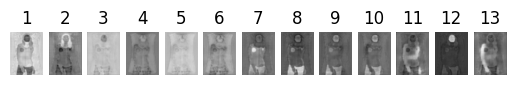

Epoch 1 | Batch 421 | GenLoss 1.1328932046890259 | DiscLoss 0.00013978136121295393
Epoch 1 | Batch 422 | GenLoss 0.8276703953742981 | DiscLoss 0.00012991852418053895
Epoch 1 | Batch 423 | GenLoss 0.7293015718460083 | DiscLoss 0.00013687150203622878
Epoch 1 | Batch 424 | GenLoss 0.939382791519165 | DiscLoss 0.00014969675976317376
Epoch 1 | Batch 425 | GenLoss 0.7379347681999207 | DiscLoss 0.00012976537982467562
Epoch 1 | Batch 426 | GenLoss 0.7972812652587891 | DiscLoss 0.0001402567431796342
Epoch 1 | Batch 427 | GenLoss 1.0338947772979736 | DiscLoss 0.0001300307339988649
Epoch 1 | Batch 428 | GenLoss 0.8684725761413574 | DiscLoss 0.00014079335960559547
Epoch 1 | Batch 429 | GenLoss 0.8147573471069336 | DiscLoss 0.00011565812746994197
Epoch 1 | Batch 430 | GenLoss 0.6024855375289917 | DiscLoss 0.00015054864343255758
Epoch 1 | Batch 431 | GenLoss 0.6848182678222656 | DiscLoss 0.0001332300598733127
Epoch 1 | Batch 432 | GenLoss 1.0236456394195557 | DiscLoss 0.00013112583837937564
Epoch 1 

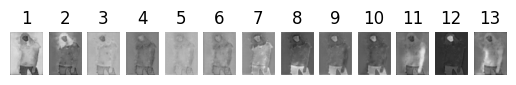

Epoch 1 | Batch 441 | GenLoss 0.9100439548492432 | DiscLoss 0.00012127288209740072
Epoch 1 | Batch 442 | GenLoss 1.073981761932373 | DiscLoss 0.00013894622679799795
Epoch 1 | Batch 443 | GenLoss 0.8622691035270691 | DiscLoss 0.00012494686234276742
Epoch 1 | Batch 444 | GenLoss 0.6843575239181519 | DiscLoss 0.0001690972421783954
Epoch 1 | Batch 445 | GenLoss 1.3402330875396729 | DiscLoss 0.00014034565538167953
Epoch 1 | Batch 446 | GenLoss 0.784864068031311 | DiscLoss 0.0001334446424152702
Epoch 1 | Batch 447 | GenLoss 0.9262363910675049 | DiscLoss 0.00013151884195394814
Epoch 1 | Batch 448 | GenLoss 0.7595117092132568 | DiscLoss 0.00013337843120098114
Epoch 1 | Batch 449 | GenLoss 1.019371747970581 | DiscLoss 0.00012011009675916284
Epoch 1 | Batch 450 | GenLoss 1.0011764764785767 | DiscLoss 0.00011027016444131732
Epoch 1 | Batch 451 | GenLoss 0.992734968662262 | DiscLoss 0.00012339703971520066
Epoch 1 | Batch 452 | GenLoss 0.9399377107620239 | DiscLoss 0.00020112544007133693
Epoch 1 | 

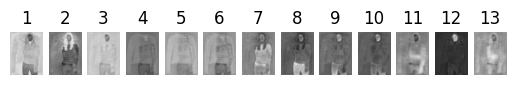

Epoch 1 | Batch 461 | GenLoss 1.1560200452804565 | DiscLoss 0.00014327463577501476
Epoch 1 | Batch 462 | GenLoss 0.7923194766044617 | DiscLoss 0.00012099005107302219
Epoch 1 | Batch 463 | GenLoss 0.7051427364349365 | DiscLoss 0.00012216031609568745
Epoch 1 | Batch 464 | GenLoss 0.9938910007476807 | DiscLoss 0.00014889269368723035
Epoch 1 | Batch 465 | GenLoss 0.9907743334770203 | DiscLoss 0.00015498592983931303
Epoch 1 | Batch 466 | GenLoss 1.1147642135620117 | DiscLoss 0.00011841950617963448
Epoch 1 | Batch 467 | GenLoss 0.7865572571754456 | DiscLoss 0.00010934059537248686
Epoch 1 | Batch 468 | GenLoss 0.5971997380256653 | DiscLoss 0.00011027531581930816
Epoch 1 | Batch 469 | GenLoss 0.7622259855270386 | DiscLoss 0.00012260877701919526
Epoch 1 | Batch 470 | GenLoss 0.846172571182251 | DiscLoss 0.00012018874986097217
Epoch 1 | Batch 471 | GenLoss 0.8968228101730347 | DiscLoss 0.0001416990126017481
Epoch 1 | Batch 472 | GenLoss 0.756401538848877 | DiscLoss 0.0001144597990787588
Epoch 1 

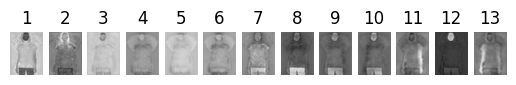

Epoch 1 | Batch 481 | GenLoss 0.9194064140319824 | DiscLoss 0.00024742810637690127
Epoch 1 | Batch 482 | GenLoss 0.8297568559646606 | DiscLoss 0.0001449987175874412
Epoch 1 | Batch 483 | GenLoss 0.7981106638908386 | DiscLoss 0.00010512703011045232
Epoch 1 | Batch 484 | GenLoss 0.6574780941009521 | DiscLoss 0.00014731561532244086
Epoch 1 | Batch 485 | GenLoss 0.7562827467918396 | DiscLoss 0.00011862136307172477
Epoch 1 | Batch 486 | GenLoss 0.6512887477874756 | DiscLoss 0.00014456183998845518
Epoch 1 | Batch 487 | GenLoss 0.7186810970306396 | DiscLoss 0.0001324330660281703
Epoch 1 | Batch 488 | GenLoss 0.8125836849212646 | DiscLoss 0.0001185672590509057
Epoch 1 | Batch 489 | GenLoss 0.7713213562965393 | DiscLoss 0.00011684269702527672
Epoch 1 | Batch 490 | GenLoss 0.5843783020973206 | DiscLoss 0.00010727279732236639
Epoch 1 | Batch 491 | GenLoss 0.8438422679901123 | DiscLoss 0.0001274055102840066
Epoch 1 | Batch 492 | GenLoss 0.8093417882919312 | DiscLoss 0.00012193778820801526
Epoch 1 

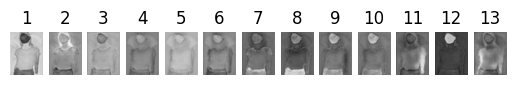

Epoch 1 | Batch 501 | GenLoss 0.6855103373527527 | DiscLoss 0.00010722956358222291
Epoch 1 | Batch 502 | GenLoss 0.7569465041160583 | DiscLoss 0.00010004065552493557
Epoch 1 | Batch 503 | GenLoss 0.7388832569122314 | DiscLoss 0.00010220310650765896
Epoch 1 | Batch 504 | GenLoss 0.9538271427154541 | DiscLoss 0.00011127001198474318
Epoch 1 | Batch 505 | GenLoss 0.6322238445281982 | DiscLoss 0.00010080598440254107
Epoch 1 | Batch 506 | GenLoss 0.8376118540763855 | DiscLoss 0.00010852687410078943
Epoch 1 | Batch 507 | GenLoss 0.5522066354751587 | DiscLoss 0.00010123856918653473
Epoch 1 | Batch 508 | GenLoss 0.8271315097808838 | DiscLoss 0.0001161510735983029
Epoch 1 | Batch 509 | GenLoss 0.7514309883117676 | DiscLoss 0.00011139935668325052
Epoch 1 | Batch 510 | GenLoss 1.1383240222930908 | DiscLoss 0.00011735428415704519
Epoch 1 | Batch 511 | GenLoss 1.4620757102966309 | DiscLoss 0.0001371759281028062
Epoch 1 | Batch 512 | GenLoss 0.6754693388938904 | DiscLoss 0.0001063089948729612
Epoch 1

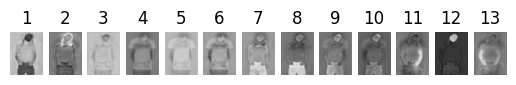

Epoch 1 | Batch 521 | GenLoss 0.7205712199211121 | DiscLoss 9.248159767594188e-05
Epoch 1 | Batch 522 | GenLoss 0.6718376278877258 | DiscLoss 9.657908958615735e-05
Epoch 1 | Batch 523 | GenLoss 0.6344504356384277 | DiscLoss 9.79420292424038e-05
Epoch 1 | Batch 524 | GenLoss 1.0043655633926392 | DiscLoss 9.300869714934379e-05
Epoch 1 | Batch 525 | GenLoss 1.161109447479248 | DiscLoss 0.00012032335507683456
Epoch 1 | Batch 526 | GenLoss 0.6256242990493774 | DiscLoss 9.54029310378246e-05
Epoch 1 | Batch 527 | GenLoss 0.7099912166595459 | DiscLoss 0.00011435659689595923
Epoch 1 | Batch 528 | GenLoss 0.6726782321929932 | DiscLoss 0.00010971866140607744
Epoch 1 | Batch 529 | GenLoss 0.7961530089378357 | DiscLoss 0.00011692909174598753
Epoch 1 | Batch 530 | GenLoss 0.5402565002441406 | DiscLoss 0.00013449168181978166
Epoch 1 | Batch 531 | GenLoss 0.6769167184829712 | DiscLoss 0.00010866209049709141
Epoch 1 | Batch 532 | GenLoss 0.9680425524711609 | DiscLoss 0.00012498677824623883
Epoch 1 | Ba

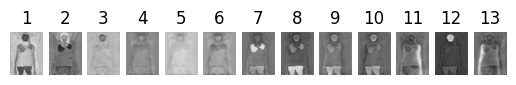

Epoch 1 | Batch 541 | GenLoss 0.9662209749221802 | DiscLoss 0.00011839788203360513
Epoch 1 | Batch 542 | GenLoss 0.6284084320068359 | DiscLoss 0.00014473486226052046
Epoch 1 | Batch 543 | GenLoss 0.8088451623916626 | DiscLoss 0.00017879981896840036
Epoch 1 | Batch 544 | GenLoss 0.7279685735702515 | DiscLoss 0.00010721568833105266
Epoch 1 | Batch 545 | GenLoss 0.703410804271698 | DiscLoss 0.0001002246281132102
Epoch 1 | Batch 546 | GenLoss 0.9620079398155212 | DiscLoss 0.00014322044444270432
Epoch 1 | Batch 547 | GenLoss 0.9862431287765503 | DiscLoss 0.0001533691247459501
Epoch 1 | Batch 548 | GenLoss 0.6354892253875732 | DiscLoss 0.00012908026110380888
Epoch 1 | Batch 549 | GenLoss 0.7613983154296875 | DiscLoss 0.0001020800118567422
Epoch 1 | Batch 550 | GenLoss 0.7280306816101074 | DiscLoss 0.00013267254689708352
Epoch 1 | Batch 551 | GenLoss 0.66486656665802 | DiscLoss 0.00010157529322896153
Epoch 1 | Batch 552 | GenLoss 0.74134361743927 | DiscLoss 0.00011904645361937582
Epoch 1 | Ba

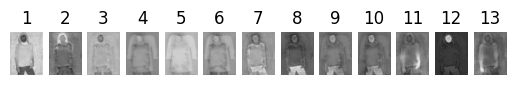

Epoch 1 | Batch 561 | GenLoss 1.0971436500549316 | DiscLoss 0.0001206983215524815
Epoch 1 | Batch 562 | GenLoss 0.7155215740203857 | DiscLoss 0.00010768603533506393
Epoch 1 | Batch 563 | GenLoss 0.9678215980529785 | DiscLoss 0.00010725340689532459
Epoch 1 | Batch 564 | GenLoss 0.730346143245697 | DiscLoss 9.050913649844006e-05
Epoch 1 | Batch 565 | GenLoss 0.734809398651123 | DiscLoss 0.00012465871986933053
Epoch 1 | Batch 566 | GenLoss 0.6773008108139038 | DiscLoss 0.00010500989446882159
Epoch 1 | Batch 567 | GenLoss 0.7414207458496094 | DiscLoss 9.660598880145699e-05
Epoch 1 | Batch 568 | GenLoss 0.5855622887611389 | DiscLoss 8.368501585209742e-05
Epoch 1 | Batch 569 | GenLoss 0.7129578590393066 | DiscLoss 0.0001203052670462057
Epoch 1 | Batch 570 | GenLoss 0.7622116804122925 | DiscLoss 9.725733252707869e-05
Epoch 1 | Batch 571 | GenLoss 0.7090869545936584 | DiscLoss 0.00010746422049123794
Epoch 1 | Batch 572 | GenLoss 1.1563682556152344 | DiscLoss 0.00012515303387772292
Epoch 1 | Ba

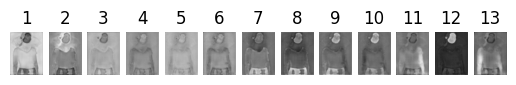

Epoch 1 | Batch 581 | GenLoss 1.2233980894088745 | DiscLoss 0.00013584869157057256
Epoch 1 | Batch 582 | GenLoss 0.5587851405143738 | DiscLoss 0.00010533506429055706
Epoch 1 | Batch 583 | GenLoss 0.878491997718811 | DiscLoss 0.00011199577420484275
Epoch 1 | Batch 584 | GenLoss 0.7992526888847351 | DiscLoss 9.382567077409476e-05
Epoch 1 | Batch 585 | GenLoss 0.7732602953910828 | DiscLoss 0.0001164713830803521
Epoch 1 | Batch 586 | GenLoss 1.7744630575180054 | DiscLoss 0.00010717958502937108
Epoch 1 | Batch 587 | GenLoss 0.7106965780258179 | DiscLoss 0.00011810028809122741
Epoch 1 | Batch 588 | GenLoss 0.8278095722198486 | DiscLoss 0.0001391559053445235
Epoch 1 | Batch 589 | GenLoss 0.6270912289619446 | DiscLoss 9.167681128019467e-05
Epoch 1 | Batch 590 | GenLoss 0.8296973705291748 | DiscLoss 9.750948811415583e-05
Epoch 1 | Batch 591 | GenLoss 0.6438001990318298 | DiscLoss 9.79490578174591e-05
Epoch 1 | Batch 592 | GenLoss 0.8478039503097534 | DiscLoss 0.000128583749756217
Epoch 1 | Batc

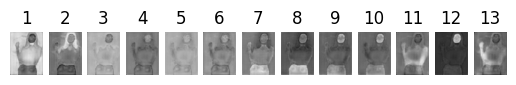

Epoch 1 | Batch 601 | GenLoss 0.9180684089660645 | DiscLoss 9.713720646686852e-05
Epoch 1 | Batch 602 | GenLoss 0.5968624949455261 | DiscLoss 0.00010217544331680983
Epoch 1 | Batch 603 | GenLoss 1.0241645574569702 | DiscLoss 9.751772449817508e-05
Epoch 1 | Batch 604 | GenLoss 0.6127185225486755 | DiscLoss 0.00011661037569865584
Epoch 1 | Batch 605 | GenLoss 0.7241768836975098 | DiscLoss 9.721466631162912e-05
Epoch 1 | Batch 606 | GenLoss 0.5800250172615051 | DiscLoss 0.00010811144602485001
Epoch 1 | Batch 607 | GenLoss 0.6935345530509949 | DiscLoss 0.00010186887811869383
Epoch 1 | Batch 608 | GenLoss 0.8008294105529785 | DiscLoss 0.00010483231744728982
Epoch 1 | Batch 609 | GenLoss 1.1194443702697754 | DiscLoss 0.00010209443280473351
Epoch 1 | Batch 610 | GenLoss 0.7910928130149841 | DiscLoss 9.712807514006272e-05
Epoch 1 | Batch 611 | GenLoss 1.0254266262054443 | DiscLoss 0.00010656128142727539
Epoch 1 | Batch 612 | GenLoss 0.8060160875320435 | DiscLoss 0.00010291171201970428
Epoch 1 

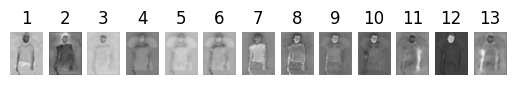

Epoch 1 | Batch 621 | GenLoss 0.8076150417327881 | DiscLoss 0.0001276655966648832
Epoch 1 | Batch 622 | GenLoss 0.7711745500564575 | DiscLoss 0.00012254795001354069
Epoch 1 | Batch 623 | GenLoss 0.7255105972290039 | DiscLoss 0.00010118322097696364
Epoch 1 | Batch 624 | GenLoss 0.601528525352478 | DiscLoss 0.0001014441586448811
Epoch 1 | Batch 625 | GenLoss 0.7233351469039917 | DiscLoss 0.00013610342284664512
Epoch 1 | Batch 626 | GenLoss 1.0431855916976929 | DiscLoss 0.00011882298713317141
Epoch 1 | Batch 627 | GenLoss 0.8943378329277039 | DiscLoss 0.00014985451707616448
Epoch 1 | Batch 628 | GenLoss 1.3081529140472412 | DiscLoss 0.00010890857083722949
Epoch 1 | Batch 629 | GenLoss 0.7338961362838745 | DiscLoss 9.712397877592593e-05
Epoch 1 | Batch 630 | GenLoss 0.7983246445655823 | DiscLoss 0.00013907591346651316
Epoch 1 | Batch 631 | GenLoss 0.8136152029037476 | DiscLoss 0.0001499748759670183
Epoch 1 | Batch 632 | GenLoss 0.6156890988349915 | DiscLoss 0.000111435103463009
Epoch 1 | B

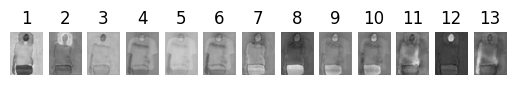

Epoch 1 | Batch 641 | GenLoss 0.7995178699493408 | DiscLoss 9.622177458368242e-05
Epoch 1 | Batch 642 | GenLoss 0.8663605451583862 | DiscLoss 9.553680138196796e-05
Epoch 1 | Batch 643 | GenLoss 0.5584046840667725 | DiscLoss 8.7770153186284e-05
Epoch 1 | Batch 644 | GenLoss 0.9644498825073242 | DiscLoss 9.003691229736432e-05
Epoch 1 | Batch 645 | GenLoss 0.740375816822052 | DiscLoss 9.825384768191725e-05
Epoch 1 | Batch 646 | GenLoss 1.361510157585144 | DiscLoss 0.0001153474222519435
Epoch 1 | Batch 647 | GenLoss 0.809270977973938 | DiscLoss 0.00010434598516440019
Epoch 1 | Batch 648 | GenLoss 0.8615037202835083 | DiscLoss 0.00010342546738684177
Epoch 1 | Batch 649 | GenLoss 0.6383326649665833 | DiscLoss 8.14148152130656e-05
Epoch 1 | Batch 650 | GenLoss 0.6189886927604675 | DiscLoss 9.99648473225534e-05
Epoch 1 | Batch 651 | GenLoss 0.820252001285553 | DiscLoss 0.00010093109449371696
Epoch 1 | Batch 652 | GenLoss 0.905764102935791 | DiscLoss 9.788065653992817e-05
Epoch 1 | Batch 653 | 

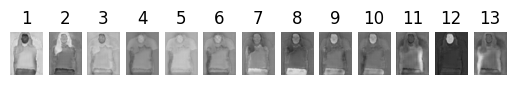

Epoch 1 | Batch 661 | GenLoss 0.8554404973983765 | DiscLoss 0.00011035255738534033
Epoch 1 | Batch 662 | GenLoss 0.7473319172859192 | DiscLoss 0.00020149094052612782
Epoch 1 | Batch 663 | GenLoss 0.7087324857711792 | DiscLoss 8.803627861198038e-05
Epoch 1 | Batch 664 | GenLoss 0.9410198926925659 | DiscLoss 0.00011212673416594043
Epoch 1 | Batch 665 | GenLoss 0.7658164501190186 | DiscLoss 0.00011735894076991826
Epoch 1 | Batch 666 | GenLoss 1.3259212970733643 | DiscLoss 0.00012438674457371235
Epoch 1 | Batch 667 | GenLoss 0.7266252040863037 | DiscLoss 9.978527668863535e-05
Epoch 1 | Batch 668 | GenLoss 1.3087493181228638 | DiscLoss 0.00013967917766422033
Epoch 1 | Batch 669 | GenLoss 0.6034482717514038 | DiscLoss 7.842834747862071e-05
Epoch 1 | Batch 670 | GenLoss 0.9139820337295532 | DiscLoss 0.00010441641643410549
Epoch 1 | Batch 671 | GenLoss 0.6658334732055664 | DiscLoss 0.00010004499199567363
Epoch 1 | Batch 672 | GenLoss 0.5640583634376526 | DiscLoss 9.261086233891547e-05
Epoch 1 

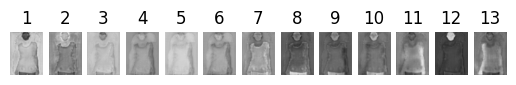

Epoch 1 | Batch 681 | GenLoss 0.8381198644638062 | DiscLoss 8.936933591030538e-05
Epoch 1 | Batch 682 | GenLoss 0.6939348578453064 | DiscLoss 0.0001067233388312161
Epoch 1 | Batch 683 | GenLoss 1.0392706394195557 | DiscLoss 0.00011375760368537158
Epoch 1 | Batch 684 | GenLoss 0.5627783536911011 | DiscLoss 7.51078623579815e-05
Epoch 1 | Batch 685 | GenLoss 1.0415782928466797 | DiscLoss 8.257146691903472e-05
Epoch 1 | Batch 686 | GenLoss 1.0828937292099 | DiscLoss 9.376945672556758e-05
Epoch 1 | Batch 687 | GenLoss 0.9009131789207458 | DiscLoss 0.00010071031283587217
Epoch 1 | Batch 688 | GenLoss 0.9102523326873779 | DiscLoss 8.673935371916741e-05
Epoch 1 | Batch 689 | GenLoss 0.8680667877197266 | DiscLoss 9.163359936792403e-05
Epoch 1 | Batch 690 | GenLoss 0.8931535482406616 | DiscLoss 9.025393228512257e-05
Epoch 1 | Batch 691 | GenLoss 0.8735892176628113 | DiscLoss 8.780220377957448e-05
Epoch 1 | Batch 692 | GenLoss 0.6750131845474243 | DiscLoss 8.818958303891122e-05
Epoch 1 | Batch 69

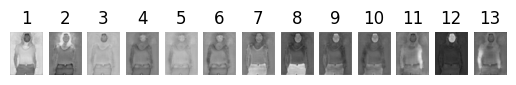

Epoch 1 | Batch 701 | GenLoss 0.9068137407302856 | DiscLoss 0.00010981712694047019
Epoch 1 | Batch 702 | GenLoss 0.8360522389411926 | DiscLoss 0.00011079676914960146
Epoch 1 | Batch 703 | GenLoss 1.1336630582809448 | DiscLoss 0.00012036719272146001
Epoch 1 | Batch 704 | GenLoss 1.0121616125106812 | DiscLoss 0.00010587881843093783
Epoch 1 | Batch 705 | GenLoss 1.0436906814575195 | DiscLoss 0.00013217802916187793
Epoch 1 | Batch 706 | GenLoss 0.8139616250991821 | DiscLoss 9.591824345989153e-05
Epoch 1 | Batch 707 | GenLoss 0.6756044030189514 | DiscLoss 0.00010141923849005252
Epoch 1 | Batch 708 | GenLoss 1.0199068784713745 | DiscLoss 0.00010167736036237329
Epoch 1 | Batch 709 | GenLoss 1.179410696029663 | DiscLoss 0.0001169925817521289
Epoch 1 | Batch 710 | GenLoss 0.6863859295845032 | DiscLoss 0.00012079105363227427
Epoch 1 | Batch 711 | GenLoss 0.8018773794174194 | DiscLoss 0.00011325306695653126
Epoch 1 | Batch 712 | GenLoss 0.7984312772750854 | DiscLoss 9.986186341848224e-05
Epoch 1 

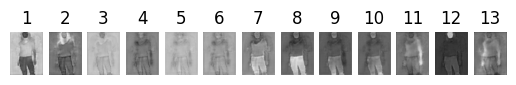

Epoch 1 | Batch 721 | GenLoss 0.702363908290863 | DiscLoss 8.462421101285145e-05
Epoch 1 | Batch 722 | GenLoss 0.7109211683273315 | DiscLoss 8.331108983838931e-05
Epoch 1 | Batch 723 | GenLoss 0.5412542819976807 | DiscLoss 0.00010093959281221032
Epoch 1 | Batch 724 | GenLoss 0.7308202981948853 | DiscLoss 7.899633055785671e-05
Epoch 1 | Batch 725 | GenLoss 0.8173303604125977 | DiscLoss 0.00012168720422778279
Epoch 1 | Batch 726 | GenLoss 0.8420701026916504 | DiscLoss 0.0001031800638884306
Epoch 1 | Batch 727 | GenLoss 0.779395580291748 | DiscLoss 0.00010088775161420926
Epoch 1 | Batch 728 | GenLoss 0.7329949140548706 | DiscLoss 0.00010295771789969876
Epoch 1 | Batch 729 | GenLoss 0.8742972612380981 | DiscLoss 9.517421131022274e-05
Epoch 1 | Batch 730 | GenLoss 0.7016811370849609 | DiscLoss 9.207394032273442e-05
Epoch 1 | Batch 731 | GenLoss 0.7722301483154297 | DiscLoss 9.343971032649279e-05
Epoch 1 | Batch 732 | GenLoss 0.8367452025413513 | DiscLoss 0.00010718261182773858
Epoch 1 | Bat

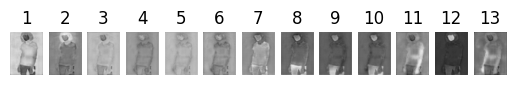

Epoch 1 | Batch 741 | GenLoss 0.8256998658180237 | DiscLoss 0.0001192576892208308
Epoch 1 | Batch 742 | GenLoss 0.5784931182861328 | DiscLoss 0.00012472202070057392
Epoch 1 | Batch 743 | GenLoss 0.815656304359436 | DiscLoss 8.800271461950615e-05
Epoch 1 | Batch 744 | GenLoss 0.8889540433883667 | DiscLoss 9.355111251352355e-05
Epoch 1 | Batch 745 | GenLoss 0.8834638595581055 | DiscLoss 9.166852396447212e-05
Epoch 1 | Batch 746 | GenLoss 0.9244495034217834 | DiscLoss 7.666403689654544e-05
Epoch 1 | Batch 747 | GenLoss 0.7514902949333191 | DiscLoss 8.739506301935762e-05
Epoch 1 | Batch 748 | GenLoss 0.710575520992279 | DiscLoss 9.596133895684034e-05
Epoch 1 | Batch 749 | GenLoss 0.7904798984527588 | DiscLoss 8.452824840787798e-05
Epoch 1 | Batch 750 | GenLoss 0.638993501663208 | DiscLoss 8.153943053912371e-05
Epoch 1 | Batch 751 | GenLoss 0.7783380150794983 | DiscLoss 8.701688784640282e-05
Epoch 1 | Batch 752 | GenLoss 1.0507335662841797 | DiscLoss 0.0001227679313160479
Epoch 1 | Batch 75

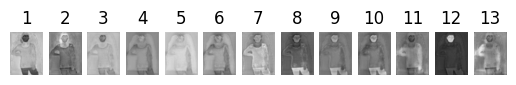

Epoch 1 | Batch 761 | GenLoss 0.8643805980682373 | DiscLoss 0.00010646221198840067
Epoch 1 | Batch 762 | GenLoss 0.6604897379875183 | DiscLoss 0.0001005043595796451
Epoch 1 | Batch 763 | GenLoss 1.3435267210006714 | DiscLoss 9.204277739627287e-05
Epoch 1 | Batch 764 | GenLoss 0.9934395551681519 | DiscLoss 9.436027175979689e-05
Epoch 1 | Batch 765 | GenLoss 0.6923150420188904 | DiscLoss 8.612610690761358e-05
Epoch 1 | Batch 766 | GenLoss 0.6423490047454834 | DiscLoss 0.00010694548836909235
Epoch 1 | Batch 767 | GenLoss 0.828981876373291 | DiscLoss 9.023068560054526e-05
Epoch 1 | Batch 768 | GenLoss 0.7379114627838135 | DiscLoss 9.87145904218778e-05
Epoch 1 | Batch 769 | GenLoss 0.9542595148086548 | DiscLoss 9.731671889312565e-05
Epoch 1 | Batch 770 | GenLoss 0.5853692889213562 | DiscLoss 8.361404616152868e-05
Epoch 1 | Batch 771 | GenLoss 0.8021044731140137 | DiscLoss 0.0001028954575303942
Epoch 1 | Batch 772 | GenLoss 1.7553977966308594 | DiscLoss 9.042990859597921e-05
Epoch 1 | Batch 

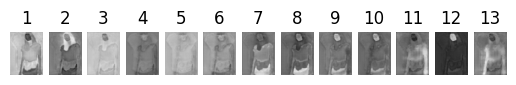

Epoch 1 | Batch 781 | GenLoss 0.9937661290168762 | DiscLoss 7.665358134545386e-05
Epoch 1 | Batch 782 | GenLoss 0.5451779961585999 | DiscLoss 7.710103818681091e-05
Epoch 1 | Batch 783 | GenLoss 0.9671664237976074 | DiscLoss 0.00014681648463010788
Epoch 1 | Batch 784 | GenLoss 0.8452813625335693 | DiscLoss 0.0001224809675477445
Epoch 1 | Batch 785 | GenLoss 1.019737958908081 | DiscLoss 0.0001611897605471313
Epoch 1 | Batch 786 | GenLoss 0.5890697836875916 | DiscLoss 8.214058470912278e-05
Epoch 1 | Batch 787 | GenLoss 0.6367210149765015 | DiscLoss 9.559473255649209e-05
Epoch 1 | Batch 788 | GenLoss 0.7580398917198181 | DiscLoss 9.657035116106272e-05
Epoch 1 | Batch 789 | GenLoss 1.1529710292816162 | DiscLoss 0.0001239737175637856
Epoch 1 | Batch 790 | GenLoss 0.8842959403991699 | DiscLoss 0.00010115602344740182
Epoch 1 | Batch 791 | GenLoss 0.7705742120742798 | DiscLoss 0.00013556807243730873
Epoch 1 | Batch 792 | GenLoss 0.8284989595413208 | DiscLoss 0.0001430011761840433
Epoch 1 | Batc

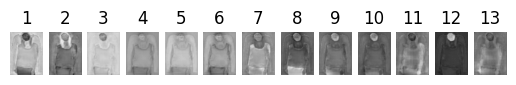

Epoch 1 | Batch 801 | GenLoss 0.806471049785614 | DiscLoss 9.056525595951825e-05
Epoch 1 | Batch 802 | GenLoss 0.635464072227478 | DiscLoss 0.00010777447459986433
Epoch 1 | Batch 803 | GenLoss 0.9267144799232483 | DiscLoss 0.00010440402547828853
Epoch 1 | Batch 804 | GenLoss 1.134214162826538 | DiscLoss 9.0825829829555e-05
Epoch 1 | Batch 805 | GenLoss 0.694887638092041 | DiscLoss 0.0009089020895771682
Epoch 1 | Batch 806 | GenLoss 0.7408732175827026 | DiscLoss 0.0001251487119589001
Epoch 1 | Batch 807 | GenLoss 1.095170021057129 | DiscLoss 0.0002586996997706592
Epoch 1 | Batch 808 | GenLoss 0.6977124214172363 | DiscLoss 9.485099872108549e-05
Epoch 1 | Batch 809 | GenLoss 0.5460094213485718 | DiscLoss 0.00010056563769467175
Epoch 1 | Batch 810 | GenLoss 0.6634047031402588 | DiscLoss 0.0001032384971040301
Epoch 1 | Batch 811 | GenLoss 0.4560723900794983 | DiscLoss 0.00011630530207185075
Epoch 1 | Batch 812 | GenLoss 0.92429518699646 | DiscLoss 0.00011123706644866616
Epoch 1 | Batch 813 

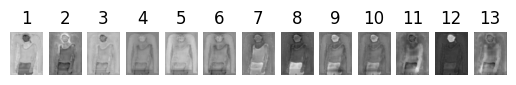

Epoch 1 | Batch 821 | GenLoss 0.8095529079437256 | DiscLoss 9.44522034842521e-05
Epoch 1 | Batch 822 | GenLoss 0.5726367235183716 | DiscLoss 0.00011328262917231768
Epoch 1 | Batch 823 | GenLoss 0.48699870705604553 | DiscLoss 0.00011051759065594524
Epoch 1 | Batch 824 | GenLoss 0.6493929028511047 | DiscLoss 8.98522266652435e-05
Epoch 1 | Batch 825 | GenLoss 0.782482922077179 | DiscLoss 9.723470429889858e-05
Epoch 1 | Batch 826 | GenLoss 0.651831865310669 | DiscLoss 0.00011451430327724665
Epoch 1 | Batch 827 | GenLoss 1.0229473114013672 | DiscLoss 9.970765677280724e-05
Epoch 1 | Batch 828 | GenLoss 0.5725632905960083 | DiscLoss 0.0001032620930345729
Epoch 1 | Batch 829 | GenLoss 0.8036309480667114 | DiscLoss 9.697803761810064e-05
Epoch 1 | Batch 830 | GenLoss 1.1670430898666382 | DiscLoss 0.00012351173791103065
Epoch 1 | Batch 831 | GenLoss 0.560862123966217 | DiscLoss 0.00010827878577401862
Epoch 1 | Batch 832 | GenLoss 0.6831178069114685 | DiscLoss 8.338241605088115e-05
Epoch 1 | Batch

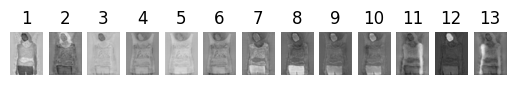

Epoch 1 | Batch 841 | GenLoss 0.548610508441925 | DiscLoss 8.796312613412738e-05
Epoch 1 | Batch 842 | GenLoss 0.5670427680015564 | DiscLoss 8.40639477246441e-05
Epoch 1 | Batch 843 | GenLoss 0.8101433515548706 | DiscLoss 7.745122275082394e-05
Epoch 1 | Batch 844 | GenLoss 0.5899825692176819 | DiscLoss 7.925087993498892e-05
Epoch 1 | Batch 845 | GenLoss 0.5507671236991882 | DiscLoss 0.00012427446199581027
Epoch 1 | Batch 846 | GenLoss 0.5608169436454773 | DiscLoss 9.06836285139434e-05
Epoch 1 | Batch 847 | GenLoss 1.5467605590820312 | DiscLoss 8.53117962833494e-05
Epoch 1 | Batch 848 | GenLoss 0.7462074756622314 | DiscLoss 8.643138426123187e-05
Epoch 1 | Batch 849 | GenLoss 0.7135363817214966 | DiscLoss 9.676940680947155e-05
Epoch 1 | Batch 850 | GenLoss 0.5355530381202698 | DiscLoss 9.146935190074146e-05
Epoch 1 | Batch 851 | GenLoss 1.0260244607925415 | DiscLoss 8.24198141344823e-05
Epoch 1 | Batch 852 | GenLoss 0.9546757936477661 | DiscLoss 9.081687312573195e-05
Epoch 1 | Batch 853 

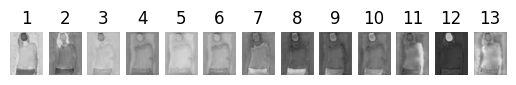

Epoch 1 | Batch 861 | GenLoss 0.7994990348815918 | DiscLoss 9.562732884660363e-05
Epoch 1 | Batch 862 | GenLoss 0.6700181365013123 | DiscLoss 7.533800089731812e-05
Epoch 1 | Batch 863 | GenLoss 0.8643680810928345 | DiscLoss 0.00011223915498703718
Epoch 1 | Batch 864 | GenLoss 0.9406008720397949 | DiscLoss 9.482075984124094e-05
Epoch 1 | Batch 865 | GenLoss 0.5782415866851807 | DiscLoss 7.852811540942639e-05
Epoch 1 | Batch 866 | GenLoss 0.5909877419471741 | DiscLoss 9.155171574093401e-05
Epoch 1 | Batch 867 | GenLoss 0.7792950868606567 | DiscLoss 9.216619218932465e-05
Epoch 1 | Batch 868 | GenLoss 0.6899023056030273 | DiscLoss 8.931955380830914e-05
Epoch 1 | Batch 869 | GenLoss 0.7042408585548401 | DiscLoss 6.983424827922136e-05
Epoch 1 | Batch 870 | GenLoss 0.7600142955780029 | DiscLoss 8.059524407144636e-05
Epoch 1 | Batch 871 | GenLoss 0.9021978378295898 | DiscLoss 8.8193264673464e-05
Epoch 1 | Batch 872 | GenLoss 0.670199990272522 | DiscLoss 8.523742144461721e-05
Epoch 1 | Batch 87

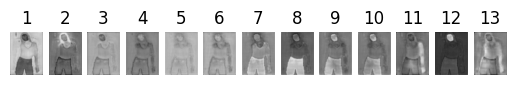

Epoch 1 | Batch 881 | GenLoss 0.6127889156341553 | DiscLoss 8.716977754374966e-05
Epoch 1 | Batch 882 | GenLoss 0.8505064249038696 | DiscLoss 9.646460966905579e-05
Epoch 1 | Batch 883 | GenLoss 0.7324607372283936 | DiscLoss 6.916931306477636e-05
Epoch 1 | Batch 884 | GenLoss 1.0158240795135498 | DiscLoss 0.00010532431770116091
Epoch 1 | Batch 885 | GenLoss 0.8560329675674438 | DiscLoss 0.00010167391155846417
Epoch 1 | Batch 886 | GenLoss 0.6154718399047852 | DiscLoss 0.00012103241897420958
Epoch 1 | Batch 887 | GenLoss 0.8606236577033997 | DiscLoss 9.889257489703596e-05
Epoch 1 | Batch 888 | GenLoss 1.022369146347046 | DiscLoss 0.00011606329644564539
Epoch 1 | Batch 889 | GenLoss 0.7053200006484985 | DiscLoss 7.701157301198691e-05
Epoch 1 | Batch 890 | GenLoss 0.6033316254615784 | DiscLoss 8.435452764388174e-05
Epoch 1 | Batch 891 | GenLoss 0.729445219039917 | DiscLoss 9.094418783206493e-05
Epoch 1 | Batch 892 | GenLoss 0.949925422668457 | DiscLoss 8.824250107863918e-05
Epoch 1 | Batch

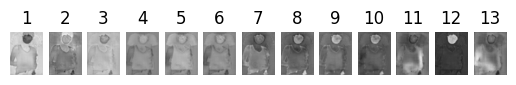

Epoch 1 | Batch 901 | GenLoss 0.783684253692627 | DiscLoss 0.00012751964095514268
Epoch 1 | Batch 902 | GenLoss 0.9042873382568359 | DiscLoss 8.740303746890277e-05
Epoch 1 | Batch 903 | GenLoss 0.640631914138794 | DiscLoss 8.913486817618832e-05
Epoch 1 | Batch 904 | GenLoss 0.6499999165534973 | DiscLoss 0.00010111786832567304
Epoch 1 | Batch 905 | GenLoss 0.6970148682594299 | DiscLoss 0.0001221943530254066
Epoch 1 | Batch 906 | GenLoss 1.113829493522644 | DiscLoss 0.00011786416143877432
Epoch 1 | Batch 907 | GenLoss 0.926000714302063 | DiscLoss 0.00011111568164778873
Epoch 1 | Batch 908 | GenLoss 0.5658301115036011 | DiscLoss 9.999026951845735e-05
Epoch 1 | Batch 909 | GenLoss 0.5724225640296936 | DiscLoss 8.289743709610775e-05
Epoch 1 | Batch 910 | GenLoss 0.7016290426254272 | DiscLoss 0.00011967492173425853
Epoch 1 | Batch 911 | GenLoss 0.6859752535820007 | DiscLoss 0.00011900802201125771
Epoch 1 | Batch 912 | GenLoss 0.759558916091919 | DiscLoss 8.302749483846128e-05
Epoch 1 | Batch

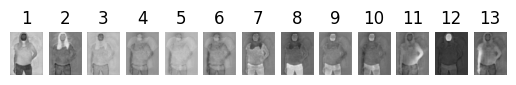

Epoch 1 | Batch 921 | GenLoss 0.7298797369003296 | DiscLoss 8.487083687214181e-05
Epoch 1 | Batch 922 | GenLoss 0.6604927778244019 | DiscLoss 7.996304339030758e-05
Epoch 1 | Batch 923 | GenLoss 0.8374052047729492 | DiscLoss 9.407036122865975e-05
Epoch 1 | Batch 924 | GenLoss 0.585035502910614 | DiscLoss 8.168412023223937e-05
Epoch 1 | Batch 925 | GenLoss 0.7515125274658203 | DiscLoss 9.803734428714961e-05
Epoch 1 | Batch 926 | GenLoss 0.9040758013725281 | DiscLoss 7.643265416845679e-05
Epoch 1 | Batch 927 | GenLoss 0.9600933790206909 | DiscLoss 0.0001053894666256383
Epoch 1 | Batch 928 | GenLoss 0.6967487931251526 | DiscLoss 0.00010382272012066096
Epoch 1 | Batch 929 | GenLoss 0.5087166428565979 | DiscLoss 6.348853639792651e-05
Epoch 1 | Batch 930 | GenLoss 0.6270712614059448 | DiscLoss 7.138329965528101e-05
Epoch 1 | Batch 931 | GenLoss 0.6552671790122986 | DiscLoss 7.608589658048004e-05
Epoch 1 | Batch 932 | GenLoss 0.7649458646774292 | DiscLoss 7.335272675845772e-05
Epoch 1 | Batch 

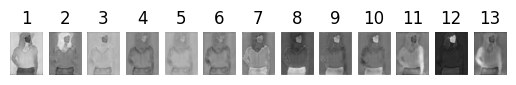

Epoch 1 | Batch 941 | GenLoss 0.6528406143188477 | DiscLoss 7.19068048056215e-05
Epoch 1 | Batch 942 | GenLoss 0.8174804449081421 | DiscLoss 0.00010269613994751126
Epoch 1 | Batch 943 | GenLoss 1.0899691581726074 | DiscLoss 9.884875908028334e-05
Epoch 1 | Batch 944 | GenLoss 0.6304680109024048 | DiscLoss 7.420973997795954e-05
Epoch 1 | Batch 945 | GenLoss 0.6995342969894409 | DiscLoss 7.036902388790622e-05
Epoch 1 | Batch 946 | GenLoss 0.6943254470825195 | DiscLoss 8.258764864876866e-05
Epoch 1 | Batch 947 | GenLoss 0.8820867538452148 | DiscLoss 7.458169420715421e-05
Epoch 1 | Batch 948 | GenLoss 0.6483137011528015 | DiscLoss 6.509936065413058e-05
Epoch 1 | Batch 949 | GenLoss 0.7254549860954285 | DiscLoss 8.31284633022733e-05
Epoch 1 | Batch 950 | GenLoss 0.6716872453689575 | DiscLoss 7.485625974368304e-05
Epoch 1 | Batch 951 | GenLoss 0.866399884223938 | DiscLoss 7.471572462236509e-05
Epoch 1 | Batch 952 | GenLoss 0.7101385593414307 | DiscLoss 7.285539322765544e-05
Epoch 1 | Batch 95

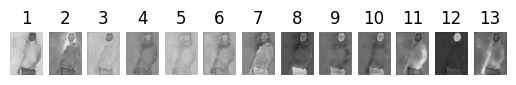

Epoch 1 | Batch 961 | GenLoss 0.6350572109222412 | DiscLoss 7.728172931820154e-05
Epoch 1 | Batch 962 | GenLoss 1.1084271669387817 | DiscLoss 7.876745075918734e-05
Epoch 1 | Batch 963 | GenLoss 1.5581109523773193 | DiscLoss 9.983245399780571e-05
Epoch 1 | Batch 964 | GenLoss 0.8886713981628418 | DiscLoss 0.00011908095621038228
Epoch 1 | Batch 965 | GenLoss 0.7907153367996216 | DiscLoss 7.683360308874398e-05
Epoch 1 | Batch 966 | GenLoss 0.7068287134170532 | DiscLoss 6.360967381624505e-05
Epoch 1 | Batch 967 | GenLoss 0.5787714719772339 | DiscLoss 7.660097617190331e-05
Epoch 1 | Batch 968 | GenLoss 0.8082656860351562 | DiscLoss 8.153847011271864e-05
Epoch 1 | Batch 969 | GenLoss 1.1160893440246582 | DiscLoss 6.944041524548084e-05
Epoch 1 | Batch 970 | GenLoss 0.7970272302627563 | DiscLoss 6.619711348321289e-05
Epoch 1 | Batch 971 | GenLoss 0.7455103397369385 | DiscLoss 7.154641934903339e-05
Epoch 1 | Batch 972 | GenLoss 0.9128125905990601 | DiscLoss 7.646570156794041e-05
Epoch 1 | Batch

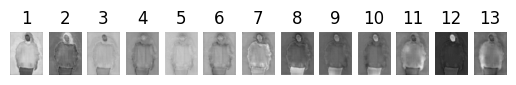

Epoch 1 | Batch 981 | GenLoss 0.5681813955307007 | DiscLoss 9.63382117333822e-05
Epoch 1 | Batch 982 | GenLoss 0.4874473512172699 | DiscLoss 8.462768892059103e-05
Epoch 1 | Batch 983 | GenLoss 0.685554027557373 | DiscLoss 8.471895125694573e-05
Epoch 1 | Batch 984 | GenLoss 0.6013120412826538 | DiscLoss 0.00011241610627621412
Epoch 1 | Batch 985 | GenLoss 0.809154212474823 | DiscLoss 7.359699520748109e-05
Epoch 1 | Batch 986 | GenLoss 0.635942280292511 | DiscLoss 8.39302156236954e-05
Epoch 1 | Batch 987 | GenLoss 0.5493736863136292 | DiscLoss 7.416072185151279e-05
Epoch 1 | Batch 988 | GenLoss 0.9510247707366943 | DiscLoss 7.450768316630274e-05
Epoch 1 | Batch 989 | GenLoss 0.7171846628189087 | DiscLoss 8.387474372284487e-05
Epoch 1 | Batch 990 | GenLoss 0.8168237209320068 | DiscLoss 0.00010327361815143377
Epoch 1 | Batch 991 | GenLoss 0.7460850477218628 | DiscLoss 0.00010754216054920107
Epoch 1 | Batch 992 | GenLoss 0.6711121797561646 | DiscLoss 7.767986971884966e-05
Epoch 1 | Batch 99

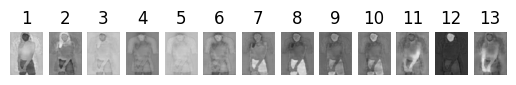

Epoch 1 | Batch 1001 | GenLoss 0.8107728958129883 | DiscLoss 8.445352432318032e-05
Epoch 1 | Batch 1002 | GenLoss 0.4754965007305145 | DiscLoss 7.435160659952089e-05
Epoch 1 | Batch 1003 | GenLoss 0.5487278699874878 | DiscLoss 6.60385048831813e-05
Epoch 1 | Batch 1004 | GenLoss 0.6100913286209106 | DiscLoss 9.227565897163004e-05
Epoch 1 | Batch 1005 | GenLoss 0.8445978164672852 | DiscLoss 6.986703374423087e-05
Epoch 1 | Batch 1006 | GenLoss 0.6064732074737549 | DiscLoss 7.833906420273706e-05
Epoch 1 | Batch 1007 | GenLoss 0.9267174601554871 | DiscLoss 6.810732884332538e-05
Epoch 1 | Batch 1008 | GenLoss 0.743798017501831 | DiscLoss 6.781452975701541e-05
Epoch 1 | Batch 1009 | GenLoss 0.7023965120315552 | DiscLoss 6.742381083313376e-05
Epoch 1 | Batch 1010 | GenLoss 0.6503372192382812 | DiscLoss 6.736531213391572e-05
Epoch 1 | Batch 1011 | GenLoss 0.7028322815895081 | DiscLoss 7.14558846084401e-05
Epoch 1 | Batch 1012 | GenLoss 0.8550667762756348 | DiscLoss 7.087222184054554e-05
Epoch 1

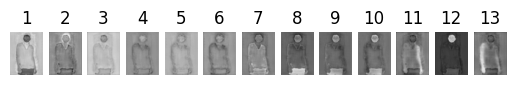

Epoch 1 | Batch 1021 | GenLoss 0.5435757040977478 | DiscLoss 6.777829548809677e-05
Epoch 1 | Batch 1022 | GenLoss 0.5438807010650635 | DiscLoss 6.916022539371625e-05
Epoch 1 | Batch 1023 | GenLoss 0.595927357673645 | DiscLoss 8.32459336379543e-05
Epoch 1 | Batch 1024 | GenLoss 0.7669003009796143 | DiscLoss 6.635034515056759e-05
Epoch 1 | Batch 1025 | GenLoss 0.6171488165855408 | DiscLoss 6.710401794407517e-05
Epoch 1 | Batch 1026 | GenLoss 0.5999487042427063 | DiscLoss 5.9098056226503104e-05
Epoch 1 | Batch 1027 | GenLoss 0.6464720964431763 | DiscLoss 7.853604620322585e-05
Epoch 1 | Batch 1028 | GenLoss 0.570911705493927 | DiscLoss 7.761428423691541e-05
Epoch 1 | Batch 1029 | GenLoss 0.5468192100524902 | DiscLoss 7.464134250767529e-05
Epoch 1 | Batch 1030 | GenLoss 1.0144946575164795 | DiscLoss 8.039379463298246e-05
Epoch 1 | Batch 1031 | GenLoss 0.6954964399337769 | DiscLoss 8.499058458255604e-05
Epoch 1 | Batch 1032 | GenLoss 0.5656811594963074 | DiscLoss 7.554078911198303e-05
Epoch 

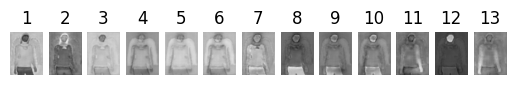

Epoch 1 | Batch 1041 | GenLoss 0.5386390686035156 | DiscLoss 9.055135160451755e-05
Epoch 1 | Batch 1042 | GenLoss 0.7211747765541077 | DiscLoss 7.604987331433222e-05
Epoch 1 | Batch 1043 | GenLoss 0.5441793203353882 | DiscLoss 8.279227768070996e-05
Epoch 1 | Batch 1044 | GenLoss 0.7590638399124146 | DiscLoss 9.755896462593228e-05
Epoch 1 | Batch 1045 | GenLoss 0.9393225908279419 | DiscLoss 9.274084004573524e-05
Epoch 1 | Batch 1046 | GenLoss 0.601811945438385 | DiscLoss 9.917709394358099e-05
Epoch 1 | Batch 1047 | GenLoss 0.6737009286880493 | DiscLoss 7.62165363994427e-05
Epoch 1 | Batch 1048 | GenLoss 0.9278454780578613 | DiscLoss 9.210608550347388e-05
Epoch 1 | Batch 1049 | GenLoss 0.7704676389694214 | DiscLoss 9.148336539510638e-05
Epoch 1 | Batch 1050 | GenLoss 0.7907826900482178 | DiscLoss 9.8828983027488e-05
Epoch 1 | Batch 1051 | GenLoss 0.4430919885635376 | DiscLoss 6.875113467685878e-05
Epoch 1 | Batch 1052 | GenLoss 0.6834977269172668 | DiscLoss 8.676148718222976e-05
Epoch 1 

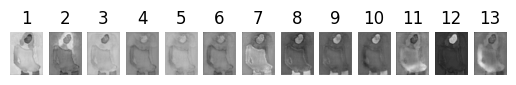

Epoch 1 | Batch 1061 | GenLoss 0.6509124636650085 | DiscLoss 0.00010602401016512886
Epoch 1 | Batch 1062 | GenLoss 0.791374921798706 | DiscLoss 9.634153684601188e-05
Epoch 1 | Batch 1063 | GenLoss 0.697956383228302 | DiscLoss 9.415666136192158e-05
Epoch 1 | Batch 1064 | GenLoss 0.8871989846229553 | DiscLoss 7.75070657255128e-05
Epoch 1 | Batch 1065 | GenLoss 0.5793137550354004 | DiscLoss 8.03224538685754e-05
Epoch 1 | Batch 1066 | GenLoss 0.784916877746582 | DiscLoss 8.678247831994668e-05
Epoch 1 | Batch 1067 | GenLoss 0.6655867099761963 | DiscLoss 7.25677382433787e-05
Epoch 1 | Batch 1068 | GenLoss 0.7004643678665161 | DiscLoss 9.025887993630022e-05
Epoch 1 | Batch 1069 | GenLoss 0.7321133613586426 | DiscLoss 8.196999260690063e-05
Epoch 1 | Batch 1070 | GenLoss 0.7040492296218872 | DiscLoss 8.26184987090528e-05
Epoch 1 | Batch 1071 | GenLoss 0.77052903175354 | DiscLoss 8.145628089550883e-05
Epoch 1 | Batch 1072 | GenLoss 0.627269983291626 | DiscLoss 7.451677811332047e-05
Epoch 1 | Bat

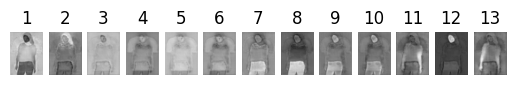

Epoch 1 | Batch 1081 | GenLoss 0.6683862209320068 | DiscLoss 6.622814544243738e-05
Epoch 1 | Batch 1082 | GenLoss 0.6713387370109558 | DiscLoss 6.905382906552404e-05
Epoch 1 | Batch 1083 | GenLoss 0.892485499382019 | DiscLoss 7.753266982035711e-05
Epoch 1 | Batch 1084 | GenLoss 1.1397771835327148 | DiscLoss 7.004727376624942e-05
Epoch 1 | Batch 1085 | GenLoss 0.9048302173614502 | DiscLoss 6.478915020124987e-05
Epoch 1 | Batch 1086 | GenLoss 0.6604843735694885 | DiscLoss 7.745176844764501e-05
Epoch 1 | Batch 1087 | GenLoss 0.6315104961395264 | DiscLoss 8.489265746902674e-05
Epoch 1 | Batch 1088 | GenLoss 0.7647806406021118 | DiscLoss 7.88415054557845e-05
Epoch 1 | Batch 1089 | GenLoss 0.8480702638626099 | DiscLoss 9.133544517681003e-05
Epoch 1 | Batch 1090 | GenLoss 0.5301329493522644 | DiscLoss 6.60925725242123e-05
Epoch 1 | Batch 1091 | GenLoss 1.2735730409622192 | DiscLoss 9.723349648993462e-05
Epoch 1 | Batch 1092 | GenLoss 0.8134212493896484 | DiscLoss 8.739944314584136e-05
Epoch 1

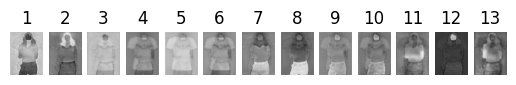

Epoch 1 | Batch 1101 | GenLoss 0.7372573018074036 | DiscLoss 8.625876216683537e-05
Epoch 1 | Batch 1102 | GenLoss 0.6035366654396057 | DiscLoss 6.557067536050454e-05
Epoch 1 | Batch 1103 | GenLoss 0.6895948648452759 | DiscLoss 6.451652006944641e-05
Epoch 1 | Batch 1104 | GenLoss 0.6579580903053284 | DiscLoss 9.813319047680125e-05
Epoch 1 | Batch 1105 | GenLoss 1.119666337966919 | DiscLoss 7.839573663659394e-05
Epoch 1 | Batch 1106 | GenLoss 0.8593288064002991 | DiscLoss 7.619298412464559e-05
Epoch 1 | Batch 1107 | GenLoss 0.7931378483772278 | DiscLoss 7.025369995972142e-05
Epoch 1 | Batch 1108 | GenLoss 0.6353071331977844 | DiscLoss 0.00010880978516070172
Epoch 1 | Batch 1109 | GenLoss 1.3235864639282227 | DiscLoss 8.04415758466348e-05
Epoch 1 | Batch 1110 | GenLoss 0.8011351823806763 | DiscLoss 7.684435695409775e-05
Epoch 1 | Batch 1111 | GenLoss 1.2138311862945557 | DiscLoss 7.585337152704597e-05
Epoch 1 | Batch 1112 | GenLoss 0.9131885766983032 | DiscLoss 6.503527401946485e-05
Epoch

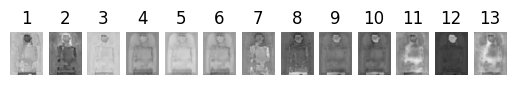

Epoch 1 | Batch 1121 | GenLoss 0.7830239534378052 | DiscLoss 7.206958980532363e-05
Epoch 1 | Batch 1122 | GenLoss 0.9907435178756714 | DiscLoss 6.0213369579287246e-05
Epoch 1 | Batch 1123 | GenLoss 0.7929885387420654 | DiscLoss 6.796835805289447e-05
Epoch 1 | Batch 1124 | GenLoss 0.8161464333534241 | DiscLoss 5.648889782605693e-05
Epoch 1 | Batch 1125 | GenLoss 0.8307249546051025 | DiscLoss 6.21113576926291e-05
Epoch 1 | Batch 1126 | GenLoss 0.7569228410720825 | DiscLoss 6.510155799333006e-05
Epoch 1 | Batch 1127 | GenLoss 0.6368780136108398 | DiscLoss 6.645779649261385e-05
Epoch 1 | Batch 1128 | GenLoss 0.9726678133010864 | DiscLoss 6.211228901520371e-05
Epoch 1 | Batch 1129 | GenLoss 0.5353295207023621 | DiscLoss 5.565493484027684e-05
Epoch 1 | Batch 1130 | GenLoss 0.8094343543052673 | DiscLoss 6.978819146752357e-05
Epoch 1 | Batch 1131 | GenLoss 0.6984606385231018 | DiscLoss 7.303920574486256e-05
Epoch 1 | Batch 1132 | GenLoss 0.675519585609436 | DiscLoss 6.897460843902081e-05
Epoch

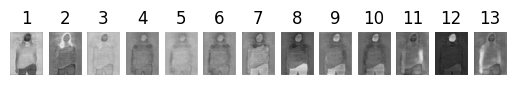

Epoch 1 | Batch 1141 | GenLoss 0.6791903972625732 | DiscLoss 6.816785025876015e-05
Epoch 1 | Batch 1142 | GenLoss 0.7399395108222961 | DiscLoss 5.8074016124010086e-05
Epoch 1 | Batch 1143 | GenLoss 0.7287293672561646 | DiscLoss 6.309216405497864e-05
Epoch 1 | Batch 1144 | GenLoss 0.7371275424957275 | DiscLoss 6.074237171560526e-05
Epoch 1 | Batch 1145 | GenLoss 0.6746134161949158 | DiscLoss 6.30818321951665e-05
Epoch 1 | Batch 1146 | GenLoss 0.5169443488121033 | DiscLoss 6.007810588926077e-05
Epoch 1 | Batch 1147 | GenLoss 0.6076584458351135 | DiscLoss 5.8230605645803735e-05
Epoch 1 | Batch 1148 | GenLoss 0.6846989393234253 | DiscLoss 6.459149881266057e-05
Epoch 1 | Batch 1149 | GenLoss 0.695307731628418 | DiscLoss 6.0213256801944226e-05
Epoch 1 | Batch 1150 | GenLoss 0.598720371723175 | DiscLoss 6.285027484409511e-05
Epoch 1 | Batch 1151 | GenLoss 0.5846807360649109 | DiscLoss 6.519065937027335e-05
Epoch 1 | Batch 1152 | GenLoss 0.9693859815597534 | DiscLoss 6.402996950782835e-05
Epoc

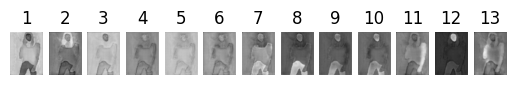

Epoch 1 | Batch 1161 | GenLoss 0.5755270719528198 | DiscLoss 5.659703310811892e-05
Epoch 1 | Batch 1162 | GenLoss 0.8460597991943359 | DiscLoss 8.087091555353254e-05
Epoch 1 | Batch 1163 | GenLoss 0.7237973213195801 | DiscLoss 6.483040488092229e-05
Epoch 1 | Batch 1164 | GenLoss 0.8863060474395752 | DiscLoss 6.99343072483316e-05
Epoch 1 | Batch 1165 | GenLoss 0.9231469035148621 | DiscLoss 6.808406033087522e-05
Epoch 1 | Batch 1166 | GenLoss 0.9405176639556885 | DiscLoss 7.695482054259628e-05
Epoch 1 | Batch 1167 | GenLoss 0.8746987581253052 | DiscLoss 7.577104406664148e-05
Epoch 1 | Batch 1168 | GenLoss 0.9301780462265015 | DiscLoss 6.84808983351104e-05
Epoch 1 | Batch 1169 | GenLoss 0.9674825668334961 | DiscLoss 7.57626403355971e-05
Epoch 1 | Batch 1170 | GenLoss 0.7153291702270508 | DiscLoss 8.286814409075305e-05
Epoch 1 | Batch 1171 | GenLoss 0.6812837719917297 | DiscLoss 8.110053022392094e-05
Epoch 1 | Batch 1172 | GenLoss 0.7426561117172241 | DiscLoss 6.856081017758697e-05
Epoch 1

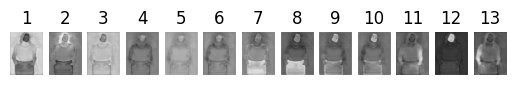

Epoch 1 | Batch 1181 | GenLoss 0.540189802646637 | DiscLoss 6.334262434393167e-05
Epoch 1 | Batch 1182 | GenLoss 0.966147780418396 | DiscLoss 7.324844773393124e-05
Epoch 1 | Batch 1183 | GenLoss 0.6687819957733154 | DiscLoss 6.233453314052895e-05
Epoch 1 | Batch 1184 | GenLoss 0.7226340770721436 | DiscLoss 6.492986722150818e-05
Epoch 1 | Batch 1185 | GenLoss 0.5318608283996582 | DiscLoss 6.261350063141435e-05
Epoch 1 | Batch 1186 | GenLoss 0.6557687520980835 | DiscLoss 6.840830610599369e-05
Epoch 1 | Batch 1187 | GenLoss 0.6509323120117188 | DiscLoss 7.273905794136226e-05
Epoch 1 | Batch 1188 | GenLoss 0.6204904317855835 | DiscLoss 6.679643411189318e-05
Epoch 1 | Batch 1189 | GenLoss 0.7811833620071411 | DiscLoss 6.850522186141461e-05
Epoch 1 | Batch 1190 | GenLoss 0.7213518619537354 | DiscLoss 8.720669575268403e-05
Epoch 1 | Batch 1191 | GenLoss 0.9764938354492188 | DiscLoss 9.056192357093096e-05
Epoch 1 | Batch 1192 | GenLoss 0.9151594638824463 | DiscLoss 8.826556586427614e-05
Epoch 

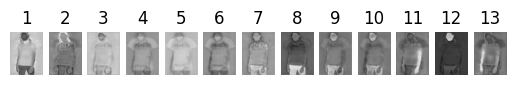

Epoch 1 | Batch 1201 | GenLoss 0.6787508130073547 | DiscLoss 7.523340900661424e-05
Epoch 1 | Batch 1202 | GenLoss 0.7978484630584717 | DiscLoss 5.8404857554705814e-05
Epoch 1 | Batch 1203 | GenLoss 1.332189917564392 | DiscLoss 8.609321957919747e-05
Epoch 1 | Batch 1204 | GenLoss 1.048614263534546 | DiscLoss 6.886736082378775e-05
Epoch 1 | Batch 1205 | GenLoss 0.7772156596183777 | DiscLoss 7.298578566405922e-05
Epoch 1 | Batch 1206 | GenLoss 1.0321872234344482 | DiscLoss 8.384766988456249e-05
Epoch 1 | Batch 1207 | GenLoss 1.0495107173919678 | DiscLoss 8.826608245726675e-05
Epoch 1 | Batch 1208 | GenLoss 0.5414239764213562 | DiscLoss 7.008463580859825e-05
Epoch 1 | Batch 1209 | GenLoss 0.53249192237854 | DiscLoss 5.6870376283768564e-05
Epoch 1 | Batch 1210 | GenLoss 0.8574222922325134 | DiscLoss 6.486764323199168e-05
Epoch 1 | Batch 1211 | GenLoss 0.6763650178909302 | DiscLoss 7.058850314933807e-05
Epoch 1 | Batch 1212 | GenLoss 0.5954231023788452 | DiscLoss 5.066712765255943e-05
Epoch 

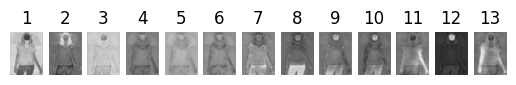

Epoch 1 | Batch 1221 | GenLoss 0.8166319727897644 | DiscLoss 7.924278179416433e-05
Epoch 1 | Batch 1222 | GenLoss 0.6806342601776123 | DiscLoss 6.151065463200212e-05
Epoch 1 | Batch 1223 | GenLoss 0.9413734078407288 | DiscLoss 6.19555648881942e-05
Epoch 1 | Batch 1224 | GenLoss 0.627772331237793 | DiscLoss 6.477256829384714e-05
Epoch 1 | Batch 1225 | GenLoss 0.5251725912094116 | DiscLoss 4.6755179937463254e-05
Epoch 1 | Batch 1226 | GenLoss 0.6684863567352295 | DiscLoss 6.585179653484374e-05
Epoch 1 | Batch 1227 | GenLoss 0.6049126386642456 | DiscLoss 5.638974835164845e-05
Epoch 1 | Batch 1228 | GenLoss 0.617250919342041 | DiscLoss 5.43737223779317e-05
Epoch 1 | Batch 1229 | GenLoss 0.7332313060760498 | DiscLoss 5.972656072117388e-05
Epoch 1 | Batch 1230 | GenLoss 0.6480495929718018 | DiscLoss 6.573931750608608e-05


In [ ]:
for epoch in range(epochs):
    for i,data in enumerate(train_dataloader):
        if i>1770:
            break
        inputs,masks=data
        
        # Training discriminator
        
        # Clear discriminator gradients
        optimizer_d.zero_grad()
        
        #send to device
        inputs = inputs.to(device)
        masks=masks.to(device)
        # Pass real images through discriminator
        
        real_preds = discriminator(torch.cat([inputs, masks], dim=1))
        real_targets = torch.ones(inputs.size(0), 1, device=device)
        
        real_loss = criterion_bce(real_preds, real_targets)  #calculate loss for real images

        # Generate fake images
        
#         latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=device)
            #lmao latent is now the real_images
        fake_masks = generator(inputs)
        
        # Pass fake images through discriminator
        fake_targets = torch.zeros(fake_masks.size(0), 1, device=device)
        fake_preds = discriminator(torch.cat([inputs, fake_masks], dim=1))
        fake_loss = criterion_bce(fake_preds, fake_targets) #calculate loss for generated images
        
        # Update discriminator weights
        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        optimizer_d.step()      #update disc weights
        
        # Training generator

    
        # Clear generator gradients
        optimizer_g.zero_grad()

        # Generate fake images
        
        #latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=device)
        fake_masks = generator(inputs)

        # Try to fool the discriminator
        
        preds = discriminator(torch.cat([inputs, fake_masks], dim=1))
        chinki_loss= torch.nn.functional.cross_entropy(fake_masks, masks, reduction='mean')
        
        targets = torch.ones(BATCH_SIZE, 1, device=device)
        
        gen_loss = criterion_pixelwise(preds, targets) + 10*chinki_loss

        # Update generator weights
        gen_loss.backward()
        
        optimizer_g.step()

        print(f"Epoch {epoch} | Batch {i} | GenLoss {gen_loss} | DiscLoss {disc_loss}")
        
        if i % 20 == 0:
            with torch.no_grad():
                # Take one image sample for visualization
                sample_input = inputs[0].unsqueeze(0).to(device)
                sample_fake_masks = generator(sample_input)

            # Visualize all 13 channels separately
            for channel in range(sample_fake_masks.size(1)):
                plt.subplot(1, 13, channel + 1)
                plt.imshow(sample_fake_masks[0, channel].cpu(), cmap='gray')
                plt.title(f'{channel + 1}')
                plt.axis('off')
            plt.show()

In [ ]:
weights_dir = "/kaggle/working/"
generator_weights_path = os.path.join(weights_dir, 'G1_weights2_0002_e5_l111_l210.pth')
torch.save(generator.state_dict(), generator_weights_path)
print(f"Generator weights saved to: {generator_weights_path}")

In [ ]:
# # Assuming 13 channels in the mask
# num_channels = 13

# # Set model to evaluation mode
# generator.eval()
# runtimes = 5000

# # Iterate over the dataset for thresholding
# for inputs, ground_truth_masks in train_dataloader:
#     runtimes -= 1
#     if runtimes == 0:
#         break
#     inputs = inputs.to(device)

#     # Generate fake masks
#     generated_masks = generator(inputs)

#     # Apply thresholding
#     threshold = 0.2
#     generated_masks_binary = (generated_masks > threshold).float()

#     # Visualize original and thresholded masks for one sample
#     with torch.no_grad():
#         sample_input = inputs[0].unsqueeze(0).to(device)
#         sample_generated_masks = generator(sample_input)
#         sample_generated_masks_binary = (sample_generated_masks > threshold).float()

#     plt.figure(figsize=(15, 10))

#     # Display predicted masks
# #     for i in range(num_channels):
# #         plt.subplot(2, num_channels, i + 1)
# #         plt.imshow(sample_generated_masks[0, i].cpu(), cmap='gray')
# #         plt.title(f'P{i + 1}')
# #         plt.axis('off')

#     # Display thresholded masks
#     for i in range(num_channels):
#         plt.subplot(2, num_channels, num_channels + i + 1)
#         plt.imshow(sample_generated_masks_binary[0, i].cpu(), cmap='gray')
#         plt.title(f'T{i + 1}')
#         plt.axis('off')

#     plt.show()

#     # Display ground truth masks
#     plt.figure(figsize=(15, 10))
#     for i in range(num_channels):
#         plt.subplot(1, num_channels, i + 1)
#         plt.imshow(ground_truth_masks[0, i].cpu(), cmap='gray')
#         plt.title(f'G{i + 1}')
#         plt.axis('off')

#     plt.show()

#     print("\n\n")
# # Set model back to training mode
# generator.train()